In [1]:
"""
Training Pipeline for LSTMABAR
Includes data loading, training loop, and evaluation
"""

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import librosa
from pathlib import Path
from typing import Dict, List, Optional, Tuple
import matplotlib.pyplot as plt

from lstmabar_model import LSTMABAR, LSTMABARTrainer
from musiccaps_loader import MusicCapsLoader

/home/zain/anaconda3/envs/lab3py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


=== Testing Archetype Prediction ===
Predicted weights shape: torch.Size([8, 5])
Sample prediction: tensor([0.2821, 0.2360, 0.2499, 0.1186, 0.1133], grad_fn=<SelectBackward0>)
Sum of weights: 1.000000 (should be ~1.0)

Named predictions for sample 0:
  sine: 0.1358
  square: 0.5490
  sawtooth: 0.1647
  triangle: 0.0695
  noise: 0.0809

=== Testing Archetype Loss ===
MSE loss: 0.0263

=== Testing RLHF Trainer with Audio Playback ===

HUMAN FEEDBACK COLLECTION

Description: 'bright and cutting guitar tone'

Predicted Archetype Weights:
  sine      : █████ 0.282
  square    : ████ 0.236
  sawtooth  : ████ 0.250
  triangle  : ██ 0.119
  noise     : ██ 0.113

------------------------------------------------------------
AUDIO PLAYBACK
------------------------------------------------------------

▶️  ORIGINAL AUDIO:



▶️  TRANSFORMED AUDIO:



------------------------------------------------------------
RATING INSTRUCTIONS
------------------------------------------------------------
Rate how well the transformation matches the description:
  5 = Perfect match
  4 = Good match
  3 = Acceptable match
  2 = Poor match
  1 = Very poor match

✓ Feedback recorded: 5.0/5


=== Interactive RLHF Usage Example ===

# In Jupyter notebook, use this pattern:

# 1. Generate or load audio samples
original_audio = librosa.load('input.wav')[0]
transformed_audio = model.transform(original_audio, description)

# 2. Get embeddings and predictions
text_emb = text_encoder([description])
audio_emb = audio_encoder(torch.from_numpy(original_audio))
predicted_weights = predictor(text_emb, audio_emb)

# 3. Collect interactive feedback with audio playback
rating = rlhf_trainer.collect_feedback_with_audio(
description="bright and crunchy",
original_audio=original_audio,
transformed_audio=transformed_audio,
predicted_weights=predicted_weights[0].cpu().n

In [2]:
class MusicCapsDataset(Dataset):
    """
    PyTorch Dataset for MusicCaps with archetype annotations
    """
    
    def __init__(
        self,
        training_data_path: str,
        sample_rate: int = 44100,
        audio_duration: float = 2.0,
        augment: bool = False
    ):
        """
        Args:
            training_data_path: Path to .npz file with training data
            sample_rate: Audio sample rate
            audio_duration: Duration to load from each audio file
            augment: Whether to apply data augmentation
        """
        self.sample_rate = sample_rate
        self.audio_duration = audio_duration
        self.augment = augment
        self.target_samples = int(sample_rate * audio_duration)
        
        # Load training data
        print(f"Loading training data from {training_data_path}")
        data = np.load(training_data_path, allow_pickle=True)
        
        self.archetype_vectors = torch.from_numpy(data['archetype_vectors']).float()
        self.descriptions = data['descriptions'].tolist()
        self.audio_paths = data['audio_paths'].tolist()
        self.archetype_order = data['archetype_order'].tolist()
        
        print(f"Loaded {len(self.descriptions)} training examples")
        
        # Filter out samples with missing audio files
        self.valid_indices = self._find_valid_samples()
        print(f"Found {len(self.valid_indices)} samples with valid audio files")
    
    def _find_valid_samples(self) -> List[int]:
        """Find indices with existing audio files"""
        valid = []
        for i, audio_path in enumerate(self.audio_paths):
            if Path(audio_path).exists():
                valid.append(i)
        return valid
    
    def __len__(self) -> int:
        return len(self.valid_indices)
    
    def __getitem__(self, idx: int) -> Dict:
        """
        Get a single training sample
        
        Returns:
            Dict with 'audio', 'description', 'archetype_weights'
        """
        # Map to valid index
        actual_idx = self.valid_indices[idx]
        
        # Load audio
        audio_path = self.audio_paths[actual_idx]
        audio, sr = librosa.load(
            audio_path,
            sr=self.sample_rate,
            duration=self.audio_duration
        )
        
        # Pad or trim to exact length
        if len(audio) < self.target_samples:
            audio = np.pad(audio, (0, self.target_samples - len(audio)))
        else:
            audio = audio[:self.target_samples]
        
        # Apply augmentation if enabled
        if self.augment:
            audio = self._augment_audio(audio)
        
        # Convert to tensor
        audio_tensor = torch.from_numpy(audio).float()
        
        # Get description and archetype weights
        description = self.descriptions[actual_idx]
        archetype_weights = self.archetype_vectors[actual_idx]
        
        return {
            'audio': audio_tensor,
            'description': description,
            'archetype_weights': archetype_weights
        }
    
    def _augment_audio(self, audio: np.ndarray) -> np.ndarray:
        """Apply random audio augmentations"""
        # Random gain (±3dB)
        if np.random.random() > 0.5:
            gain_db = np.random.uniform(-3, 3)
            audio = audio * (10 ** (gain_db / 20))
        
        # Random time shift
        if np.random.random() > 0.5:
            shift = np.random.randint(-self.sample_rate // 10, self.sample_rate // 10)
            audio = np.roll(audio, shift)
        
        # Add slight noise
        if np.random.random() > 0.5:
            noise = np.random.randn(len(audio)) * 0.005
            audio = audio + noise
        
        return audio


def collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function for DataLoader
    Handles variable-length descriptions
    """
    audio = torch.stack([item['audio'] for item in batch])
    descriptions = [item['description'] for item in batch]
    archetype_weights = torch.stack([item['archetype_weights'] for item in batch])
    
    return {
        'audio': audio,
        'descriptions': descriptions,
        'archetype_weights': archetype_weights
    }

In [3]:
class TrainingPipeline:
    """
    Complete training pipeline for LSTMABAR
    """
    
    def __init__(
        self,
        model: LSTMABAR,
        train_dataset: MusicCapsDataset,
        val_dataset: Optional[MusicCapsDataset] = None,
        batch_size: int = 16,
        learning_rate: float = 1e-4,
        num_epochs: int = 50,
        checkpoint_dir: str = 'checkpoints',
        log_interval: int = 10
    ):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.checkpoint_dir = Path(checkpoint_dir)
        self.log_interval = log_interval
        
        # Create checkpoint directory
        self.checkpoint_dir.mkdir(exist_ok=True)
        
        # Create data loaders
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=0,
            pin_memory=True
        )
        
        if val_dataset is not None:
            self.val_loader = DataLoader(
                val_dataset,
                batch_size=batch_size,
                shuffle=False,
                collate_fn=collate_fn,
                num_workers=0,
                pin_memory=True
            )
        else:
            self.val_loader = None
        
        # Initialize trainer
        self.trainer = LSTMABARTrainer(
            model,
            learning_rate=learning_rate,
            loss_weights={
                'contrastive': 0.7,
                'archetype_prediction': 0.2,
                'audio_archetype_supervision': 0.1
            }
        )
        
        print(f"Training pipeline initialized:")
        print(f"  Training samples: {len(train_dataset)}")
        print(f"  Validation samples: {len(val_dataset) if val_dataset else 0}")
        print(f"  Batch size: {batch_size}")
        print(f"  Total epochs: {num_epochs}")
        print(f"  Steps per epoch: {len(self.train_loader)}")
    
    def train(self):
        """Run complete training loop"""
        best_val_loss = float('inf')
        
        for epoch in range(self.num_epochs):
            print(f"\n{'='*60}")
            print(f"Epoch {epoch+1}/{self.num_epochs}")
            print(f"{'='*60}")
            
            # Training
            train_losses = self.trainer.train_epoch(self.train_loader, epoch)
            print(f"\nTrain Losses: {train_losses}")
            
            # Validation
            if self.val_loader is not None:
                val_losses = {'total': 0.0}
                for batch in self.val_loader:
                    batch_losses = self.trainer.validate(
                        batch['descriptions'],
                        batch['audio'].to(self.model.device),
                        batch['archetype_weights'].to(self.model.device)
                    )
                    for key in batch_losses:
                        val_losses[key] = val_losses.get(key, 0.0) + batch_losses[key]
                
                # Average validation losses
                for key in val_losses:
                    val_losses[key] /= len(self.val_loader)
                
                print(f"Val Losses: {val_losses}")
                
                # Save best model
                if val_losses['total'] < best_val_loss:
                    best_val_loss = val_losses['total']
                    save_path = self.checkpoint_dir / 'best_model.pth'
                    self.model.save_checkpoint(
                        str(save_path),
                        epoch,
                        self.trainer.optimizer.state_dict()
                    )
                    print(f"✓ Best model saved (val_loss: {best_val_loss:.4f})")
            
            # Save periodic checkpoint
            if (epoch + 1) % 10 == 0:
                save_path = self.checkpoint_dir / f'checkpoint_epoch_{epoch+1}.pth'
                self.model.save_checkpoint(
                    str(save_path),
                    epoch,
                    self.trainer.optimizer.state_dict()
                )
        
        print(f"\n{'='*60}")
        print("Training complete!")
        print(f"{'='*60}")
        
        # Save final model
        final_path = self.checkpoint_dir / 'final_model.pth'
        self.model.save_checkpoint(
            str(final_path),
            self.num_epochs - 1,
            self.trainer.optimizer.state_dict()
        )
        
        # Plot training history
        self.plot_training_history()
    
    def plot_training_history(self):
        """Plot training curves"""
        history = self.trainer.history
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Total loss
        axes[0].plot(history['train_loss'], label='Train Loss')
        if history['val_loss']:
            axes[0].plot(history['val_loss'], label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Total Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Component losses
        axes[1].plot(history['contrastive_loss'], label='Contrastive Loss')
        axes[1].plot(history['archetype_loss'], label='Archetype Loss')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Component Losses')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(self.checkpoint_dir / 'training_history.png', dpi=300)
        print(f"Training history plot saved to {self.checkpoint_dir / 'training_history.png'}")
        plt.close()


def prepare_musiccaps_data(
    csv_path: str,
    audio_dir: str = 'musiccaps_audio',
    output_path: str = 'musiccaps_training_data.npz',
    max_downloads: int = 5521,
    train_split: float = 0.7,
    val_split: float = 0.15,
    test_split: float = 0.15,
    random_seed: int = 42
) -> Tuple[str, str]:
    """
    Prepare MusicCaps dataset for training

    Args:
        csv_path: Path to MusicCaps CSV
        audio_dir: Directory to save audio
        output_path: Base path for output files
        max_downloads: Max clips to download
        train_split: Fraction for training (default 0.7)
        val_split: Fraction for validation (default 0.15)
        test_split: Fraction for testing (default 0.15)
        random_seed: Random seed for reproducibility
    
    Returns:
        Tuple of (train_path, val_path, test_path) .npz files
    """

    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, \
        "Splits must sum to 1.0"

    print("=== Preparing MusicCaps Dataset ===")
    
    # Load and process MusicCaps
    loader = MusicCapsLoader(csv_path, audio_dir)
    
    # Download audio clips
    print(f"\nDownloading up to {max_downloads} audio clips...")
    downloaded, failed = loader.download_audio_clips(
        max_clips=max_downloads,
        use_balanced_subset=False
    )
    
    print(f"Successfully downloaded: {len(downloaded)}")
    print(f"Failed: {len(failed)}")
    
    # Create archetype training data
    print("\nCreating archetype training data...")
    training_data = loader.create_archetype_training_data(use_tfidf_weighting=True)
    
    # Shuffle data for random splits
    np.random.seed(random_seed)
    indices = np.random.permutation(len(training_data))
    training_data = [training_data[i] for i in indices]
    
    # Calculate split points
    n_total = len(training_data)
    n_train = int(n_total * train_split)
    n_val = int(n_total * val_split)
    n_test = n_total - n_train - n_val
    
    # Split data
    train_data = training_data[:n_train]
    val_data = training_data[n_train:n_train + n_val]
    test_data = training_data[n_train + n_val:]
    
    print(f"\nDataset split:")
    print(f"  Train: {len(train_data)} samples ({train_split*100:.1f}%)")
    print(f"  Val:   {len(val_data)} samples ({val_split*100:.1f}%)")
    print(f"  Test:  {len(test_data)} samples ({test_split*100:.1f}%)")
    
    # Save train set
    train_path = output_path.replace('.npz', '_train.npz')
    vectors_train = np.array([item['archetype_vector'] for item in train_data])
    descriptions_train = [item['description'] for item in train_data]
    audio_paths_train = [item['audio_path'] for item in train_data]
    
    np.savez_compressed(
        train_path,
        archetype_vectors=vectors_train,
        descriptions=descriptions_train,
        audio_paths=audio_paths_train,
        archetype_order=train_data[0]['archetype_order']
    )
    print(f"\n✓ Saved train set: {train_path}")
    
    # Save val set
    val_path = output_path.replace('.npz', '_val.npz')
    vectors_val = np.array([item['archetype_vector'] for item in val_data])
    descriptions_val = [item['description'] for item in val_data]
    audio_paths_val = [item['audio_path'] for item in val_data]
    
    np.savez_compressed(
        val_path,
        archetype_vectors=vectors_val,
        descriptions=descriptions_val,
        audio_paths=audio_paths_val,
        archetype_order=val_data[0]['archetype_order']
    )
    print(f"✓ Saved val set: {val_path}")
    
    # Save test set
    test_path = output_path.replace('.npz', '_test.npz')
    vectors_test = np.array([item['archetype_vector'] for item in test_data])
    descriptions_test = [item['description'] for item in test_data]
    audio_paths_test = [item['audio_path'] for item in test_data]
    
    np.savez_compressed(
        test_path,
        archetype_vectors=vectors_test,
        descriptions=descriptions_test,
        audio_paths=audio_paths_test,
        archetype_order=test_data[0]['archetype_order']
    )
    print(f"✓ Saved test set: {test_path}")
    
    return train_path, val_path, test_path

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}\n")

# Configuration
config = {
    'embedding_dim': 768,
    'audio_architecture': 'resnet',  # or 'ast'
    'sample_rate': 44100,
    'audio_duration': 2.0,
    'batch_size': 16,
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'max_downloads': 5521
}

Using device: cpu



In [5]:
# Step 0: Download data (run once)

import kagglehub

# Download latest version
path = kagglehub.dataset_download("googleai/musiccaps")

print("Path to dataset files:", path)

csv_path = f"{path}/musiccaps-public.csv"

Path to dataset files: /home/zain/.cache/kagglehub/datasets/googleai/musiccaps/versions/1


In [6]:
# Step 1: Prepare dataset (run once)
print("Step 1: Preparing MusicCaps dataset with train/val/test split...")
train_data_path, val_data_path, test_data_path = prepare_musiccaps_data(
    csv_path=csv_path,
    audio_dir='musiccaps_audio',
    max_downloads=config['max_downloads'],
    train_split=0.7,
    val_split=0.15,
    test_split=0.15,
    random_seed=42
)

Step 1: Preparing MusicCaps dataset with train/val/test split...
=== Preparing MusicCaps Dataset ===
Loaded 5521 MusicCaps examples

✓ Already exists: -0Gj8-vB1q4
✓ Already exists: -0SdAVK79lg
✓ Already exists: -0vPFx-wRRI
✓ Already exists: -0xzrMun0Rs
✓ Already exists: -1LrH01Ei1w
✓ Already exists: -1OlgJWehn8
✓ Already exists: -1UWSisR2zo
✓ Already exists: -3Kv4fdm7Uk
✓ Already exists: -4NLarMj4xU
✓ Already exists: -4SYC2YgzL8
✓ Already exists: -5FoeegAgvU
✓ Already exists: -5f6hjZf9Yw
✓ Already exists: -5xOcMJpTUk
✓ Already exists: -6HBGg1cAI0
✓ Already exists: -6QGvxvaTkI
✓ Already exists: -6pcgdLfb_A
✓ Already exists: -7B9tPuIP-w
✓ Already exists: -7wUQP6G5EQ
✓ Already exists: -88me9bBzrk
✓ Already exists: -8C-gydUbR8
✓ Already exists: -8cgbhIR_pw
✓ Already exists: -BHPu-dPmWQ
✓ Already exists: -BIMKnb3tlo
✓ Already exists: -Bu7YaslRW0
✓ Already exists: -ByoSbgzr4M
✓ Already exists: -CUp_Tmg2Y0
✓ Already exists: -DeAdhYKbGE
✓ Already exists: -Dtir74TiUM
✓ Already exists: -EVRXQpt1



ERROR: ffmpeg exited with code 1


Error downloading -cQ-jUTEgck: ERROR: ffmpeg exited with code 1
✗ Failed: -cQ-jUTEgck
✓ Already exists: -dVgUSrR8g4
✓ Already exists: -e4wXAy1iVo
✓ Already exists: -eDAoheZrY8
✓ Already exists: -f1DNyngKVY
✓ Already exists: -f6s6kQEHFY
✓ Already exists: -fxh7jAJR8U
✓ Already exists: -hSMzrWZCAE
✓ Already exists: -hYRFCQdbLg
✓ Already exists: -i9gpG3vPwA
✓ Already exists: -i9uQMysy_A
✓ Already exists: -jpbCWcz2pk
✓ Already exists: -kpR93atgd8
✓ Already exists: -lPXTBXa0tE
✓ Already exists: -m5ZlWziIeA
✓ Already exists: -m9pH0WXQto
✓ Already exists: -mA_bqD1tgU
✓ Already exists: -mB_XLq6g1g
✓ Already exists: -nlkWWphiaM
✓ Already exists: -o0ZtQIkM60
✓ Already exists: -oP-XX28B0s
✓ Already exists: -pUfYFcsgG4
✓ Already exists: -qcTD2o6I9s
✓ Already exists: -r2-9oyIzkQ
✓ Already exists: -r7iz-9v9bA
✓ Already exists: -rAhS48FkYw
✓ Already exists: -sRFfU8k0Zs


ERROR: [youtube] -sevczF5etI: Video unavailable


Error downloading -sevczF5etI: ERROR: [youtube] -sevczF5etI: Video unavailable
✗ Failed: -sevczF5etI
✓ Already exists: -tKZOl4q1Kw
✓ Already exists: -taO6N-rxv4
✓ Already exists: -tmY1GEH3_Y


ERROR: [youtube] -tpq_bzSKes: Video unavailable. This video is not available


Error downloading -tpq_bzSKes: ERROR: [youtube] -tpq_bzSKes: Video unavailable. This video is not available
✗ Failed: -tpq_bzSKes
✓ Already exists: -uaTK8sa5Ms
✓ Already exists: -v5hgCh3M2w
✓ Already exists: -w12aSkQ9No
✓ Already exists: -w4HLksto_k
✓ Already exists: -w8maIWtnUk
✓ Already exists: -wVWjl9Kq6U
✓ Already exists: -wymN80CiYU
✓ Already exists: -zA6LL78KYU
✓ Already exists: -zOybsEdM5E
✓ Already exists: 0-7PyzhzuYQ
✓ Already exists: 00M9FhCet6s
✓ Already exists: 01PzcPKT3_E
✓ Already exists: 01hjVJN9xCg
✓ Already exists: 0298WjE3_tk
✓ Already exists: 02Qntw26enM


ERROR: [youtube] 03frQGyrgQ4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 03frQGyrgQ4: ERROR: [youtube] 03frQGyrgQ4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 03frQGyrgQ4
✓ Already exists: 03z0rpIkm5g
✓ Already exists: 04NjXsLyCl4
✓ Already exists: 05JAmKFVy44
✓ Already exists: 05OJDYeHLMc
✓ Already exists: 06Brdf83RZE
✓ Already exists: 06IU9WsEp3s
✓ Already exists: 07-3grCQ8EU
✓ Already exists: 07-vpXo91XM
✓ Already exists: 07FxCXxknY4
✓ Already exists: 07mS0mSTDjY
✓ Already exists: 07xGXxIHOL4
✓ Already exists: 08mf5GxT820
✓ Already exists: 08u-jdwjM74
✓ Already exists: 09lQmg2wvsY
✓ Already exists: 0ADP-O_V3vA
✓ Already exists: 0AGHo8V8HpM
✓ Already exists: 0AhX-ReXovI
✓ Already exists: 0BFauf6

ERROR: [youtube] 0J_2K1Gvruk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 0J_2K1Gvruk: ERROR: [youtube] 0J_2K1Gvruk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 0J_2K1Gvruk
✓ Already exists: 0J_TdiZ3TKA
✓ Already exists: 0JbGxIR8JTk
✓ Already exists: 0K-zyeLuKho
✓ Already exists: 0KCVgexi4yU
✓ Already exists: 0L2ndtt60Q8
✓ Already exists: 0L3vcdzQPPU
✓ Already exists: 0LE6Ll1rVlg
✓ Already exists: 0LLlcPiatiU
✓ Already exists: 0M7nETLOsKQ
✓ Already exists: 0MzrXd8CUCg
✓ Already exists: 0NTzOtVmoiU
✓ Already exists: 0NZY0GHQBP0
✓ Already exists: 0ONdm4sW47c
✓ Already exists: 0OY8XXZ98rw
✓ Already exists: 0OYlHvyfNk4
✓ Already exists: 0OhtODbKajw
✓ Already exists: 0Olm321vgk8
✓ Already exists: 0PMFAO4

ERROR: [youtube] 0VsjSa1X7iA: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 0VsjSa1X7iA: ERROR: [youtube] 0VsjSa1X7iA: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 0VsjSa1X7iA
✓ Already exists: 0VwX92X3iPc
✓ Already exists: 0Wdh45yt7tY
✓ Already exists: 0XxinBtKouQ
✓ Already exists: 0ZNFJz-eZTU
✓ Already exists: 0ZXWSO_Y2C0
✓ Already exists: 0_QcatLmg7c
✓ Already exists: 0_XItMAYkwc
✓ Already exists: 0_hH79HnEdo
✓ Already exists: 0a6uLBmqZgA
✓ Already exists: 0a91szM1Ivw
✓ Already exists: 0abzD7hBTRk
✓ Already exists: 0bP2MH3LqvI
✓ Already exists: 0bRUkLsttto
✓ Already exists: 0bvPjMQ_WbE
✓ Already exists: 0c1YU_VtFRE
✓ Already exists: 0cNYPgD6cEA
✓ Already exists: 0dPx94RPy2M
✓ Already exists: 0ewQiU3

ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited


Error downloading 0i8VM_EooCs: ERROR: [youtube] 0i8VM_EooCs: Video unavailable. This video is no longer available due to a copyright claim by Terrabyte Music Limited
✗ Failed: 0i8VM_EooCs
✓ Already exists: 0jFQ21A6GRA
✓ Already exists: 0kQD1P0_KUs
✓ Already exists: 0kQjfwXjFuY


ERROR: [youtube] 0khKvVDyYV4: Video unavailable


Error downloading 0khKvVDyYV4: ERROR: [youtube] 0khKvVDyYV4: Video unavailable
✗ Failed: 0khKvVDyYV4
✓ Already exists: 0lIETNZ_7sg
✓ Already exists: 0m9-5BkL4Mc
✓ Already exists: 0nNmbkU8GBI
✓ Already exists: 0nk7utNkHOY
✓ Already exists: 0oIFGARD9xE
✓ Already exists: 0pewITE1550
✓ Already exists: 0q-80dzp6PU
✓ Already exists: 0qtbbK5HVMw
✓ Already exists: 0rNr_qnoPQ4
✓ Already exists: 0s0Uy0-zBa0
✓ Already exists: 0sPVAP17w2U
✓ Already exists: 0soVCtJgDTk
✓ Already exists: 0trWdhSvab4
✓ Already exists: 0u1sk49gAU0
✓ Already exists: 0u4gY1bBUwQ
✓ Already exists: 0u5-WiBKam8
✓ Already exists: 0vFPs6XsU_Q
✓ Already exists: 0wYi8B9PXDY
✓ Already exists: 0wzsE67O5tE
✓ Already exists: 0x6chChxzV0
✓ Already exists: 0zolXzR9Oi4
✓ Already exists: 1-Y9kafYuqQ
✓ Already exists: 10dur7jhFQM
✓ Already exists: 11D0JdB7_4k
✓ Already exists: 11FeId69WOk
✓ Already exists: 11fNNN95_og
✓ Already exists: 13n6n6nKMhI
✓ Already exists: 14hTDUjCr_g
✓ Already exists: 15CZ2h5VL-A
✓ Already exists: 15Mw2jyyHk0

ERROR: [youtube] 1YPYQP6yupA: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 1YPYQP6yupA: ERROR: [youtube] 1YPYQP6yupA: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 1YPYQP6yupA
✓ Already exists: 1ZaxqZMs21M
✓ Already exists: 1Ziku4FLka4
✓ Already exists: 1_YHHL_t2GI
✓ Already exists: 1a_nvi4sW64
✓ Already exists: 1bSP4wLfMpA
✓ Already exists: 1cqcTbDxsHM
✓ Already exists: 1cwGW0cBdRs
✓ Already exists: 1dt9eL2rmSY
✓ Already exists: 1gDNqOQFopY
✓ Already exists: 1h2sb2xeCt8
✓ Already exists: 1hABzqBHh7w
✓ Already exists: 1hWAOReJehw
✓ Already exists: 1heMbyumHAo


ERROR: [youtube] 1i1sbQOILb0: Video unavailable


Error downloading 1i1sbQOILb0: ERROR: [youtube] 1i1sbQOILb0: Video unavailable
✗ Failed: 1i1sbQOILb0
✓ Already exists: 1j13NdQiw8c
✓ Already exists: 1j3pXUr8R4M
✓ Already exists: 1j4rFfU5XKQ
✓ Already exists: 1jATjKL2vAE
✓ Already exists: 1jptuEjuTig
✓ Already exists: 1kYDbl5Y9Sg
✓ Already exists: 1l7BjFDQLUM
✓ Already exists: 1lgqqW5TsJk
✓ Already exists: 1ls3ectO1F4
✓ Already exists: 1mB_cboJR8s
✓ Already exists: 1nUqhH8bAPk
✓ Already exists: 1o7iTDLNTFk
✓ Already exists: 1pR0SgbqP3M
✓ Already exists: 1rhsnmWLeGw
✓ Already exists: 1tNkAc29aPE
✓ Already exists: 1tz4xNRRR4M
✓ Already exists: 1uHF1-8TcEk
✓ Already exists: 1xhwyUVSRQk
✓ Already exists: 1y1lEOGBcWM
✓ Already exists: 1yGWdegJjA4
✓ Already exists: 1yWGmdevTuM
✓ Already exists: 1ypKEH2kd7g
✓ Already exists: 2-K-7T8ZIWA
✓ Already exists: 20QZS9L5WeA
✓ Already exists: 20Vh6z6Ie0E
✓ Already exists: 21MgIcLN8Ow
✓ Already exists: 23xC7lTBikU
✓ Already exists: 244y56-vLWE
✓ Already exists: 24cmo2fEQo8


ERROR: [youtube] 25Ccp8usBtE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 25Ccp8usBtE: ERROR: [youtube] 25Ccp8usBtE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 25Ccp8usBtE
✓ Already exists: 25RWrqQol7Y
✓ Already exists: 26HLgXWF-Co
✓ Already exists: 26IOFykrJrc
✓ Already exists: 26jTWRMRoxY
✓ Already exists: 28pkN4m1x6I
✓ Already exists: 28wBrNjHXOM
✓ Already exists: 298Q_pSLflU
✓ Already exists: 2ATMQxWVpXk
✓ Already exists: 2BBAUwC1BI4
✓ Already exists: 2BGzxAuetOA
✓ Already exists: 2CzfBZ1mYBs
✓ Already exists: 2FQKfGCwjSE
✓ Already exists: 2G4lyzAZ1vk


ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 2G5bSYHcJSM: ERROR: [youtube] 2G5bSYHcJSM: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 2G5bSYHcJSM
✓ Already exists: 2GWkKVHxGRM
✓ Already exists: 2GepmcbNlJY
✓ Already exists: 2Gja9wBkz6U
✓ Already exists: 2I6pPRWKsCQ
✓ Already exists: 2Ic1zm9mBjk
✓ Already exists: 2IpapScfsT4
✓ Already exists: 2JNY2SaMk7s
✓ Already exists: 2JnlmS1zzls
✓ Already exists: 2JuMYUPMGGM
✓ Already exists: 2KGnpMYHBGI
✓ Already exists: 2KkNk9Ao7G4
✓ Already exists: 2KwSyaLT_mw
✓ Already exists: 2M-CFCo-rkY
✓ Already exists: 2MZUbxulAI4
✓ Already exists: 2MpzHv5KNZU


ERROR: [youtube] 2OI4QeokeRQ: Sign in to confirm your age. The video you have requested has been rated TV-14 and may contain content intended for mature audiences. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 2OI4QeokeRQ: ERROR: [youtube] 2OI4QeokeRQ: Sign in to confirm your age. The video you have requested has been rated TV-14 and may contain content intended for mature audiences. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 2OI4QeokeRQ
✓ Already exists: 2Q20hVyYjBM
✓ Already exists: 2RMOegT2Jn8
✓ Already exists: 2RU4CSDzS-g
✓ Already exists: 2SI_uNBcSyw
✓ Already exists: 2SQxfaWAJJg
✓ Already exists: 2SenLjPbGzU
✓ Already exists: 2ShO1jZYZeA
✓ Already exists: 2T1P9ovsl4A
✓ Already exists: 2U8Dvh7nwFI
✓ Already exists: 2UY_-oF1vqo
✓ Already exists: 2Ui85-AOLyo
✓ Already exists: 2UnlMwW8nyI
✓ Already exists: 2VFVe0RCn7g
✓ Already exists: 2WxUIkF2zEw
✓ Already exists: 2YAyM0aHFRU
✓ Already exists: 2



ERROR: ffmpeg exited with code 1


Error downloading 3OLeJZF4oI0: ERROR: ffmpeg exited with code 1
✗ Failed: 3OLeJZF4oI0
✓ Already exists: 3OUNEL8XaR0
✓ Already exists: 3OWArQGgmm0
✓ Already exists: 3PoC1-xd4Yw
✓ Already exists: 3PuzzYmTDA4
✓ Already exists: 3PwR0D7CuwM
✓ Already exists: 3QNFY4MKTy4
✓ Already exists: 3QqVP0odOw4
✓ Already exists: 3R8xDvhJk54


ERROR: [youtube] 3TO4C7SiC7I: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 3TO4C7SiC7I: ERROR: [youtube] 3TO4C7SiC7I: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 3TO4C7SiC7I
✓ Already exists: 3TP1itJqv-E
✓ Already exists: 3TQmts_MxyQ
✓ Already exists: 3UHHjbO0ThM


ERROR: [youtube] 3VEMHWnewuc: Video unavailable. This video is no longer available due to a copyright claim by 創価学会


Error downloading 3VEMHWnewuc: ERROR: [youtube] 3VEMHWnewuc: Video unavailable. This video is no longer available due to a copyright claim by 創価学会
✗ Failed: 3VEMHWnewuc
✓ Already exists: 3VTinB14Pmw
✓ Already exists: 3Wdxjm-h36w
✓ Already exists: 3XL825fK6UM
✓ Already exists: 3XRjrSOVBnQ
✓ Already exists: 3XeMR8lX0dg
✓ Already exists: 3Xoz87_SUdw
✓ Already exists: 3Yc7_n6mDsI
✓ Already exists: 3YuO2UOYKRk
✓ Already exists: 3Z74i_FWs3o
✓ Already exists: 3ZhyXbwFQAM
✓ Already exists: 3ZyuBJEbmJM
✓ Already exists: 3_M9ZMo5TiU
✓ Already exists: 3b3s0TvjGwA
✓ Already exists: 3bg0iy-ypcw
✓ Already exists: 3cEQfNZ_F1w
✓ Already exists: 3dUo62RsD00
✓ Already exists: 3dzR3ZWOe8Y
✓ Already exists: 3e6GleQ9sl0
✓ Already exists: 3fqWosszpnE
✓ Already exists: 3gh1oldZ7Zc
✓ Already exists: 3jLef5eHgzU
✓ Already exists: 3kSQNjfJnN8
✓ Already exists: 3kXukXBvDQQ
✓ Already exists: 3m-a805cVl0
✓ Already exists: 3m4QSVVBMss
✓ Already exists: 3mNOJpN_qOQ
✓ Already exists: 3mStyfCbL68
✓ Already exists: 3nb

ERROR: [youtube] 3obJKn19jTE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 3obJKn19jTE: ERROR: [youtube] 3obJKn19jTE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 3obJKn19jTE
✓ Already exists: 3otUlQ4wvLY
✓ Already exists: 3pU34vUoO9g
✓ Already exists: 3q9K2PgA2-U
✓ Already exists: 3rbWoeUg9yo
✓ Already exists: 3rvqiSZB4pA
✓ Already exists: 3sIlpn9nvKU
✓ Already exists: 3sRO6iwfUxo
✓ Already exists: 3tK7PpCo0PQ
✓ Already exists: 3tSPMzvuQpk
✓ Already exists: 3tbFP_JKzXw
✓ Already exists: 3tlaELkmRqs
✓ Already exists: 3tyb0cXoX2g
✓ Already exists: 3u9OO9Og0Gc
✓ Already exists: 3ujGrObyefA
✓ Already exists: 3uz_ZrGsIaA
✓ Already exists: 3vEsFxolnFs
✓ Already exists: 3w3fD54bNvU
✓ Already exists: 3w4nFQr

ERROR: [youtube] 42xehaGoJbc: Video unavailable


Error downloading 42xehaGoJbc: ERROR: [youtube] 42xehaGoJbc: Video unavailable
✗ Failed: 42xehaGoJbc
✓ Already exists: 44sbWBFswUY
✓ Already exists: 45iNSkfzOwM
✓ Already exists: 46WpyRUqwXU
✓ Already exists: 476vNb6thyM
✓ Already exists: 49nqh7uI9fw
✓ Already exists: 4AejyFDHP_k
✓ Already exists: 4AfykLGm0j8
✓ Already exists: 4BIIFU_b6BY
✓ Already exists: 4Bc9OoagYmo
✓ Already exists: 4CkJjhuYRmY
✓ Already exists: 4CkZqT26Vb0
✓ Already exists: 4CrPPlHN9_s
✓ Already exists: 4EwWBI-tHLk
✓ Already exists: 4GlH0-KhInI
✓ Already exists: 4Gow6qZcNZI
✓ Already exists: 4H1nc2Xv2Hg
✓ Already exists: 4HfU5OQUqq0
✓ Already exists: 4HhJneiP-hY
✓ Already exists: 4JYJRqwqWGM
✓ Already exists: 4KqSdK5KM-I
✓ Already exists: 4L9KyVVsQOc
✓ Already exists: 4LZSSya3ZZQ
✓ Already exists: 4Lk8pUeLCwQ
✓ Already exists: 4M0njWKFsME
✓ Already exists: 4M_k01zIbVM
✓ Already exists: 4Mm5mBgktG0
✓ Already exists: 4Mo7tdV2LZk
✓ Already exists: 4PGzlwvXMnE
✓ Already exists: 4PNPgaLKFlc
✓ Already exists: 4Psj5jYa7a4

ERROR: [youtube] 4ymXDU-48EE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 4ymXDU-48EE: ERROR: [youtube] 4ymXDU-48EE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 4ymXDU-48EE
✓ Already exists: 4zZiWBp0b08
✓ Already exists: 5-aS_pyXesM
✓ Already exists: 5-tx4Fgqetc
✓ Already exists: 50QEapyTPD4
✓ Already exists: 50fuQm8B2Yg
✓ Already exists: 51bsCRv6kI0
✓ Already exists: 52GYcHTcCgs
✓ Already exists: 52odOK7G2kg
✓ Already exists: 53UF6F7D284
✓ Already exists: 54yI3In3DrU
✓ Already exists: 55qucu8Zs_I
✓ Already exists: 55vMO5LzMHM
✓ Already exists: 56Cm1AkbfbU


ERROR: [youtube] 577NM64YL18: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 577NM64YL18: ERROR: [youtube] 577NM64YL18: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 577NM64YL18
✓ Already exists: 588osm3C4bw
✓ Already exists: 58JwiVM8bYM
✓ Already exists: 58f4AsxOYhU
✓ Already exists: 59Mt7J_0KT4
✓ Already exists: 5AdeNHlPnvs
✓ Already exists: 5BEVY0vaygg
✓ Already exists: 5C70IZwHA5g
✓ Already exists: 5CtvEcPtknI
✓ Already exists: 5D4siJjh1j0
✓ Already exists: 5DDg2CzAmgE
✓ Already exists: 5DNl3DX4rr0
✓ Already exists: 5F8zpfwFKl0
✓ Already exists: 5FbQu7QTme0
✓ Already exists: 5FlNBuS7YgM
✓ Already exists: 5J6CjNc8Njo
✓ Already exists: 5JQIsqc8HBc
✓ Already exists: 5JRvGMTjEzQ
✓ Already exists

ERROR: [youtube] 5Y_mT93tkvQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 5Y_mT93tkvQ: ERROR: [youtube] 5Y_mT93tkvQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 5Y_mT93tkvQ
✓ Already exists: 5ZX1-GAb7IM
✓ Already exists: 5ZX9Ig7XXsw
✓ Already exists: 5ZpVhmhVYoI
✓ Already exists: 5_orEetudIA
✓ Already exists: 5aCDam9_Ps4
✓ Already exists: 5a_Qxd4ECTo
✓ Already exists: 5at69yM1PoU
✓ Already exists: 5blPLHS0Cko
✓ Already exists: 5bn7PPKcqSA
✓ Already exists: 5bsUYmXIgMA
✓ Already exists: 5dG1oPahyto
✓ Already exists: 5fPxUI0Fl-4
✓ Already exists: 5gh5H0QqJl0
✓ Already exists: 5gyMt0YzPQ0
✓ Already exists: 5h5NdW6cYY0
✓ Already exists: 5hEt87nd7os
✓ Already exists: 5hyRWertUbI
✓ Already exists: 5i0zq91Ocz0
✓ Already exists: 5iPTcL50mvw
✓ Already exists: 5iUwBOf4yek
✓ Already exists: 5ieMy-PAKA0
✓ Already exists: 5jQIuYPAODg
✓ Already exists: 5jT_i7S9QSM
✓ Already exists: 5keRbrVx-G4
✓ Already exists: 5lZFGZXH20E
✓ Already exists: 5mLYN-F2Oek
✓ Alread

ERROR: [youtube] 63rqIYPHvlc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 63rqIYPHvlc: ERROR: [youtube] 63rqIYPHvlc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 63rqIYPHvlc
✓ Already exists: 64auWicQqZY
✓ Already exists: 65KYS3lIRII
✓ Already exists: 669Fk7afszw
✓ Already exists: 66B46E_hrrk
✓ Already exists: 67S7s_jFXhc
✓ Already exists: 6807299U5eg
✓ Already exists: 682ODyTqKyw
✓ Downloaded: 68DacKw1hlE (707/5521)                  
✓ Already exists: 68XchGI6H-4
✓ Already exists: 69oU6LfyQ_4
✓ Already exists: 6AC84nr6ckM
✓ Already exists: 6BitLl5Bnxw
✓ Already exists: 6C0HoQe4Y-Y
✓ Already exists: 6CaZAITdAsk
✓ Already exists: 6EwEo0JQkTg
✓ Already exists: 6F8qv0JBWkE
✓ Already exists: 6FQ1nQ0FvgQ


ERROR: [youtube] 6_zzu2KON6c: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 6_zzu2KON6c: ERROR: [youtube] 6_zzu2KON6c: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 6_zzu2KON6c
✓ Already exists: 6ayVxYbKBe0
✓ Already exists: 6c1vNidtVTc
✓ Already exists: 6cQbxwbBqqI
✓ Already exists: 6cQjwXNY4sc
✓ Already exists: 6dFCMXNlmzQ
✓ Already exists: 6elnFyuUnaU
✓ Already exists: 6evOjRxZlHI
✓ Already exists: 6gTrMRQPZMU
✓ Already exists: 6iZ49s7eH5g
✓ Already exists: 6ieXDFjLKNo
✓ Already exists: 6iyinlZEgS4
✓ Already exists: 6jZ8VNANHwM
✓ Already exists: 6jdeSAmkzEU
✓ Already exists: 6jeq5lP5Up0
✓ Already exists: 6k4lcF9IGUk
✓ Already exists: 6k6tF0s0lNs
✓ Already exists: 6lPgzqrvHHw
✓ Already exists: 6lPw0wK



ERROR: ffmpeg exited with code 1


Error downloading 6xxu6f0f0e4: ERROR: ffmpeg exited with code 1
✗ Failed: 6xxu6f0f0e4
✓ Already exists: 6yB6plsrjO0
✓ Already exists: 6zgvEiJJrM8
✓ Already exists: 7-mNJ4IUY5Q
✓ Already exists: 70pyoqX0U9Y
✓ Already exists: 71KE7B1vvdI
✓ Already exists: 71hqRT9U0wg
✓ Already exists: 72_Hk1cdoxk


ERROR: [youtube] 73YTz8RC2Fo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading 73YTz8RC2Fo: ERROR: [youtube] 73YTz8RC2Fo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: 73YTz8RC2Fo
✓ Already exists: 74p3DLeDCHE
✓ Already exists: 752bW5cjXzw
✓ Already exists: 75UH33tO0Bo
✓ Already exists: 75_dMqpSM4o
✓ Already exists: 769EHEG4Mqc
✓ Already exists: 76ON0Ixrr9s
✓ Already exists: 770ZkZhGy6A
✓ Already exists: 78BtX0oNXHQ
✓ Already exists: 78S8DnvLQDY
✓ Already exists: 79tuMIiWMZ4
✓ Already exists: 7AC9RqECN5k
✓ Already exists: 7B1OAtD_VIA
✓ Already exists: 7DIPyJB4osY


ERROR: [youtube] 7EvLwfwRrqA: Video unavailable


Error downloading 7EvLwfwRrqA: ERROR: [youtube] 7EvLwfwRrqA: Video unavailable
✗ Failed: 7EvLwfwRrqA
✓ Already exists: 7FHzw4HV75Y
✓ Already exists: 7FkuqqdWRhw
✓ Already exists: 7Ht_Vu1D8nc
✓ Already exists: 7ITwarmdyfI
✓ Already exists: 7IllUjk5fk0
✓ Already exists: 7IndxxjZe1c
✓ Already exists: 7J6U-HE3Lko
✓ Already exists: 7JE2eBK1f9M
✓ Already exists: 7JMN4DdhwsM
✓ Already exists: 7KCikXm6hic
✓ Already exists: 7KIn0zojwu8
✓ Already exists: 7L5HQ4AJyLc


ERROR: [youtube] 7LGLhQFiE0s: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 7LGLhQFiE0s: ERROR: [youtube] 7LGLhQFiE0s: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 7LGLhQFiE0s
✓ Already exists: 7LlKoQAvXUc
✓ Already exists: 7LlnLjZOqVI
✓ Already exists: 7Msk_hkz6zk
✓ Already exists: 7MuFNZHhrOE
✓ Already exists: 7Mv4eKPe850
✓ Already exists: 7NF2kcEfMBI
✓ Already exists: 7NnvEryyYdo
✓ Already exists: 7NtM1MM76s0
✓ Already exists: 7OgH3B49_E4
✓ Already exists: 7OjXHfVoI64
✓ Already exists: 7PtHb9jQCtg
✓ Already exists: 7RUkkhkqyUw
✓ Already exists: 7RtQpW2dSU4
✓ Already exists: 7S3fU4RHabw
✓ Already exists: 7TmKzUgWiRU
✓ Already exists: 7Us4WHDmfeA
✓ Already exists: 7V0G65FK2VQ
✓ Already exists: 7Vjp9y6

ERROR: [youtube] 7nrOZXbpXBo: Video unavailable. This video contains content from Central Partnership 2, who has blocked it in your country on copyright grounds


Error downloading 7nrOZXbpXBo: ERROR: [youtube] 7nrOZXbpXBo: Video unavailable. This video contains content from Central Partnership 2, who has blocked it in your country on copyright grounds
✗ Failed: 7nrOZXbpXBo
✓ Already exists: 7pYavsK9sPg
✓ Already exists: 7p_Mnxl4Vq8
✓ Already exists: 7pdrGzdWMzI
✓ Already exists: 7qaRlUc4fb0
✓ Already exists: 7uKkUTml-DA
✓ Already exists: 7vC1iriZlX8
✓ Already exists: 7wSTdp1hiTA
✓ Already exists: 7xD_Ib3VS_w
✓ Already exists: 7y9RfZXJZsk
✓ Already exists: 7yK4-hsVX1o
✓ Already exists: 7ym-LzgwSPE
✓ Already exists: 7zP5kNyDn88
✓ Already exists: 81SgTHg66QY
✓ Already exists: 86YDiQjYU1U
✓ Already exists: 886Qu4V0km4
✓ Already exists: 89eBh_Djflw
✓ Already exists: 8BJljuSm2Aw
✓ Already exists: 8Bu8CkR1xZY
✓ Already exists: 8CY7G2NrlxY
✓ Already exists: 8DHtPopFvII
✓ Already exists: 8DQbnR7hwpc
✓ Already exists: 8DTKCAv9ods


ERROR: [youtube] 8FZb_R2UANY: Video unavailable. This video contains content from SBS(Seoul Broadcasting System), who has blocked it on copyright grounds


Error downloading 8FZb_R2UANY: ERROR: [youtube] 8FZb_R2UANY: Video unavailable. This video contains content from SBS(Seoul Broadcasting System), who has blocked it on copyright grounds
✗ Failed: 8FZb_R2UANY
✓ Already exists: 8FawGISo8wY
✓ Already exists: 8GKbDSu9Xd0
✓ Already exists: 8HHrlxQuZKE
✓ Already exists: 8Ha5qGnT7lg
✓ Already exists: 8KIoQ2HZ0Hg
✓ Already exists: 8KUV2TFTpGo
✓ Already exists: 8LP_wbFLaJE
✓ Already exists: 8LYWfpPUokc
✓ Already exists: 8MF6nFj02sM
✓ Already exists: 8MKemM0h5mE
✓ Already exists: 8MbxazeMw2E
✓ Already exists: 8NIxqHJrL68
✓ Already exists: 8Nrp4jUZeGE
✓ Already exists: 8OsmFmhNjoA
✓ Already exists: 8PcfPX11Hjg
✓ Already exists: 8UhdwnsckJ8
✓ Already exists: 8WPG0dD20lg
✓ Already exists: 8WnXfe3ud4E
✓ Already exists: 8XBsesSEbbU
✓ Already exists: 8XGXHDMIJw4


ERROR: [youtube] 8Y0FRjkX9xI: Video unavailable


Error downloading 8Y0FRjkX9xI: ERROR: [youtube] 8Y0FRjkX9xI: Video unavailable
✗ Failed: 8Y0FRjkX9xI
✓ Already exists: 8Yt55huZGZc
✓ Already exists: 8Z5xnSxUmGE


ERROR: [youtube] 8ZK1ajW598M: Video unavailable


Error downloading 8ZK1ajW598M: ERROR: [youtube] 8ZK1ajW598M: Video unavailable
✗ Failed: 8ZK1ajW598M
✓ Already exists: 8akqVDDGsNQ
✓ Already exists: 8dE1x--TuF8




ERROR: ffmpeg exited with code 1


Error downloading 8fInAz_GICs: ERROR: ffmpeg exited with code 1
✗ Failed: 8fInAz_GICs
✓ Already exists: 8fibq2VXibw
✓ Already exists: 8hO1S9VIfPY
✓ Already exists: 8hSmQpOPXJE


ERROR: [youtube] 8hT2G2ew6-c: Video unavailable


Error downloading 8hT2G2ew6-c: ERROR: [youtube] 8hT2G2ew6-c: Video unavailable
✗ Failed: 8hT2G2ew6-c
✓ Already exists: 8iPpgyEh8WM
✓ Already exists: 8jDanS4ZzRc
✓ Already exists: 8kH-dzSBthI
✓ Already exists: 8kx5ST65Fog
✓ Already exists: 8m-a_6wLTkU
✓ Already exists: 8nJ2MhvhnJ0
✓ Already exists: 8ntKBILZ06k
✓ Already exists: 8o2UyEYbNmY
✓ Already exists: 8oTTgXIO0-I
✓ Already exists: 8oUI02eK3SM


ERROR: [youtube] 8olHAhUKkuk: Video unavailable


Error downloading 8olHAhUKkuk: ERROR: [youtube] 8olHAhUKkuk: Video unavailable
✗ Failed: 8olHAhUKkuk
✓ Already exists: 8pYHLfKqHL4
✓ Already exists: 8pc8fjPIV-Q
✓ Already exists: 8pit9UV69S8
✓ Already exists: 8pl1D6oG38k
✓ Already exists: 8q0An6WY7_c
✓ Already exists: 8qeTEfOqB0A
✓ Already exists: 8r1y_Bz4VfQ
✓ Already exists: 8rCYRgePG-4
✓ Already exists: 8sSV_vqOlS4
✓ Already exists: 8tY6nioUQIw
✓ Already exists: 8vFJX7NcSbI
✓ Already exists: 8wty3wJfmEY
✓ Already exists: 8y36aT4C_c0
✓ Already exists: 8yiJOImd6k0
✓ Already exists: 8ynjAtF5VnA
✓ Already exists: 8zCZzzAaC4I
✓ Already exists: 8zDbEfC6Uf0
✓ Already exists: 8zGJ9N7c6pE
✓ Already exists: 8zcogfmAD_o
✓ Already exists: 9-R70gSqvrc
✓ Already exists: 90NsBZvepy0
✓ Already exists: 91AmOKytRUM
✓ Already exists: 91Qp8XUskXo
✓ Already exists: 92QYLjfo68Q
✓ Already exists: 92k_81uqMSM
✓ Already exists: 92sRFZvCnWo
✓ Already exists: 940MNbCeobw
✓ Already exists: 95ThRxhl-ug
✓ Already exists: 98YBS2tdpdU
✓ Already exists: 99ZgIQwLC60

ERROR: [youtube] 9ZeoYezrI7Q: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading 9ZeoYezrI7Q: ERROR: [youtube] 9ZeoYezrI7Q: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: 9ZeoYezrI7Q
✓ Already exists: 9ZilD_4pi7E
✓ Already exists: 9ZinCW4jTeE
✓ Already exists: 9ZryMX2UtAo
✓ Already exists: 9aE33JEIGOg
✓ Already exists: 9cojCCMSABc
✓ Already exists: 9dBWFEpcJIo
✓ Already exists: 9dx9IhSqwC4
✓ Already exists: 9gCeNCnWZhE
✓ Already exists: 9gSOOPDuD4Y
✓ Already exists: 9gkppwB5CXA
✓ Already exists: 9hCnEfZFZ04
✓ Already exists: 9iYxf1hS4Yk
✓ Already exists: 9jeEfi6nDak
✓ Already exists: 9kt7rsziUVQ
✓ Already exists: 9m0tNvskmTc
✓ Already exists: 9mIDP_OT1uM
✓ Already exists: 9mqA4YdX444
✓ Already exists: 9nVpyqf

ERROR: [youtube] AFWy1qyyMHE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading AFWy1qyyMHE: ERROR: [youtube] AFWy1qyyMHE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: AFWy1qyyMHE
✓ Already exists: AFwmMFq_xlc
✓ Already exists: AFwtBviVhhM
✓ Already exists: AGNqX_OL-dU
✓ Already exists: AGsMCWB1tTk
✓ Already exists: AH6Xnyj6Ykc
✓ Already exists: AHmcuClSTL4
✓ Already exists: AHrUfa2H_5s
✓ Already exists: AI9P6HoiJy8
✓ Already exists: AJROvxlmo40
✓ Already exists: AJTU5RhF3S4
✓ Already exists: AJeRSlZuZbk
✓ Already exists: AJj6GGLaIfI
✓ Already exists: AJw-x30L46E
✓ Already exists: AKI0VrXEDww
✓ Already exists: ALU-1AILj1c
✓ Already exists: ALVS3Q_jNaU
✓ Already exists: ALcCb2HJmG8
✓ Already exists: ANaaOqwO0Uo
✓ Already exists: AOgbZUl0y0A
✓ Already exists: APSbmhJam74
✓ Already exists: APTh9uhf7WQ
✓ Already exists: APUDprnfOIs
✓ Already exists: ARXTRdKCupM
✓ Already exists: ASgLbz48BaY
✓ Already exists: ATDi-irUEWc
✓ Already exists: AT_076RUWPs
✓ Alread

ERROR: [youtube] AaUZb-iRStE: Video unavailable


Error downloading AaUZb-iRStE: ERROR: [youtube] AaUZb-iRStE: Video unavailable
✗ Failed: AaUZb-iRStE
✓ Already exists: AaVUuKl8294
✓ Already exists: AaajkQEU3A0
✓ Already exists: AagemOzvoZE
✓ Already exists: Aak-VLHtFPM
✓ Already exists: AareFwTIg1s
✓ Already exists: Ac4M-EkdkDs
✓ Already exists: AcX1B_Pr-RQ
✓ Already exists: AcX6rAwFTiY
✓ Already exists: Ade0UZnb6dw
✓ Already exists: AdxKsUW2mAo
✓ Already exists: Ae8o_FMI0Xs
✓ Already exists: AeDNy6Ff7VE
✓ Already exists: AeXDtbfpQlQ
✓ Already exists: AgCSBCsHkMk
✓ Already exists: AgJH6Ul1EFg
✓ Already exists: AgVUGzrzJ20
✓ Already exists: AgtY6m-b3Gk


ERROR: [youtube] Ah_aYOGnQ_I: This video has been removed for violating YouTube's Terms of Service


Error downloading Ah_aYOGnQ_I: ERROR: [youtube] Ah_aYOGnQ_I: This video has been removed for violating YouTube's Terms of Service
✗ Failed: Ah_aYOGnQ_I
✓ Already exists: AiGGDpbgp6I
✓ Already exists: Ail32Z1T4QM
✓ Already exists: AjLX_1rBDPM
✓ Already exists: AjLuenrAsbE
✓ Already exists: AjjQqd0eLzw
✓ Already exists: AkHaDKuiE_s
✓ Already exists: AkbCw7oVkw0
✓ Already exists: Akg1n9IWSrw
✓ Already exists: Aky0DF507fw
✓ Already exists: AlVr7-ntuqw
✓ Already exists: Al_OdIuqoe0
✓ Already exists: AmAThmRphk0
✓ Already exists: An-4jPvUT14
✓ Already exists: AnErEDywInE
✓ Already exists: AnMR6SOBa9k
✓ Already exists: AobHGHJSd-s
✓ Already exists: ApDJYsi9UGg
✓ Already exists: AqSV_WKZxEc
✓ Already exists: Aro-HcWNsHI
✓ Already exists: Arqvnp6yUCg
✓ Already exists: AsR5us-IS00
✓ Already exists: At5v5ZZQHmw
✓ Already exists: AtJ2RXQ98kY
✓ Already exists: AtWf5OAE8aM
✓ Already exists: AuG9i5cwGW0
✓ Already exists: AuZNuyR2OJs
✓ Already exists: AuvFmMpgj70
✓ Already exists: AuwwPMrH5sE
✓ Alread

ERROR: [youtube] B7iRvj8y9aU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading B7iRvj8y9aU: ERROR: [youtube] B7iRvj8y9aU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: B7iRvj8y9aU
✓ Already exists: B8pesuUc8Ek
✓ Already exists: B90BOtSOD2Q
✓ Already exists: B9IAl-ygE2k
✓ Already exists: B9K58KYq-Cs
✓ Already exists: B9ME0Vcm_xA
✓ Already exists: BAUQY0e25DM
✓ Already exists: BBSApRvkaqY
✓ Already exists: BBmXMoI9Qus
✓ Already exists: BC7dI3lQ2Cg
✓ Already exists: BDH7Fx1APR8
✓ Already exists: BEEknOFrVdU
✓ Already exists: BEZdszHKGTQ
✓ Already exists: BEhIGoq9tow
✓ Already exists: BEwNrjvNiYs
✓ Already exists: BGD7J6MP2C8
✓ Already exists: BHDhHO7J-Oo
✓ Already exists: BHu95Y_kVQA
✓ Already exists: BI8YQ3ueD24
✓ Already exists: BK2laUCyaH0


ERROR: [youtube] BKQYrrJVg6g: Video unavailable


Error downloading BKQYrrJVg6g: ERROR: [youtube] BKQYrrJVg6g: Video unavailable
✗ Failed: BKQYrrJVg6g
✓ Already exists: BL181hSAG60
✓ Already exists: BM9XDXA-CUE
✓ Already exists: BMPmavj4keA
✓ Already exists: BMgYWTTJv3s
✓ Already exists: BMxgDBoPv_0
✓ Already exists: BN63M3_lPCQ
✓ Already exists: BN6W6OQnVoE
✓ Already exists: BQ_KrefFiTw
✓ Already exists: BR5MDhvcGM8
✓ Already exists: BRTHyoVgZT0
✓ Already exists: BS2ZnUhmHj4
✓ Already exists: BSLriWJ7hn8
✓ Already exists: BSe5J0KlN3k
✓ Already exists: BT4env-Tw2o
✓ Already exists: BTMWpYzpu5g
✓ Already exists: BUDb8YieUgU
✓ Already exists: BUzsQ6WohH4
✓ Already exists: BVonSUC3zIQ
✓ Already exists: BVt8RgNrwbQ
✓ Already exists: BWKQXn5xDwo
✓ Already exists: BWSJjF32tQA
✓ Already exists: BWVovghBe2c
✓ Already exists: BWvKAcOV_co
✓ Already exists: BXUS7pTYDzI
✓ Already exists: BXcEsM8ykhE


ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe


Error downloading BXo1Tr_oJds: ERROR: Postprocessing: WARNING: unable to obtain file audio codec with ffprobe
✗ Failed: BXo1Tr_oJds
✓ Already exists: BXv69uAoHk4
✓ Already exists: BYi0fAZtBls
✓ Already exists: BYnYTgeM6Go
✓ Already exists: BYwS1dJRTi0
✓ Already exists: BZyf8LPltYs
✓ Already exists: B_kAtTBUDIA
✓ Already exists: B_ohqOgK6T8
✓ Already exists: B_tbkQYT9N0
✓ Already exists: BaMBwXQwK3g
✓ Already exists: Bap5P9buB0Y
✓ Already exists: BcVapmCbULQ


ERROR: [youtube] Bd0PbyrG6H4: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Bd0PbyrG6H4: ERROR: [youtube] Bd0PbyrG6H4: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Bd0PbyrG6H4
✓ Already exists: Bd9TjPP31U0
✓ Already exists: BdKiPR3kdjo
✓ Already exists: BdhaR2QUGqY
✓ Already exists: BeFjxrUwAC4


ERROR: [youtube] BeFzozm_H5M: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading BeFzozm_H5M: ERROR: [youtube] BeFzozm_H5M: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: BeFzozm_H5M
✓ Already exists: BfMKdrK9D8M
✓ Already exists: BfUoopDpmmY
✓ Already exists: BgTB_xt11bA
✓ Already exists: Bgsy5UpXx8I
✓ Already exists: BhJa0kTUdGY
✓ Already exists: BhYaXU1MVcQ
✓ Already exists: BiPwCMlghhQ


ERROR: [youtube] BiQik0xsWxk: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading BiQik0xsWxk: ERROR: [youtube] BiQik0xsWxk: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: BiQik0xsWxk
✓ Already exists: BiqPn3d_dKM
✓ Already exists: BjAL68IMlp0
✓ Already exists: BjIksWR4oKw
✓ Already exists: BjqhHeJD28U
✓ Already exists: BkOfrw3c3EE
✓ Already exists: BkSCfcTBMRY
✓ Already exists: BkjpjAohg-0
✓ Already exists: BkoCi-IZccI
✓ Already exists: Bl-lCgr5hGY
✓ Already exists: BlhUt8AJJO8
✓ Already exists: BlsbeyimUDE
✓ Already exists: BnkDQXlrIX4
✓ Already exists: BojCkFK3pNg


ERROR: [youtube] BpLUOKHl51E: Video unavailable. This video contains content from NBC Universal, who has blocked it in your country on copyright grounds


Error downloading BpLUOKHl51E: ERROR: [youtube] BpLUOKHl51E: Video unavailable. This video contains content from NBC Universal, who has blocked it in your country on copyright grounds
✗ Failed: BpLUOKHl51E
✓ Already exists: BqIZipifARo
✓ Already exists: BquHBzP5Ep0


ERROR: [youtube] BrCW3BA8TIQ: Video unavailable. This video contains content from Fox, who has blocked it in your country on copyright grounds


Error downloading BrCW3BA8TIQ: ERROR: [youtube] BrCW3BA8TIQ: Video unavailable. This video contains content from Fox, who has blocked it in your country on copyright grounds
✗ Failed: BrCW3BA8TIQ
✓ Already exists: Brc_nOquNbY
✓ Already exists: BsLFQV8HVZE
✓ Already exists: BsVsoZ4ojp0
✓ Already exists: BscoQHJrNm8
✓ Already exists: BsnjK6DypAg
✓ Already exists: BtdzVnXZ0i4
✓ Already exists: BurGML_ZqSA
✓ Already exists: Bx1HZVX4UxM
✓ Already exists: Bx3nzrmGXhw
✓ Already exists: Bx726MYz6Uo
✓ Already exists: BxQSEvHdyjQ
✓ Already exists: BxbB2_N5Xtk
✓ Already exists: ByF0pp-dVEo
✓ Already exists: ByOqw8M2U-Q
✓ Already exists: Byk9p21g51g
✓ Already exists: BzM0qok5Cns
✓ Already exists: C-1i2GlbiIY
✓ Already exists: C-7ubPOCeJk
✓ Already exists: C-NYmja61zE
✓ Already exists: C0AQyOVGvFM
✓ Already exists: C0eCERYt4bA
✓ Already exists: C0sSgrr5xrQ
✓ Already exists: C1M5xqDQW58
✓ Already exists: C25xvcl4YAU
✓ Already exists: C33WdI64FiY
✓ Already exists: C3Jhu77uffQ
✓ Already exists: C3o8pE

ERROR: [youtube] C7OIuhWSbjU: Video unavailable


Error downloading C7OIuhWSbjU: ERROR: [youtube] C7OIuhWSbjU: Video unavailable
✗ Failed: C7OIuhWSbjU
✓ Already exists: C7WAx3n57Hk
✓ Already exists: C8Euv69GR3U
✓ Already exists: C8VECv8kicU
✓ Already exists: C9e2k030QcY
✓ Already exists: CAL5CgkKkR4
✓ Already exists: CAbNGe1PWoY
✓ Already exists: CBUAy9Zl6ZE


ERROR: [youtube] CCFYOw8keiI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading CCFYOw8keiI: ERROR: [youtube] CCFYOw8keiI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: CCFYOw8keiI
✓ Already exists: CD3OyaDW348
✓ Already exists: CEJXvm2vH_4
✓ Already exists: CFT9P94NMDw
✓ Already exists: CGYflJRiLt0
✓ Already exists: CH-zch2pUic
✓ Already exists: CHo8wKj9J1w
✓ Already exists: CHufyCHSF1U
✓ Already exists: CIoEXRnAr-Y
✓ Already exists: CJjyrDGmxIY
✓ Already exists: CKEPPcaCjbw
✓ Already exists: CKO35LsM0XI
✓ Already exists: CKkbZCb9Y18
✓ Already exists: CLx4iYWSB1c
✓ Already exists: CM2rKZmcR0I
✓ Already exists: CM7jMnBXw2Y
✓ Already exists: CMfAu72qma0
✓ Already exists: CN2QSmhP-HI
✓ Already exists: COe_UKK

ERROR: [youtube] CaCjiFUL6Fg: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading CaCjiFUL6Fg: ERROR: [youtube] CaCjiFUL6Fg: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: CaCjiFUL6Fg
✓ Already exists: Cchf2QH63bI
✓ Already exists: Cd7JefC6-Zw
✓ Already exists: CdFutCUKTXI
✓ Already exists: CdWA-SNcYpM
✓ Already exists: CdgQIiMdBa4
✓ Already exists: Ce-Xok6SRPU
✓ Already exists: CeaWlENtRio
✓ Already exists: Cf1zNtZEcc8
✓ Already exists: CfRzy-RtqnQ
✓ Already exists: CgK0DU3KFBc
✓ Already exists: ChCdYoDz7CY
✓ Already exists: ChqJYrmQIN4
✓ Already exists: ChyayWIp_vU
✓ Already exists: Ck-1kRnHqro
✓ Already exists: Ck_bvV8Aa-k
✓ Already exists: CkgzMSbE68M
✓ Already exists: ClK_qf_Twm8
✓ Already exists: ClNTn1wtq7E
✓ Already exists: Cn3xoxvbkF0
✓ Already exists: CnTMm-bzssM
✓ Already exists: CodqNx1ukOc
✓ Already exists: CpHRQ-f4UtA
✓ Already exists: CphwhKgYHaM
✓ Already exists: CqtknE729Lw
✓ Already exists: CrbZHPkHeV4
✓ Already exists: CretxKgW4Jk
✓ Alread

ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni


Error downloading Czbi1u-gwUU: ERROR: [youtube] Czbi1u-gwUU: Video unavailable. This video is no longer available due to a copyright claim by Cheb Hasni
✗ Failed: Czbi1u-gwUU
✓ Already exists: D-PxXM2I5gY
✓ Already exists: D-p9s8y2z_U
✓ Already exists: D0L-M4trkpw
✓ Already exists: D2w3qHmJrdU
✓ Already exists: D3FyfFIKLVc
✓ Already exists: D3f5VIJYR7M
✓ Already exists: D3ht_xXl5S0
✓ Already exists: D3q_stCeCA8
✓ Already exists: D4GVgBX1eYc
✓ Already exists: D4ccFYk3bhU
✓ Already exists: D644BWAUOXo
✓ Already exists: D6xrH93lnoc
✓ Already exists: D712KM8PE3I
✓ Already exists: D7Cvisf3jf8
✓ Already exists: D7pjR9cQChM


ERROR: [youtube] D7z2Q-hH25s: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds


Error downloading D7z2Q-hH25s: ERROR: [youtube] D7z2Q-hH25s: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds
✗ Failed: D7z2Q-hH25s


ERROR: [youtube] D8-x1T8M4gk: Video unavailable


Error downloading D8-x1T8M4gk: ERROR: [youtube] D8-x1T8M4gk: Video unavailable
✗ Failed: D8-x1T8M4gk
✓ Already exists: D8zK7PHIkgA
✓ Already exists: D9893od03Sc
✓ Already exists: D9TuP8PKD6M
✓ Already exists: DA3fNvbZoBM
✓ Already exists: DA8lw6Mq0DY
✓ Already exists: DAPGvg8qOAU
✓ Already exists: DAX9uKYlDvw
✓ Already exists: DB38NRSHw9A
✓ Already exists: DC0C-KO9EJk
✓ Already exists: DCFrCX4HPO8
✓ Already exists: DDZlMjb-0i4
✓ Already exists: DE6bdmnmPtg
✓ Already exists: DEnayQZiPGc
✓ Already exists: DG5d4megH8g
✓ Already exists: DGON0D8E17Q
✓ Already exists: DGbMEkQerYs


ERROR: [youtube] DGlP6oTqe5Y: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading DGlP6oTqe5Y: ERROR: [youtube] DGlP6oTqe5Y: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: DGlP6oTqe5Y


ERROR: [youtube] DHDn79ee98Q: Video unavailable


Error downloading DHDn79ee98Q: ERROR: [youtube] DHDn79ee98Q: Video unavailable
✗ Failed: DHDn79ee98Q
✓ Already exists: DHo1z0_ZUNA
✓ Already exists: DJHEBMNPc-A
✓ Already exists: DKBbLySEGic
✓ Already exists: DKflAAykh6A
✓ Already exists: DLDZrtwyY_Y
✓ Already exists: DLJGT99uEh4
✓ Already exists: DMwvY--3XD0
✓ Already exists: DNYDyXn6qso
✓ Already exists: DO8Db_i7IVc
✓ Already exists: DOb8htND5_o
✓ Already exists: DP2vmsftZHY
✓ Already exists: DP72GDe6AAs
✓ Already exists: DPW5M1FYxu4
✓ Already exists: DQ_gcdLhAsY
✓ Already exists: DQrdOgRb-oA
✓ Already exists: DQzg3cZeYSw
✓ Already exists: DRU-IFx-7yQ
✓ Already exists: DTkKGYCRMlc
✓ Already exists: DTnCrtCro44
✓ Already exists: DU3Vlaa8rU0
✓ Already exists: DU5pD63Pv30
✓ Already exists: DUNOn71oGCw
✓ Already exists: DUmXpq-Cksg
✓ Already exists: DV5mynb77JM
✓ Already exists: DVuWm53IlVw
✓ Already exists: DW3z-ByrfWY
✓ Already exists: DW7Qe-50X_A
✓ Already exists: DX4_QlYLq30
✓ Already exists: DXd83S6NHLg
✓ Already exists: DXeiJpZXVAI

ERROR: [youtube] DpS_TigOHWo: Video unavailable


Error downloading DpS_TigOHWo: ERROR: [youtube] DpS_TigOHWo: Video unavailable
✗ Failed: DpS_TigOHWo
✓ Already exists: Dr4Ijx7Q9jk
✓ Already exists: DroAzooK4yw
✓ Already exists: DsAp3b1poeA
✓ Already exists: Du3Q6NdsSso
✓ Already exists: DueNcVFHI0k
✓ Already exists: Dv21JlCT4_k
✓ Already exists: DvN5813H7Bo
✓ Already exists: DvOA0K-DIFM
✓ Already exists: Dx58W7opw5A
✓ Already exists: DyPmDDN8m78


ERROR: [youtube] DysXetu2I0E: Video unavailable


Error downloading DysXetu2I0E: ERROR: [youtube] DysXetu2I0E: Video unavailable
✗ Failed: DysXetu2I0E
✓ Already exists: E16FgDFQI_w
✓ Already exists: E29kpquu8W4
✓ Already exists: E2gstPe3Im4
✓ Already exists: E2v025Ilsqo
✓ Already exists: E3F9bzeCgTQ
✓ Already exists: E3iPiZlT6f8
✓ Already exists: E4To9BC2jx8
✓ Already exists: E4a3s8NRqUM
✓ Already exists: E6B81rrUlnE
✓ Already exists: E6JR3htwgyE
✓ Already exists: E7D42u8a5gc
✓ Already exists: E7q_QwLYI8U
✓ Already exists: EBpa2CADNJA
✓ Already exists: EC4GbkL3XvI
✓ Already exists: ECP7EJka6N8
✓ Already exists: EC_JNTVDrok
✓ Already exists: EFlGHxV5WsY
✓ Already exists: EGIeykrN4eg
✓ Already exists: EHm7vLZewS0
✓ Already exists: EIzBD62ja8E
✓ Already exists: EJMUwh1vY2s
✓ Already exists: EKZvq0dUk50
✓ Already exists: EKt_KEbqQfQ
✓ Already exists: EL2DtgPD4J4
✓ Already exists: ELhxZhWsGM8
✓ Already exists: EN_FOFkxAEw
✓ Already exists: EO_tdzbN75Q
✓ Already exists: EOaQnfDjVyo
✓ Already exists: EPjfqS5NvCY
✓ Already exists: EPvnkbo5wrI

ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading EfUUgsioXyU: ERROR: [youtube] EfUUgsioXyU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: EfUUgsioXyU
✓ Already exists: EgwGYmAH0BA


ERROR: [youtube] EhFWLbNBOxc: Video unavailable


Error downloading EhFWLbNBOxc: ERROR: [youtube] EhFWLbNBOxc: Video unavailable
✗ Failed: EhFWLbNBOxc
✓ Already exists: Ehks1uuwR3s
✓ Already exists: EieK70X8lnw
✓ Already exists: EijTwCm-pRM
✓ Already exists: EkMgPJfSL04
✓ Already exists: EkmHGd0U8yE
✓ Already exists: Ekoh6TJpA88
✓ Already exists: EmSZKb0LdVM
✓ Already exists: Emc18GpAeRY
✓ Already exists: EnJ8zV3vaJA
✓ Already exists: EnewI6fNhVA
✓ Already exists: EoZH1gyRlr4
✓ Already exists: Eop_sG9FVgA
✓ Already exists: EptdhC17avY
✓ Already exists: EremEyLrdUY
✓ Already exists: Es9FNjZ-SHI


ERROR: [youtube] EsHXnkZ_W2c: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading EsHXnkZ_W2c: ERROR: [youtube] EsHXnkZ_W2c: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: EsHXnkZ_W2c
✓ Already exists: EsssGCL-Axw
✓ Already exists: EtmKuWPpjG0
✓ Already exists: Euu6zlJQSD0
✓ Already exists: EwDiNj_5PEg
✓ Already exists: EwoCbcSXlSM
✓ Already exists: Ex0ukzO5z9M
✓ Already exists: Ex18Xwznj60
✓ Already exists: ExghbCGRBx0
✓ Already exists: EyO5vB4eqo0
✓ Already exists: EzP7PB2x670
✓ Already exists: Ezodz2aZnzQ
✓ Already exists: F1X7egd8Us0
✓ Already exists: F1uXNtotVsg
✓ Already exists: F2ekiX14ID4
✓ Already exists: F3uf_RleI3E
✓ Already exists: F5e-SEICJP4
✓ Already exists: F5xnAYHuGlo
✓ Already exists: F5zDEHggiMg
✓ Already exists: F7JllgnefSI
✓ Already exists: F7Y1T-rQ2JU
✓ Already exists: F8MCOgWhgvY
✓ Already exists: F8wGRd9332s
✓ Already exists: F9LJIyqQFe8
✓ Already exists: FAhfuP_xh5Y
✓ Already exists: FBXBDe3OU5s
✓ Already exists: FCvs17jk10A
✓ Alread



ERROR: ffmpeg exited with code 1


Error downloading FXVu-YwjhxM: ERROR: ffmpeg exited with code 1
✗ Failed: FXVu-YwjhxM
✓ Already exists: FY8bZRm_QiE
✓ Already exists: FYFapDVOFHg
✓ Already exists: FYux89o7Hhk


ERROR: [youtube] FYwDTJtEzhk: Video unavailable. This video is no longer available due to a copyright claim by TOKYO BROADCASTING SYSTEM, INC. の代理人弁護士(TBS's lawyer)


Error downloading FYwDTJtEzhk: ERROR: [youtube] FYwDTJtEzhk: Video unavailable. This video is no longer available due to a copyright claim by TOKYO BROADCASTING SYSTEM, INC. の代理人弁護士(TBS's lawyer)
✗ Failed: FYwDTJtEzhk
✓ Already exists: Fa1KdG8niq0
✓ Already exists: Fa1c4qfBqzE
✓ Already exists: FaD9qs2ACpI
✓ Already exists: FaRrq7cYu84
✓ Already exists: FbV2Lgt3H1Q
✓ Already exists: FcwWl5JBnoU
✓ Already exists: FdPaa6WR2F8
✓ Already exists: FdvGsAq99r0
✓ Already exists: Fg8yzA7zifw
✓ Already exists: FgUSmmTEE3M
✓ Already exists: Fh53p0Tnnxg
✓ Already exists: FiKY19GK6-8
✓ Already exists: FkpJaXzgMBQ
✓ Already exists: Fm6ss1PBC1Q
✓ Already exists: FmytwY7SAfU
✓ Already exists: FoFMRXlNJ6Y
✓ Already exists: FsCQmTluSDw


ERROR: [youtube] FscE_AHEmFk: Video unavailable. This video is not available


Error downloading FscE_AHEmFk: ERROR: [youtube] FscE_AHEmFk: Video unavailable. This video is not available
✗ Failed: FscE_AHEmFk
✓ Already exists: Fsm-xDmyFKg
✓ Already exists: FsnRM2irjvI
✓ Already exists: Fsv_syCvzsc
✓ Already exists: FteW_2gNtD4


ERROR: [youtube] FtskdD6Py7Y: Video unavailable


Error downloading FtskdD6Py7Y: ERROR: [youtube] FtskdD6Py7Y: Video unavailable
✗ Failed: FtskdD6Py7Y


ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Fv9swdLA-lo: ERROR: [youtube] Fv9swdLA-lo: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Fv9swdLA-lo
✓ Already exists: FvIKye4-iGc
✓ Already exists: FvQgVl5IBHw
✓ Already exists: FvdUm5j_oA0
✓ Already exists: FxeA9blzUD8
✓ Already exists: FxpV97ILuSo
✓ Already exists: Fy51z2RwH3E
✓ Already exists: Fz-ZNyVKWro
✓ Already exists: FzG8ZQAhKrE
✓ Already exists: G-5UYGccne4
✓ Already exists: G-7BfzMgZL8
✓ Already exists: G13NEVAm6-o
✓ Already exists: G18Nt0ZeEJQ
✓ Already exists: G22YfD5xxMU
✓ Already exists: G2JDDwIuNrQ
✓ Already exists: G2uCAwYS6w0
✓ Already exists: G4fTKotMoWI
✓ Already exists: G6A9NKeK8ko
✓ Already exists: G6ihF82lvEA
✓ Already exists: G7pD1K3jYg4
✓ Already exists: G8iTuTi8ywU
✓ Already exists: G9gsCU85c8k
✓ Already exists: GAoGADilmV8
✓ Already exists: GAohd8KvONo


ERROR: [youtube] GBLKj2d0iC4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading GBLKj2d0iC4: ERROR: [youtube] GBLKj2d0iC4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: GBLKj2d0iC4
✓ Already exists: GBMlv6j0WJ8
✓ Already exists: GBsate-JQAo
✓ Already exists: GF8QWSW0UbY
✓ Already exists: GFGwPa9d9XQ
✓ Already exists: GFJNgqcX7u0
✓ Already exists: GFT6TeQx_0U
✓ Already exists: GFbSHWBjuuQ
✓ Already exists: GG6XkHATIyw
✓ Already exists: GHQlBD-6rkA
✓ Already exists: GHyUAl9Yaos
✓ Already exists: GJYhDjThTHM
✓ Already exists: GLIXnXZEOxY
✓ Already exists: GMFWnMRtfNI
✓ Already exists: GMtb7U-8IYM
✓ Already exists: GNjsxLdSwHI
✓ Already exists: GNu_hiHGEp0
✓ Already exists: GOTy3yhCylw
✓ Already exists: GOujNXE

ERROR: [youtube] GcbCOmNiVm8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading GcbCOmNiVm8: ERROR: [youtube] GcbCOmNiVm8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: GcbCOmNiVm8
✓ Already exists: GcnLApOeCh0
✓ Already exists: GcqCHmHXEjo
✓ Already exists: Gde1fn1Y1uM
✓ Already exists: GglIHiqClGM
✓ Already exists: Gh4KBdcCU64
✓ Already exists: GiTmjE7az74
✓ Already exists: GinP_ZRgAoY
✓ Already exists: Gj6etuzTWlQ
✓ Already exists: GjE_iD2BbFg
✓ Already exists: GkB_BkyVyPs
✓ Already exists: GmGWvBNO8JI
✓ Already exists: GopccU3Am1w
✓ Already exists: Gow0TlxIx7U
✓ Already exists: GrbrWNohr6Y
✓ Already exists: Grtmre_r9yI
✓ Already exists: GuHDy--gWiM
✓ Already exists: GuJdy864xWM
✓ Already exists: GuQFhmG

ERROR: [youtube] HAHn_zB47ig: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading HAHn_zB47ig: ERROR: [youtube] HAHn_zB47ig: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: HAHn_zB47ig
✓ Already exists: HCCGZh-TxK0
✓ Already exists: HDSV7Pzq8CA
✓ Already exists: HEclHruM37s
✓ Already exists: HEhogaw0vUg
✓ Already exists: HEk4fx_XNNE
✓ Already exists: HFH9tcIK_PM
✓ Already exists: HFVM5pVTwkM
✓ Already exists: HH3ryAEP308
✓ Already exists: HHTgjmgTV6c
✓ Already exists: HHZGjS4g-w4
✓ Already exists: HIDXdH6R6T8
✓ Already exists: HJuR9WJ1iRY
✓ Already exists: HLXGkzzQHUU
✓ Already exists: HLsRePLObfI
✓ Already exists: HLz3N5nG8fQ
✓ Already exists: HMJe5jS0Yt4
✓ Already exists: HMQfp_qtF-M
✓ Already exists: HNf9eHq

ERROR: [youtube] HVA9-fjtv6U: Video unavailable


Error downloading HVA9-fjtv6U: ERROR: [youtube] HVA9-fjtv6U: Video unavailable
✗ Failed: HVA9-fjtv6U
✓ Already exists: HVsXJDR1_Lw
✓ Already exists: HWZdPxRzCWs
✓ Already exists: HWe3TSUcvHc
✓ Already exists: HXG8DnTpyPc
✓ Already exists: HXwX9f9ugZ4
✓ Already exists: HY1KdNS19CM
✓ Already exists: HYjSrwSm0T4
✓ Already exists: H_2ZPxy80Eo
✓ Already exists: H_5wh4aMQe0
✓ Already exists: H_He9_zHk8I
✓ Already exists: Ha-FS_CHmGw
✓ Already exists: HbX1ZIuD0ac
✓ Already exists: Hc_UM8l_sTg
✓ Already exists: HdRPdh-cSTw
✓ Already exists: Hdko95EitpI
✓ Already exists: He63KV_9Pwg
✓ Already exists: HfBh3lZZi8Q
✓ Already exists: HflVPAOVL7U
✓ Already exists: HfzEa06vDLg
✓ Already exists: Hg4f2xt3oKA
✓ Already exists: HhQTvaZtURY
✓ Already exists: Hij_QxDkIJI
✓ Already exists: HkCYA4ax4jI
✓ Already exists: HkXSX7Kdhms
✓ Already exists: Hl8OrRlMwi4
✓ Already exists: Hn46VuvS88Y
✓ Already exists: Hnk45Z0EAxg


ERROR: [youtube] Hob0LAu8afQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading Hob0LAu8afQ: ERROR: [youtube] Hob0LAu8afQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: Hob0LAu8afQ
✓ Already exists: Hp-lgcs4VXY
✓ Already exists: HpkPTa1fQDE
✓ Already exists: HplcVmJhuIc
✓ Already exists: HrPnGYGrvm0
✓ Already exists: Hrgl_1rGGU4
✓ Already exists: HrwpdRe7meM
✓ Already exists: HrxfNVYirCo
✓ Already exists: HtCkwxfAmzw
✓ Already exists: HtRjRuKnvjI
✓ Already exists: HtSznF9_784
✓ Already exists: HtXtfCR-MUg
✓ Already exists: HuVgc2jf0Ec
✓ Already exists: HvOSaS8sXQM


ERROR: [youtube] Hvs6Xwc6-gc: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Hvs6Xwc6-gc: ERROR: [youtube] Hvs6Xwc6-gc: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Hvs6Xwc6-gc
✓ Already exists: HvuHSr_yncE
✓ Already exists: HwGK5RvNOFI
✓ Already exists: Hxf1seOpijE
✓ Already exists: HyJ2YaNrA3U
✓ Already exists: HyXMWRU9Owc
✓ Already exists: HyyHwIK9SSI
✓ Already exists: HzXWXYxXyYA
✓ Already exists: I-C14nCneBs
✓ Already exists: I-XYm2Ck2r8
✓ Already exists: I-Z3gB6pfIA
✓ Already exists: I-xPuRe9vF0
✓ Already exists: I06TOd9pXng
✓ Already exists: I0q3IGmTkRo
✓ Already exists: I0skZ6yT36E
✓ Already exists: I11AcD1sGes
✓ Already exists: I1fcUe9MoMw
✓ Already exists: I1wakVlpP6M
✓ Already exists: I2yA-F-_A2E
✓ Already exists: I368EWBLIs4
✓ Already exists: I3qbB4Kq3Y0
✓ Already exists: I4Jp0kB2Ns0
✓ Already exists: I4Rhe1XViYg
✓ Already exists: I5CBPhpimtg
✓ Already exists: I5KHYgtrVBw
✓ Already exists: I5mESbabhZY
✓ Already exists: I6eU2qRjJ7Y
✓ Alread

ERROR: [youtube] IF-77lLlMzE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading IF-77lLlMzE: ERROR: [youtube] IF-77lLlMzE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: IF-77lLlMzE
✓ Already exists: IFimpFwvbz8
✓ Already exists: IFumVgqOVaM
✓ Already exists: IGAzIIZRczw
✓ Already exists: IGyDtKAU1u8
✓ Already exists: II1oyaWPiD0
✓ Already exists: IIK0EuHyb6w
✓ Already exists: IISJXKl1Ih4
✓ Already exists: IJcLW4arT6s
✓ Already exists: IJw2o_Yg00Q
✓ Already exists: IKfmu7tAyUE
✓ Already exists: IKq2OF8jq1c
✓ Already exists: IL1n6jzABVw
✓ Already exists: ILE12hEW5Ck
✓ Already exists: IMnh-TIyFuE
✓ Already exists: IN71kMOAk_k
✓ Already exists: INBx8CrIWcg
✓ Already exists: IO5QJRyoqO8
✓ Already exists: IOEwc-N2rX4
✓ Already exists: IOzWDVGWRng
✓ Already exists: IPO79GrOYjg
✓ Already exists: IQbzpgmi4Ec
✓ Already exists: IQxr3xwAbKk
✓ Already exists: IS5V2yjPp3k
✓ Already exists: IT5hcf0KhYE
✓ Already exists: ITYv4126yhk
✓ Already exists: ITg9o6Gwsbo
✓ Alread

ERROR: [youtube] IbJh1xeBFcI: Video unavailable


Error downloading IbJh1xeBFcI: ERROR: [youtube] IbJh1xeBFcI: Video unavailable
✗ Failed: IbJh1xeBFcI
✓ Already exists: IbaQjxGDT-o
✓ Already exists: IcPbxJRbe5g
✓ Already exists: Ie5FO_BetOE
✓ Already exists: IePfzUzlDng
✓ Already exists: Ieef9l-gWN8
✓ Already exists: Ife1WaGirdQ
✓ Already exists: IhNPDueFVSo
✓ Already exists: IiBgER0W8iA
✓ Already exists: IiJciyiQBDw
✓ Already exists: IizUHzmcPGA
✓ Already exists: Ij1-640aafg
✓ Already exists: IjP5kKfgBiI
✓ Already exists: Ikdb_jA9ehU
✓ Already exists: IlUcHzBzZvg
✓ Already exists: Ime3FHuQG4k
✓ Already exists: In44gO8Ej90
✓ Already exists: InKK8z21UYo
✓ Already exists: InQs7K9MqaI


ERROR: [youtube] InfQUMh935c: Video unavailable


Error downloading InfQUMh935c: ERROR: [youtube] InfQUMh935c: Video unavailable
✗ Failed: InfQUMh935c
✓ Already exists: Inuq5W98ktA
✓ Already exists: Ip6FptuXHyk
✓ Already exists: IpYw4nKPx5o
✓ Already exists: Ipow026xzVw
✓ Already exists: IqGB4nQIAcQ
✓ Already exists: IqV9wp0IeAo
✓ Already exists: Ir82jewhXCo
✓ Already exists: IrIKXhYuwuU
✓ Already exists: ItLWKIhe58c
✓ Already exists: ItSLkF6O3Mk
✓ Already exists: ItstzW7xuDU
✓ Already exists: IwdjPDw6o5I
✓ Already exists: IwobTmzjOiQ
✓ Already exists: IwqD859w2_E
✓ Already exists: IyJ3a5uuCOs
✓ Already exists: Iz611KubW70
✓ Already exists: J0RzvGnQxD0
✓ Already exists: J0lA7ZDfPLE
✓ Already exists: J0t4VMnXDNM
✓ Already exists: J1-Qvl7u2TI
✓ Already exists: J1gZRam89EE
✓ Already exists: J1nIXpnMe1U
✓ Already exists: J2BDMndrvhA
✓ Already exists: J2R8Ab25reU
✓ Already exists: J48F0e0guSQ
✓ Already exists: J4DrdTy52kg
✓ Already exists: J4tjy-0CNm4
✓ Already exists: J7d3nuS9wqg
✓ Already exists: J7fVdG7Zd3A
✓ Already exists: J7jVR6y6REA

ERROR: [youtube] JL9Xxzf9e2A: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading JL9Xxzf9e2A: ERROR: [youtube] JL9Xxzf9e2A: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: JL9Xxzf9e2A
✓ Already exists: JLYb7DwCaQU
✓ Already exists: JNW76fDWkA0
✓ Already exists: JN_VJCJhC4Y


ERROR: [youtube] JNw0A8pRnsQ: Video unavailable


Error downloading JNw0A8pRnsQ: ERROR: [youtube] JNw0A8pRnsQ: Video unavailable
✗ Failed: JNw0A8pRnsQ
✓ Already exists: JNwt0afB1fQ
✓ Already exists: JOhK7oq9KtU
✓ Already exists: JOkuwbhMxbQ
✓ Already exists: JP637fg_ZC0
✓ Already exists: JPVRBbdykSw
✓ Already exists: JPZlyvPNZj4
✓ Already exists: JR-1k8GHYAw
✓ Already exists: JRfU_hF1wdM
✓ Already exists: JRmfjBDKCpE
✓ Already exists: JSLqi_TsMzs
✓ Already exists: JSdALuTneBM
✓ Already exists: JSqyTVjYY6k
✓ Already exists: JU4CZ-GApu4
✓ Already exists: JU6GUqRqbtI
✓ Already exists: JUrYWttZJBM
✓ Already exists: JUwu4xOs8K4
✓ Already exists: JV_IOR3DqiM
✓ Already exists: JWNWCKdfpzM
✓ Already exists: JXS5eW7g4HY
✓ Already exists: JYYfw3id3ek
✓ Already exists: JZWJlUdYpCU
✓ Already exists: JZnOGRCBW0I
✓ Already exists: JZyw6YUsGzo
✓ Already exists: J_Raltj-6dk
✓ Already exists: JaGUY5ULTok
✓ Already exists: JbWaSZPOh18
✓ Already exists: Jcd63Ev7JXA
✓ Already exists: Jdy08IPLKdw
✓ Already exists: JiBAkAwK0GM
✓ Already exists: Jj9orXFko0Y

ERROR: [youtube] Jk2mvFrdZTU: Video unavailable. This video is no longer available due to a copyright claim by Abderrahim Sefiani


Error downloading Jk2mvFrdZTU: ERROR: [youtube] Jk2mvFrdZTU: Video unavailable. This video is no longer available due to a copyright claim by Abderrahim Sefiani
✗ Failed: Jk2mvFrdZTU
✓ Already exists: JlzlNpttvVM
✓ Already exists: JmbrGzgxrJ4
✓ Already exists: JnfMv9ti9Sw
✓ Already exists: JoBRbtAnbVM
✓ Already exists: JorNR3IXDyc
✓ Already exists: JpMHnsdsCiY
✓ Already exists: Jq2w30NYstQ
✓ Already exists: JqmOqYtQqB8
✓ Already exists: JrOV2Xz2djA
✓ Already exists: JsHTGDW5dgw


ERROR: [youtube] Js_3Aa214xY: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Js_3Aa214xY: ERROR: [youtube] Js_3Aa214xY: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Js_3Aa214xY
✓ Already exists: Jsk3ZUGvP-o
✓ Already exists: JtLNRHVGQuw
✓ Already exists: Jvj2WqgVy78
✓ Already exists: JvqCsVj0I4k
✓ Already exists: JvvnL7UnCGA
✓ Already exists: JxwRvkjNJQ0
✓ Already exists: JzJCn-puzS4
✓ Already exists: JzRb1OVpat0
✓ Already exists: K-0qmhvJyzE
✓ Already exists: K-zkbbliQcI
✓ Already exists: K0x_DxNxtbk
✓ Already exists: K1PzpuR6CqY
✓ Already exists: K2h6UiZSoZ4
✓ Already exists: K55v5p5DEPE
✓ Already exists: K5ilD6nEJ-g
✓ Already exists: K63Z_abB314
✓ Already exists: K6DSH7MSeOA
✓ Already exists: K6KbEnGnymk
✓ Already exists: K8On7nUJuP8
✓ Already exists: K9zE9x2ccJk
✓ Already exists: KB4e9v_5uTE
✓ Already exists: KB79k456DhI
✓ Already exists: KChjW89XOF0
✓ Already exists: KCs_VPmsnKo
✓ Already exists: KCytKo5LzCc
✓ Already exists: KDuusOmEMHg
✓ Alread

ERROR: [youtube] L5Uu_0xEZg4: Video unavailable


Error downloading L5Uu_0xEZg4: ERROR: [youtube] L5Uu_0xEZg4: Video unavailable
✗ Failed: L5Uu_0xEZg4
✓ Already exists: L8zjEoQFws8
✓ Already exists: L9GXrmmlYhE
✓ Already exists: L9j9fCHHPeg
✓ Already exists: L9xj_v65UhU
✓ Already exists: LAHWV6fZwUk
✓ Already exists: LAeWwMC2EaI
✓ Already exists: LAxCq-s84F8
✓ Already exists: LB0u0PrlDHU
✓ Already exists: LByEH80c6Eg


ERROR: [youtube] LCMQXFKMLIM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading LCMQXFKMLIM: ERROR: [youtube] LCMQXFKMLIM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: LCMQXFKMLIM
✓ Already exists: LClTjcyNJSI
✓ Already exists: LCzldLY3E4g
✓ Already exists: LEG7xkYOsWA
✓ Already exists: LF-5BAUGvWI
✓ Already exists: LFW4yPH1z3M
✓ Already exists: LFYRuK8YstI
✓ Already exists: LGW99kSaf6M
✓ Already exists: LGi38MqlPFA
✓ Already exists: LGrAwQnZ6Bs
✓ Already exists: LH3mAtCou6g
✓ Already exists: LHTA8VZGoMs
✓ Already exists: LJsYl38zPOQ
✓ Already exists: LK6zk03lPlM
✓ Already exists: LKUYtvUHn0Y
✓ Already exists: LKVSEQCLCLo
✓ Already exists: LKurVRvkmKc
✓ Already exists: LLDHkHHKYkI
✓ Already exists: LM2C1eI

ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading LRfVQsnaVQE: ERROR: [youtube] LRfVQsnaVQE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: LRfVQsnaVQE
✓ Already exists: LRz6Y6oltQ4
✓ Already exists: LSaLPObrnZw
✓ Already exists: LTDle_h2YD8
✓ Already exists: LTG-uVV_6q0
✓ Already exists: LUtBqNS27AQ
✓ Already exists: LWHUat2fo9w
✓ Already exists: LWIHz5kao3g
✓ Already exists: LWLLN9INTII
✓ Already exists: LYO7_GxyaZc
✓ Already exists: L_KkjB0Wt_Q
✓ Already exists: L_fWnna7Np0
✓ Already exists: L_ghM-NrH58
✓ Already exists: L_nC2BvhRdQ
✓ Already exists: LaaC_q3QDUE
✓ Already exists: LadgIxZu8Oc
✓ Already exists: LaeRCg-NdeY
✓ Already exists: LaoUSBEVHVQ
✓ Already exists: LbPRGDwlfqs
✓ Already exists: LbQ4zHxhoSI
✓ Already exists: Lc6OfmzV7Pk
✓ Already exists: Ld5G00HlbQs
✓ Already exists: Le4aGNS8e0c
✓ Already exists: LfbGHMumxIQ
✓ Already exists: LfvdxSBCtFE
✓ Already exists: Lg1HG6D_0Qk
✓ Already exists: LgKOnHwaCmg
✓ Alread

ERROR: [youtube] MHHshnnqyco: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading MHHshnnqyco: ERROR: [youtube] MHHshnnqyco: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: MHHshnnqyco
✓ Already exists: MHgPpImV7b4
✓ Already exists: MHkfPjW0aRg
✓ Already exists: MIexFfOsuJs
✓ Already exists: MJtDDmS6xSY
✓ Already exists: MKXeCiPtZwo
✓ Already exists: MKikHxKeodA
✓ Already exists: MM0seezR2F4
✓ Already exists: MMGAKKhqxKg
✓ Already exists: MNd8CRa48Uk
✓ Already exists: MNlzpCwdh4g
✓ Already exists: MP7KPlqoQW0
✓ Already exists: MPe6ztPtF0Y
✓ Already exists: MPxwPOOIskc
✓ Already exists: MQ1Q7xydJPU
✓ Already exists: MQrOnSzVlJg
✓ Already exists: MROotmz8a-U
✓ Already exists: MS8VU468rKk
✓ Already exists: MSHbLrV

ERROR: [youtube] MYtq46rNsCA: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading MYtq46rNsCA: ERROR: [youtube] MYtq46rNsCA: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: MYtq46rNsCA
✓ Already exists: MZhaDGgULtc
✓ Already exists: M_s-49rNCdw
✓ Already exists: MdYXznF3Eac


ERROR: [youtube] MdsRmMxkF4k: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading MdsRmMxkF4k: ERROR: [youtube] MdsRmMxkF4k: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: MdsRmMxkF4k
✓ Already exists: MeA8CSKAuvw
✓ Already exists: Mf6Ql55o7Es
✓ Already exists: MfKSVJIcDK0
✓ Already exists: MfX7Q0ucts8
✓ Already exists: Mhvgz5AjV3U
✓ Already exists: MiWskwqOMrg
✓ Already exists: MipnqUXgpOA
✓ Already exists: Mir959i7F2M
✓ Already exists: MkPhe7TLLZ0
✓ Already exists: MkTQQ0m8Ys8
✓ Already exists: MlnK2sa7mm4
✓ Already exists: MmqRlHntd0Q
✓ Already exists: Mnk6590abfY
✓ Already exists: MocXmVbat3s


ERROR: [youtube] Mp1MHSeHa0o: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Mp1MHSeHa0o: ERROR: [youtube] Mp1MHSeHa0o: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Mp1MHSeHa0o
✓ Already exists: MpS2SSIhe2g
✓ Already exists: MpWGx5odhh8
✓ Already exists: MpjN21Z93JY
✓ Already exists: MrMXYO2fzJ4
✓ Already exists: MsEoUVWS59M
✓ Already exists: MsjeOXuUYG4
✓ Already exists: MtVLmOvQopM
✓ Already exists: Mv90uA0tmgc
✓ Already exists: MvnC1TfNiPY
✓ Already exists: MwE7REVj8JQ
✓ Already exists: MwK9HYjeeN0
✓ Already exists: Mwy5Y0S5jfM
✓ Already exists: MyH8zQw9csc
✓ Already exists: MyjxrBI9k4o
✓ Already exists: MzUgHy7SyS8
✓ Already exists: N-dzfI3L5ic
✓ Already exists: N0i99VyZCg8
✓ Already exists: N0q5vPAsHLI
✓ Already exists: N1Mxns_JJTk
✓ Already exists: N4eMppEnPE0
✓ Already exists: N4tTZn8WlDM
✓ Already exists: N5BAnG2zoUY
✓ Already exists: N6YT8_jlt0E
✓ Already exists: N8Fg3L1Cc5E
✓ Already exists: NBnz0xV9nb4


ERROR: [youtube] NC5tIv4-8fg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading NC5tIv4-8fg: ERROR: [youtube] NC5tIv4-8fg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: NC5tIv4-8fg
✓ Already exists: NDJEKij2qOg
✓ Already exists: NHA1l_Czm38


ERROR: [youtube] NIcsJ8sEd0M: Video unavailable


Error downloading NIcsJ8sEd0M: ERROR: [youtube] NIcsJ8sEd0M: Video unavailable
✗ Failed: NIcsJ8sEd0M
✓ Already exists: NJGo2fmUAII
✓ Already exists: NJ_Ha89QjiI
✓ Already exists: NKDBwJIwWoU
✓ Already exists: NLQts9t7d8k




ERROR: ffmpeg exited with code 1


Error downloading NNeEzTVATHg: ERROR: ffmpeg exited with code 1
✗ Failed: NNeEzTVATHg
✓ Already exists: NP5iO_HB-f0
✓ Already exists: NPXZIqxKvXA
✓ Already exists: NQXQsVawPhU
✓ Already exists: NRWlHRvaDcQ
✓ Already exists: NSS9_2FFVeo
✓ Already exists: NSyqj1DXZKg
✓ Already exists: NUTaOnEhvzE
✓ Already exists: NVo-stvk_QE
✓ Already exists: NWL-P08eM-U
✓ Already exists: NX3KJ-tVdMI


ERROR: [youtube] NXuB3ZEpM5U: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading NXuB3ZEpM5U: ERROR: [youtube] NXuB3ZEpM5U: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: NXuB3ZEpM5U
✓ Already exists: NZ2kFIaW05k


ERROR: [youtube] NZYDLDIyZr8: Video unavailable


Error downloading NZYDLDIyZr8: ERROR: [youtube] NZYDLDIyZr8: Video unavailable
✗ Failed: NZYDLDIyZr8
✓ Already exists: NZn4-gP2GiI
✓ Already exists: N_41Y2vH6eA
✓ Already exists: N_LKZjw9DLk
✓ Already exists: N_Wx35sNqdM
✓ Already exists: NcsYdCbKgcc
✓ Already exists: NdiSW-p2I0c
✓ Already exists: NeSIT6sqLRA
✓ Already exists: Nep_3Y81E_w


ERROR: [youtube] NgniX3tg_Mo: Video unavailable


Error downloading NgniX3tg_Mo: ERROR: [youtube] NgniX3tg_Mo: Video unavailable
✗ Failed: NgniX3tg_Mo
✓ Already exists: NhVkzcCL0SA
✓ Already exists: NjoKxRwQxCE
✓ Already exists: NlCfScKw_Mk
✓ Already exists: NlUf1ppoSG4
✓ Already exists: Nlg8AbWRV_c
✓ Already exists: NmMJgUo19Gk
✓ Already exists: Nms2A0wi0vU
✓ Already exists: NmwmOY6iBFg
✓ Already exists: NnYfF7E12dk
✓ Already exists: NnmJ1UHWlas
✓ Already exists: No4Bi6mG1J8
✓ Already exists: NoB_4XaZYVs
✓ Already exists: Npbs_4DZgEQ
✓ Already exists: NqDxpJ2uR_8
✓ Already exists: Nqb7nw58q08
✓ Already exists: Ns-iXXKmzzU
✓ Already exists: NsR60ehkHGA
✓ Already exists: NsYVaRI6rXg
✓ Already exists: Nt0U-CXK6O0
✓ Already exists: NtM3gudMBCQ
✓ Already exists: NuN-ug3dIkw
✓ Already exists: Nuks8XFdGMk
✓ Already exists: NwA9JSlK_lM
✓ Already exists: NwUJe24OxC8
✓ Already exists: NwfEO8cjSK0
✓ Already exists: NxdQtpceXaI
✓ Already exists: NxpnW_IdkSY
✓ Already exists: Ny4wnDN4K1U
✓ Already exists: Nymjfq2kXnI
✓ Already exists: Nz4iLzJBTBo

ERROR: [youtube] OS4YFp3DiEE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading OS4YFp3DiEE: ERROR: [youtube] OS4YFp3DiEE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: OS4YFp3DiEE
✓ Already exists: OSlotCnSFow
✓ Already exists: OTu_vWZV4QA
✓ Already exists: OVNVaXZ9D0E
✓ Already exists: OWbfAmrFdp8
✓ Already exists: OZjpYGdvMX0
✓ Already exists: OZv8mtQEgA0
✓ Already exists: Ob9iaGon5ak
✓ Already exists: Obtx-A9Lt5c
✓ Already exists: Occ4uW0lw0k
✓ Already exists: OcdrbkDm2LQ
✓ Already exists: OdLCoLVRCmk
✓ Already exists: OeNTAUKZgKs
✓ Already exists: Oe_xSG_ic-c
✓ Already exists: Ofry7lyQZDA
✓ Already exists: OgqDO1wxQ8E
✓ Already exists: OhZmxS5DUKU
✓ Already exists: OheHnFixwVk
✓ Already exists: OiAJB9uydS8
✓ Already exists: OiNlYrlJE4g
✓ Already exists: OjEG808MfF4
✓ Already exists: OjoDuBkPDM8
✓ Already exists: OjvWDzPGeic
✓ Already exists: Ok-ia7ziJy0
✓ Already exists: OkcBJawiIHA
✓ Already exists: OmjfHQB_lcs
✓ Already exists: On9epzZ_ceI
✓ Alread

ERROR: [youtube] PTCsH-ffeq4: Video unavailable


Error downloading PTCsH-ffeq4: ERROR: [youtube] PTCsH-ffeq4: Video unavailable
✗ Failed: PTCsH-ffeq4
✓ Already exists: PTLOLz9YzmM
✓ Already exists: PTl5ixI1Ogc
✓ Already exists: PUy3cnNk4ys
✓ Already exists: PWVr9weg00U
✓ Already exists: PXd0NCqZLzU
✓ Already exists: PZZxVIIOQPo
✓ Already exists: PaQGXIh94uc
✓ Already exists: PbUyPbafFh0
✓ Already exists: PcdpjUIa8l0
✓ Already exists: Pd4WnsXwdqw
✓ Already exists: PdgswSjYhMw
✓ Already exists: PduP4CpaDtY
✓ Already exists: PeQ8L_svYcU
✓ Already exists: PeWXdkEUPbo
✓ Already exists: PemDZNVE370
✓ Already exists: Pf9AaTV4-yw


ERROR: [youtube] PfO7ZVdzfZ4: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading PfO7ZVdzfZ4: ERROR: [youtube] PfO7ZVdzfZ4: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: PfO7ZVdzfZ4
✓ Already exists: PfpP3WjY118
✓ Already exists: Pgpd1yxLcLI
✓ Already exists: Phy-_ko0zWU
✓ Already exists: Pk5NZe-ah4U
✓ Already exists: PkkhCW04O9k
✓ Already exists: PlQibWaPAcM
✓ Already exists: Pln4GLIMqKY
✓ Already exists: Pm6vRblouxc


ERROR: [youtube] PmiH7RnCkhI: Video unavailable


Error downloading PmiH7RnCkhI: ERROR: [youtube] PmiH7RnCkhI: Video unavailable
✗ Failed: PmiH7RnCkhI
✓ Already exists: Pn8HqUbNQAc
✓ Already exists: PnJx0uLJ_oE
✓ Already exists: PpJKo-JPVU0
✓ Already exists: PpamaOkNqoI
✓ Already exists: Pq1jBX0RW2k
✓ Already exists: PqN7aT4dVN4
✓ Already exists: PqTPbZf44E0
✓ Already exists: PqTTIfja0y8
✓ Already exists: PrMKUjFxrvQ
✓ Already exists: PuJxL6tLxm4
✓ Already exists: PufDOSkxwzQ
✓ Already exists: Puu8SEqYN0k
✓ Already exists: Pv8ZWvM8bhw
✓ Already exists: PvHKu1XRSJ0
✓ Already exists: PwmXO0J-PAA
✓ Already exists: PxXR74Uohfg
✓ Already exists: PxxyplPsqBY
✓ Already exists: Py8Vd0-qxYU
✓ Already exists: PyVuHAskeUg
✓ Already exists: Pzp_oTEn0Yk
✓ Already exists: Q-ATDBgDbLE
✓ Already exists: Q0KwG3ynscI
✓ Already exists: Q0VVfneN8MI
✓ Already exists: Q1LJotkUbUY
✓ Already exists: Q1pjymZOm6Q
✓ Already exists: Q2Omtt4A8ls
✓ Already exists: Q6G1XGwd-rM
✓ Already exists: Q6SgmlYMYLA
✓ Already exists: Q6dVti1YVwM
✓ Already exists: Q75y0TIp7Ds

ERROR: [youtube] QRKc90kuAaE: Video unavailable


Error downloading QRKc90kuAaE: ERROR: [youtube] QRKc90kuAaE: Video unavailable
✗ Failed: QRKc90kuAaE
✓ Already exists: QS3DabGF41Y
✓ Already exists: QSaX7QfeWog
✓ Already exists: QT1SjY9mQxc
✓ Already exists: QUB_vpjogmo
✓ Already exists: QUtyeIooCy4
✓ Already exists: QVpsAY9oR_4
✓ Already exists: QXe9BpTENCc
✓ Already exists: QYxFWV85-pg
✓ Already exists: QZNrK337wow
✓ Already exists: QZoclbefgak
✓ Already exists: Q_3GACs__Xs
✓ Already exists: Qa-Qs9CtOOw
✓ Already exists: QdoTdG_VNV4
✓ Already exists: Qe71m678qEU
✓ Already exists: Qe_KwKVDgoE
✓ Already exists: Qf87MJcWZQI
✓ Already exists: QfM5-WqvquQ
✓ Already exists: QhF0CFyzzAc
✓ Already exists: QiD3AkQz17E
✓ Already exists: Qj4r_MCC0mc
✓ Already exists: QlaW568SeDc
✓ Already exists: QmIhKF1BqCg
✓ Already exists: QpX9dSCFxRI
✓ Already exists: QqRrZzOY2xw
✓ Already exists: QrJVAHIkpCo
✓ Already exists: QrKJs6lBfmM
✓ Already exists: Qt8Ze-k2h2o
✓ Already exists: QtfIj5cJzYw
✓ Already exists: QtjMlA_7dds
✓ Already exists: Qu76GhRO9Yk

ERROR: [youtube] QzO6ylLrTGg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading QzO6ylLrTGg: ERROR: [youtube] QzO6ylLrTGg: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: QzO6ylLrTGg
✓ Already exists: R-aMYx9f0Ho
✓ Already exists: R0b3pU4AKNc
✓ Already exists: R0ws0tATJLg
✓ Already exists: R1RGIgC-xKw
✓ Already exists: R3urUtvSgkU
✓ Already exists: R4b_-IT43P4
✓ Already exists: R4jlQEweREY
✓ Already exists: R4ulZgTCw-k
✓ Already exists: R5JRh08zgMo
✓ Already exists: R5KBk76b9HE
✓ Already exists: R60qQ3ag8y8
✓ Already exists: R6V85er9VXc
✓ Already exists: R6k2BkwZt1Y
✓ Already exists: R6lRMU-zBLA
✓ Already exists: R6mhBqTU0Tc
✓ Already exists: R77XPtKgvy4
✓ Already exists: R7gHB-YuUZM
✓ Already exists: RBniJk6

ERROR: [youtube] RQ0-sjpAPKU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading RQ0-sjpAPKU: ERROR: [youtube] RQ0-sjpAPKU: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: RQ0-sjpAPKU
✓ Already exists: RQMUz0NFx6o
✓ Already exists: RQbNC1J4Jfk
✓ Already exists: RS43EP1EXz4
✓ Already exists: RSryuuvUfDM
✓ Already exists: RTQJe028VdU
✓ Already exists: RUUZzoeVrK4
✓ Already exists: RV05BW-2WIc
✓ Already exists: RVevnXD4Fig
✓ Already exists: RVlXLa80vcE
✓ Already exists: RXGDlFry3Vo
✓ Already exists: RXk0lQJ7ttc
✓ Already exists: RZmH4hGiYBg
✓ Already exists: R_HAtyDbw1M
✓ Already exists: RceCfg1FQq4
✓ Already exists: RcfaWoTywcA
✓ Already exists: RczzNAr1T_Q
✓ Already exists: RdKQGIzKZ_c
✓ Already exists: Rdwtr2I

ERROR: [youtube] Rqv5fu1PCXA: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Rqv5fu1PCXA: ERROR: [youtube] Rqv5fu1PCXA: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Rqv5fu1PCXA
✓ Already exists: RtXe5T7NFrE
✓ Already exists: RtgHU1UMo5o
✓ Already exists: Rwt8j_USbWI


ERROR: [youtube] RxBFh-zdid4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading RxBFh-zdid4: ERROR: [youtube] RxBFh-zdid4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: RxBFh-zdid4
✓ Already exists: RxmGtt0YzYY
✓ Already exists: S0W_zIUYwrE
✓ Already exists: S29WiN-bTWo
✓ Already exists: S2u5IE0n1ws
✓ Already exists: S2yXmXUJ5xU
✓ Already exists: S38KjqRR418
✓ Already exists: S48GsFznk50
✓ Already exists: S7R3NMq3MKk
✓ Already exists: S7TYAcOEPt4
✓ Already exists: S7igso5_MBE
✓ Already exists: S7rP6coeLTY
✓ Already exists: S8WTaKLpmmg
✓ Already exists: S8fE5jNVchg
✓ Already exists: S9-i_pqoUCw




ERROR: ffmpeg exited with code 1


Error downloading SBeC9TISHz8: ERROR: ffmpeg exited with code 1
✗ Failed: SBeC9TISHz8
✓ Already exists: SCcryBmDGPw
✓ Already exists: SDTsifbpGMM
✓ Already exists: SEDfsU63w8I
✓ Already exists: SEHE3WGui30
✓ Already exists: SFHoTmcgw8E
✓ Already exists: SG24NL2Xi3A
✓ Already exists: SGF4N3JHF7Y


ERROR: [youtube] SGFYFPs3Fic: Video unavailable


Error downloading SGFYFPs3Fic: ERROR: [youtube] SGFYFPs3Fic: Video unavailable
✗ Failed: SGFYFPs3Fic
✓ Already exists: SGcjdZ19R1k
✓ Already exists: SHYGoXwgKtk
✓ Already exists: SJ9TY-iqD9Q
✓ Already exists: SKQbQXPjmvE
✓ Already exists: SKt_3Nv2DHo
✓ Already exists: SLcIv8CNk20
✓ Already exists: SLdVSirZMSI


ERROR: [youtube] SLq-Co_szYo: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading SLq-Co_szYo: ERROR: [youtube] SLq-Co_szYo: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: SLq-Co_szYo
✓ Already exists: SMjYheNdAzg
✓ Already exists: SNhfvhWPXNc
✓ Already exists: SOzuJU25uGc
✓ Already exists: SPeGy815lFQ
✓ Already exists: SSO7F_Ex0s4
✓ Already exists: SSVlD_ZDb70
✓ Already exists: SU9ZP2pbqyU
✓ Already exists: SUclDZHax0w
✓ Already exists: SW4cW2oU07U
✓ Already exists: SWcEG8RLKsw
✓ Already exists: SWyF5TSxWso
✓ Already exists: SY6uwVbC944
✓ Already exists: SYVcaQ1Bzu8
✓ Already exists: S_Z7o4OmU30
✓ Already exists: Sa3Ky5sJshU
✓ Already exists: SbUwQctvbHg
✓ Already exists: ScAlKYCgHV0
✓ Already exists: Sdnv804

ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir


Error downloading T6iv9GFIVyU: ERROR: [youtube] T6iv9GFIVyU: Video unavailable. This video is no longer available due to a copyright claim by Rishad Zahir
✗ Failed: T6iv9GFIVyU
✓ Already exists: T78nMdsJMmk
✓ Already exists: T7A0RejsZIo
✓ Already exists: T7ZSZhcsfjA
✓ Already exists: T7bG4kIEw-M
✓ Already exists: T7khbuOBHbo
✓ Already exists: T8U3ihbHh9A
✓ Already exists: T9dKp1EN4p8
✓ Already exists: T9fk99yqwN4
✓ Already exists: TA-O_bVnvLY
✓ Already exists: TArWNq2retM
✓ Already exists: TC4mH6nACm8
✓ Already exists: TCRxCAYyduo
✓ Already exists: TEWYFkjH2jc
✓ Already exists: TEoDtxjlctA
✓ Already exists: TFLt7mn57ZI
✓ Already exists: THfTLXBLpJE
✓ Already exists: THhptTKMr9U
✓ Already exists: TIASpLtI8ks
✓ Already exists: TIAj-fi_R7c
✓ Already exists: TIL8jEw8pSc
✓ Already exists: TJyzBaMwXFY
✓ Already exists: TKSFbf-wQ8I
✓ Already exists: TLMEsc_42Gw
✓ Already exists: TN53jpjqAGI
✓ Already exists: TObYoD2pGb0
✓ Already exists: TPYNIc_M1ng
✓ Already exists: TPdqEmS1Dr0
✓ Already exi



ERROR: ffmpeg exited with code 1


Error downloading TkclVqlyKx4: ERROR: ffmpeg exited with code 1
✗ Failed: TkclVqlyKx4
✓ Already exists: TnCXmm-v3Ys
✓ Already exists: TnJE6W6Z6mM
✓ Already exists: TokHdpvX7Es
✓ Already exists: Tp8PG2xae8c


ERROR: [youtube] TqIptTnXb20: Video unavailable. This video is no longer available due to a copyright claim by Vipassana Research Institute


Error downloading TqIptTnXb20: ERROR: [youtube] TqIptTnXb20: Video unavailable. This video is no longer available due to a copyright claim by Vipassana Research Institute
✗ Failed: TqIptTnXb20
✓ Already exists: TqWmuwAYmnI
✓ Already exists: TrvI6t4pAP0
✓ Already exists: Ts04bBeY1d4
✓ Already exists: Ts3ZcUaELzA
✓ Already exists: TsTdffJ9LHg
✓ Already exists: Tsmx6Pb7CnU
✓ Already exists: Tt3BnoJw8ds
✓ Already exists: Tvwi_YuLehk
✓ Already exists: TworrkXAPuI
✓ Already exists: TyMZJqYmrwE
✓ Already exists: TzPuAqjoL80
✓ Already exists: U-L9YCIdLbg
✓ Already exists: U-UF93NA3ko
✓ Already exists: U0sjbOT6hY4
✓ Already exists: U0xhbrULfNY
✓ Already exists: U3TpCc2zHrI
✓ Already exists: U4MdEIQcZxs
✓ Already exists: U4UtZeTl2DE
✓ Already exists: U6SYfguaJtk
✓ Already exists: U6aLiMIlqCc
✓ Already exists: U8XdDv5ERu4
✓ Already exists: U8yqYlErUz8
✓ Already exists: UBfHLeCBBsA
✓ Already exists: UCBocxMCdck
✓ Already exists: UC_XpUcIQ_8
✓ Already exists: UD0pisqyLKA
✓ Already exists: UDN11Q90F

ERROR: [youtube] ULXbXpLcoVA: Video unavailable. This video has been removed by the uploader


Error downloading ULXbXpLcoVA: ERROR: [youtube] ULXbXpLcoVA: Video unavailable. This video has been removed by the uploader
✗ Failed: ULXbXpLcoVA
✓ Already exists: UNJswfXKJ3s
✓ Already exists: UO9HtZMrbBE
✓ Already exists: UOAv5b6MGxw


ERROR: [youtube] UOC4VWQpnDM: Video unavailable. This video contains content from AltraModaMusic, who has blocked it on copyright grounds


Error downloading UOC4VWQpnDM: ERROR: [youtube] UOC4VWQpnDM: Video unavailable. This video contains content from AltraModaMusic, who has blocked it on copyright grounds
✗ Failed: UOC4VWQpnDM
✓ Already exists: UOKWQ2EHJQI
✓ Already exists: UPPHkyd7lwE
✓ Already exists: UQKLBsZJsww
✓ Already exists: UR3k09hOxI4
✓ Already exists: URM1QgX5Ar4
✓ Already exists: US3ZL2zhXgI
✓ Already exists: UUJ1DNycpiQ
✓ Already exists: UVMBRVJTvzg
✓ Already exists: UVY68vFiApA
✓ Already exists: UWl99yJsb8M
✓ Already exists: UXDzDV_f1jw
✓ Already exists: UY2_Q830lqo
✓ Already exists: Ubj0jlheyvk
✓ Already exists: UcNVLU-cRNg
✓ Already exists: UcS5U1mpbAE
✓ Already exists: Uc_1PzGr5xw
✓ Already exists: UcabTrKowlI


ERROR: [youtube] UdA6I_tXVHE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading UdA6I_tXVHE: ERROR: [youtube] UdA6I_tXVHE: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: UdA6I_tXVHE
✓ Already exists: UeYmnV-B8so
✓ Already exists: UfEGX0rNOvA
✓ Already exists: UfZP677y3Dc
✓ Already exists: UhcoWyEQwBI
✓ Already exists: UhwJrftWAFg
✓ Already exists: UiiYMspxfhU


ERROR: [youtube] UinQGYfmZhE: Video unavailable


Error downloading UinQGYfmZhE: ERROR: [youtube] UinQGYfmZhE: Video unavailable
✗ Failed: UinQGYfmZhE
✓ Already exists: UjDh1OlOwuE
✓ Already exists: UkTWmyy7ia8
✓ Already exists: UkZ76EFfLSg
✓ Already exists: UkqayNnk00w
✓ Already exists: UnFEqUWTefM
✓ Already exists: Uo-Okq1D8Xo
✓ Already exists: UoGXR3V5Mro
✓ Already exists: UoSID1KzWuI
✓ Already exists: UoxHwOl2gN0
✓ Already exists: Ur8O3h8S0K4
✓ Already exists: UrgzGbGVV8I
✓ Already exists: UsHtZ7Bzi0s
✓ Already exists: UsdoUjuczY4
✓ Already exists: UtCRBs5p4EQ
✓ Already exists: UtZofZjccBs
✓ Already exists: Utl5it7YMUs
✓ Already exists: Uu8m1oOWkiE
✓ Already exists: UvCY9FHpKC8
✓ Already exists: Uvn7waPvseo
✓ Already exists: UwxatzcYf9Q
✓ Already exists: Ux1vBolJf5Q
✓ Already exists: Ux3YosKD-9I
✓ Already exists: UxT3KG4AHAI
✓ Already exists: UxlrI-9RtWg
✓ Already exists: UxrAsZ7Z09Y
✓ Already exists: Uxyu3XwXEV8


ERROR: [youtube] UzAXqTsdtjY: Video unavailable


Error downloading UzAXqTsdtjY: ERROR: [youtube] UzAXqTsdtjY: Video unavailable
✗ Failed: UzAXqTsdtjY
✓ Already exists: UzDVZzIIcy8
✓ Already exists: UzT20Rf8RPA
✓ Already exists: V0zQHNmz0gU
✓ Already exists: V1A4wBgvPgI
✓ Already exists: V1M3HiUz0ZQ
✓ Already exists: V3Jb0Q_e_pQ
✓ Already exists: V3Vvp5HS90k
✓ Already exists: V4YUpQKeKD4
✓ Already exists: V5HMIxuAtv8
✓ Already exists: V5xL8hLFY58
✓ Already exists: V7RPmwxyhBA
✓ Already exists: V9EFYFKlYbE
✓ Already exists: V9jIsOTC1lY
✓ Already exists: VAqPLAgn9NI
✓ Already exists: VAqgpoyD2jc
✓ Already exists: VB82vMSTYK0
✓ Already exists: VCIN1OJkNbg
✓ Already exists: VCozi4GDpxQ
✓ Already exists: VCrnnx9jTqs
✓ Already exists: VCusyLPrFCo
✓ Already exists: VDYqYuPzW8E
✓ Already exists: VG6-MlmCgzI
✓ Already exists: VHYxygh1STA
✓ Already exists: VHyXvbg6y9M
✓ Already exists: VJ-dpTx_3Cg
✓ Already exists: VJ1RqPqF9O4
✓ Already exists: VL6uF-XeE_A
✓ Already exists: VLjcIlZvkY0
✓ Already exists: VM-U7MyZAck
✓ Already exists: VMWW9OX1EJM

ERROR: [youtube] VRxFYwbik6A: Sign in to confirm your age. The video you have requested has been rated R and may contain content intended for mature audiences. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading VRxFYwbik6A: ERROR: [youtube] VRxFYwbik6A: Sign in to confirm your age. The video you have requested has been rated R and may contain content intended for mature audiences. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: VRxFYwbik6A
✓ Already exists: VSAbMy1Rlio
✓ Already exists: VSf3_XpiPkQ
✓ Already exists: VTOf24hbq0A
✓ Already exists: VTagIq90b7s
✓ Already exists: VV-DgnPPhSo
✓ Already exists: VV85n-ebuUU
✓ Already exists: VZJfkEet6EQ
✓ Already exists: VZfrDZhI7BU
✓ Already exists: VZjE27e9X7o
✓ Already exists: Vbcy6KBJsAA
✓ Already exists: Vbx6TFxSPYY
✓ Already exists: Vci2eZYzA-c
✓ Already exists: VdYakZ4Yciw
✓ Already exists: Ve6Zy1BXBbY
✓ Already exists: VeAomElRCJc
✓ Already exists: VeXcC

ERROR: [youtube] Vi2posMLsrg: Video unavailable


Error downloading Vi2posMLsrg: ERROR: [youtube] Vi2posMLsrg: Video unavailable
✗ Failed: Vi2posMLsrg
✓ Already exists: ViF7A7XODiw
✓ Already exists: VjXt63pqUgw
✓ Already exists: VjbRot21Hq0
✓ Already exists: VkVKGyWi2r4
✓ Already exists: VkXLtUx-RmI
✓ Already exists: VlXi2TxMXbc
✓ Already exists: VlgOLOoctm0
✓ Already exists: VlwbDjggUKk
✓ Already exists: VnJeG9RGUVM
✓ Already exists: Vo6eT8eMMfQ
✓ Already exists: VpIhbDN58mA
✓ Already exists: VpikuLP_9qQ
✓ Already exists: Vr7wbGcvFts
✓ Already exists: VrqBeY3kfKI
✓ Already exists: VsMy72BoIbU
✓ Already exists: VswY2mI7Wbo
✓ Already exists: Vt3HzkNtOP4
✓ Already exists: VtHkxrta5xQ


ERROR: [youtube] Vu7ZUUl4VPc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading Vu7ZUUl4VPc: ERROR: [youtube] Vu7ZUUl4VPc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: Vu7ZUUl4VPc
✓ Already exists: VuWr1HXHoZg
✓ Already exists: Vwekk3EOa-U
✓ Already exists: VwkRHbqpHqk
✓ Already exists: Vx4aO4-nr0c
✓ Already exists: Vx_vqfpRdUU
✓ Already exists: Vy00ycBpqpc
✓ Already exists: VzFpg271sm8
✓ Already exists: VzGHr0aV220


ERROR: [youtube] VzHL56yq8bI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading VzHL56yq8bI: ERROR: [youtube] VzHL56yq8bI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: VzHL56yq8bI
✓ Already exists: VzYc-c-uHjI
✓ Already exists: W-nkxlYTdV4
✓ Already exists: W00eTCOgUNs


ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading W0aT3SdtnfY: ERROR: [youtube] W0aT3SdtnfY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: W0aT3SdtnfY
✓ Already exists: W2EJai-3k2w
✓ Already exists: W2KaBnoGxek
✓ Already exists: W2nlA65AwtU
✓ Already exists: W3DwueAy65k
✓ Already exists: W3lKc2hj4XU
✓ Already exists: W4eLgBYEEqA


ERROR: [youtube] W4nQpOHIPEw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading W4nQpOHIPEw: ERROR: [youtube] W4nQpOHIPEw: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: W4nQpOHIPEw
✓ Already exists: W58kioYp1Ms
✓ Already exists: W5BB6pubJZI
✓ Already exists: W5eOW25vvbw
✓ Already exists: W5t-T1vP2DU
✓ Already exists: W7KbboEOmeM
✓ Already exists: W7U-glgu4GM
✓ Already exists: W7i4LkdSfjw
✓ Already exists: W85w938G5ZM
✓ Already exists: W8Xv3Q2kGRA
✓ Already exists: WAxDN-FyPn8
✓ Already exists: WBBKiXYVEdM
✓ Already exists: WCiS9IDILQg
✓ Already exists: WCifI6rwOoM
✓ Already exists: WCl93HBuj60
✓ Already exists: WE0JqjuhaQI
✓ Already exists: WEVBqGarEIY
✓ Already exists: WEXJSNm_T0o
✓ Already exists: WFPGA_B

ERROR: [youtube] WIVu5PapmX4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading WIVu5PapmX4: ERROR: [youtube] WIVu5PapmX4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: WIVu5PapmX4
✓ Already exists: WIuLaxWIAAI


ERROR: [youtube] WJIrkvEq4EI: This video has been removed for violating YouTube's policy on violent or graphic content


Error downloading WJIrkvEq4EI: ERROR: [youtube] WJIrkvEq4EI: This video has been removed for violating YouTube's policy on violent or graphic content
✗ Failed: WJIrkvEq4EI
✓ Already exists: WJORWlj6BW8
✓ Already exists: WK-gdfCurCg
✓ Already exists: WKL40jfQD3g


ERROR: [youtube] WKYUiLace9Y: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading WKYUiLace9Y: ERROR: [youtube] WKYUiLace9Y: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: WKYUiLace9Y
✓ Already exists: WMtztIW1f6k
✓ Already exists: WNmAlKrAPjQ
✓ Already exists: WNv-YNn1cZ8
✓ Already exists: WO_Y7djT2k4
✓ Already exists: WPguqXCBQCI
✓ Already exists: WQsuFvw43RA
✓ Already exists: WRZGYDh7qRo
✓ Already exists: WSMdqFEjGXE
✓ Already exists: WSaCGNkM6_k
✓ Already exists: WT2iyJmKkc8
✓ Already exists: WTVC7ZI9WtY
✓ Already exists: WT_wvvEvkw4
✓ Already exists: WW4_c2J79QA
✓ Already exists: WWIT13tTW7c
✓ Already exists: WY73T0xaY0A
✓ Already exists: WYbD9YUrf_4
✓ Already exists: WYxXUBP_XaM
✓ Already exists: WZd2nT2

ERROR: [youtube] W_MZo88gzrA: Video unavailable. This video contains content from Paramount Global (CBS), who has blocked it on copyright grounds


Error downloading W_MZo88gzrA: ERROR: [youtube] W_MZo88gzrA: Video unavailable. This video contains content from Paramount Global (CBS), who has blocked it on copyright grounds
✗ Failed: W_MZo88gzrA
✓ Already exists: W_zgEkvp4xU
✓ Already exists: WaddbqEQ1NE
✓ Already exists: WcC9sKxJ1gI
✓ Already exists: Wd4T3iTsgrI
✓ Already exists: Wd5l_FHGWfE
✓ Already exists: WditOomsdRU
✓ Already exists: Wdl7A3de0L4
✓ Already exists: Wdtku1dqJo0
✓ Already exists: WdxNikVdK-U
✓ Already exists: We-bFXFjWaM


ERROR: [youtube] We0WIPYrtRE: Video unavailable


Error downloading We0WIPYrtRE: ERROR: [youtube] We0WIPYrtRE: Video unavailable
✗ Failed: We0WIPYrtRE
✓ Already exists: We9P_UcHNk8
✓ Already exists: WeDA1mDFSCo
✓ Already exists: Weu8nsJRMqE
✓ Already exists: WgZ8KAnnTb8
✓ Already exists: Wgf7UYPVoAo
✓ Already exists: Wh5JSj89tW8
✓ Already exists: WhEd8h7J0Lk
✓ Already exists: WhNun_U3cRU
✓ Already exists: WhX3jQxHZWc
✓ Already exists: Wh_g-Eiw9Kc
✓ Already exists: WiAFUo2nxIk
✓ Already exists: Wil8e6kBxe8
✓ Already exists: WjPHxUtF9go
✓ Already exists: WkkhcwXpYy4
✓ Already exists: WmTDKYYH5OU
✓ Already exists: WmyHFkyiiF8
✓ Already exists: WmyhSRhWh3k
✓ Already exists: Wnl0qbVynL4
✓ Already exists: WoWF7gGzGVY
✓ Already exists: WoXgPQQjcJU
✓ Already exists: Wp5AiCmbQjA
✓ Already exists: WqC-fx3uNVE
✓ Already exists: Wr5sFgqxLzQ
✓ Already exists: WrpWb-Zumnc
✓ Already exists: WsDb16qzA5Q
✓ Already exists: WsaOJT2SsPg
✓ Already exists: WtN6uiDikRM
✓ Already exists: Wu-Oh9OJIlI
✓ Already exists: Wu3LKQG1fwU


ERROR: [youtube] WvEtOYCShfM: Video unavailable


Error downloading WvEtOYCShfM: ERROR: [youtube] WvEtOYCShfM: Video unavailable
✗ Failed: WvEtOYCShfM
✓ Already exists: WvaIypMvAHY
✓ Already exists: Wvg5rlMbjJc
✓ Already exists: Wvh59Y4OzUM
✓ Already exists: WxgolzWTmO4
✓ Already exists: WyGJdstaxK4
✓ Already exists: WySgNm8qH-I
✓ Already exists: X-uVubaJ3II
✓ Already exists: X0MN34Us6eE
✓ Already exists: X1KJfb5xhr4
✓ Already exists: X1_RmTiDC4I
✓ Already exists: X28GWrn9LlI
✓ Already exists: X2gHQb5ubco
✓ Already exists: X6Q53uXgaHc
✓ Already exists: X7LrhZX4rdU
✓ Already exists: X7qFgrAl3OU
✓ Already exists: X96v9LlsjJM
✓ Already exists: X9H8FzpVL8s


ERROR: [youtube] XCQMJXkI5bA: This video has been removed for violating YouTube's Terms of Service


Error downloading XCQMJXkI5bA: ERROR: [youtube] XCQMJXkI5bA: This video has been removed for violating YouTube's Terms of Service
✗ Failed: XCQMJXkI5bA
✓ Already exists: XDBxMQrRaFY
✓ Already exists: XE4NRSDLYG8
✓ Already exists: XEIP1OUXU8E
✓ Already exists: XFuw-m2gYOQ
✓ Already exists: XHczpbtBhk4
✓ Already exists: XI-tRuDZ6HA
✓ Already exists: XI9CNsX6JSE
✓ Already exists: XILyHZyyCik
✓ Already exists: XJ3VlCAIWQ0
✓ Already exists: XJXn88r9ys8
✓ Already exists: XKp670Yh0E0
✓ Already exists: XM4hxyK-Ddo
✓ Already exists: XNlFs7Yjauk
✓ Already exists: XOLVI1bgxqk
✓ Already exists: XOsHEjo-RSg
✓ Already exists: XPGtOugQ69U
✓ Already exists: XQB27QPic3k
✓ Already exists: XRQyoAk-Qz0
✓ Already exists: XS-3djsJWTA
✓ Already exists: XUD-9HkQuTE
✓ Already exists: XUzaEsoOlWQ
✓ Already exists: XW6tS4zAZ5E
✓ Already exists: XWVGQbfpA0k
✓ Already exists: XWhmLbnrtd0
✓ Already exists: XWj7nP7kfdQ
✓ Already exists: XXBVsNt2Qr8
✓ Already exists: XXdPZMsrBd4
✓ Already exists: XYOnq7ju7o0
✓ Alread

ERROR: [youtube] Xoke1wUwEXY: Video unavailable


Error downloading Xoke1wUwEXY: ERROR: [youtube] Xoke1wUwEXY: Video unavailable
✗ Failed: Xoke1wUwEXY
✓ Already exists: XpueyrkcMyQ
✓ Already exists: XrjkzI6TVwc
✓ Already exists: XscK8V4Veac
✓ Already exists: XscNEv9tX5U
✓ Already exists: Xsvi5Mgl3qo
✓ Already exists: XtpfZx12hDM
✓ Already exists: Xus0LI3QV2A
✓ Already exists: XvN-qr-WYmw


ERROR: [youtube] XvtL_TTLXHY: Video unavailable


Error downloading XvtL_TTLXHY: ERROR: [youtube] XvtL_TTLXHY: Video unavailable
✗ Failed: XvtL_TTLXHY
✓ Already exists: XvyaEbEpAMc
✓ Already exists: XwhAoMLNYWQ
✓ Already exists: XxKlsW4H0qo
✓ Already exists: Xxe6vTEwFvs


ERROR: [youtube] Xy7KtmHMQzU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading Xy7KtmHMQzU: ERROR: [youtube] Xy7KtmHMQzU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: Xy7KtmHMQzU
✓ Already exists: XykUpCigu4w
✓ Already exists: XzRxO8n3WRE
✓ Already exists: XzTBNfQ7_GA
✓ Already exists: XzlDa1dzUh4
✓ Already exists: XzwhTltRQcM
✓ Already exists: Y-qOOR0izlE
✓ Already exists: Y02VBGoTi9w
✓ Already exists: Y0_Ixl1d7oQ
✓ Already exists: Y1ItBiA8nKU
✓ Already exists: Y1gheqplpIg
✓ Already exists: Y3WXrp3JFxU
✓ Already exists: Y5RVYmf3uWc
✓ Already exists: Y6OOFbrzdP8
✓ Already exists: Y7SoAXBFUew
✓ Already exists: Y7mTjfgcybQ
✓ Already exists: Y8ULUSXWTcY
✓ Already exists: Y8plCTF8xsY
✓ Already exists: Y8wHDcVCGa0
✓ Already exists: YAVVMxqtxGE
✓ Already exists: YAYp2E5vMNw
✓ Already exists: YB28WMv7wUE
✓ Already exists: YB_PzRgHOeo
✓ Already exists: YBbvQ0RPrG8
✓ Already exists: YDBxdZchOuM
✓ Already exists: YDh36ZdneAU


ERROR: [youtube] YE2rN3xknlk: Video unavailable


Error downloading YE2rN3xknlk: ERROR: [youtube] YE2rN3xknlk: Video unavailable
✗ Failed: YE2rN3xknlk
✓ Already exists: YErpnsceZw8
✓ Already exists: YEwikeeqF38
✓ Already exists: YFXSbPFaxcA
✓ Already exists: YFhbrSUb0JQ
✓ Already exists: YGWweVRzFrw
✓ Already exists: YIhfk4Zaevk
✓ Already exists: YJKZVSvz1Bk
✓ Already exists: YK1AEw1kf28
✓ Already exists: YKQMolFL2Rs
✓ Already exists: YLlbLSNxdQ4
✓ Already exists: YMq4wE6KxmQ
✓ Already exists: YNdexakUGOo
✓ Already exists: YNoR-SR5t1s
✓ Already exists: YNv7mzbUUHc
✓ Already exists: YOA1JOyd7cw
✓ Already exists: YODoF8e7Jlk
✓ Already exists: YOG_PPvTvW0
✓ Already exists: YSXrSxC68VM
✓ Already exists: YSrTtw6ku2E
✓ Already exists: YTYj8Bk0qM8
✓ Already exists: YTZK9FNgK74
✓ Already exists: YVEqyQjyy1Q
✓ Already exists: YW4AKwkpYxs
✓ Already exists: YWf3I4jKusI
✓ Already exists: YXDHyD4HU0E
✓ Already exists: YZH-PZBir3E
✓ Already exists: YZvv4hOlNqw
✓ Already exists: YZx0_GRtvJk
✓ Already exists: Y_eh6C0EBP8
✓ Already exists: YbLR6dgY-K4

ERROR: [youtube] ZEN8_GtW_UQ: Video unavailable


Error downloading ZEN8_GtW_UQ: ERROR: [youtube] ZEN8_GtW_UQ: Video unavailable
✗ Failed: ZEN8_GtW_UQ
✓ Already exists: ZEuY5HnECuo
✓ Already exists: ZF8uHVu4Res
✓ Already exists: ZFG9jHrLtBE
✓ Already exists: ZFg6KpT5ehU
✓ Already exists: ZFimyfPWltk
✓ Already exists: ZGfGiVauGL4
✓ Already exists: ZH8VGGvZBok
✓ Already exists: ZHsAU90h8oc


ERROR: [youtube] ZHzhdhKEjMc: Video unavailable. This video contains content from Disney, who has blocked it on copyright grounds


Error downloading ZHzhdhKEjMc: ERROR: [youtube] ZHzhdhKEjMc: Video unavailable. This video contains content from Disney, who has blocked it on copyright grounds
✗ Failed: ZHzhdhKEjMc
✓ Already exists: ZJHlHb-VyDc
✓ Already exists: ZJZxWLYzNh8
✓ Already exists: ZK3bYlekfm0
✓ Already exists: ZK5M3DZejzk
✓ Already exists: ZKkfCOqLrT0


ERROR: [youtube] ZLDQ8-8AyI4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading ZLDQ8-8AyI4: ERROR: [youtube] ZLDQ8-8AyI4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: ZLDQ8-8AyI4
✓ Already exists: ZLXW4ewrVpQ
✓ Already exists: ZLxhZcS3Ppw
✓ Already exists: ZM0imDMXuw8
✓ Already exists: ZMd8mAKe-k8
✓ Already exists: ZNGJN30LCwM
✓ Already exists: ZNGvyFsCx4g
✓ Already exists: ZOGMpGQQ3FI
✓ Already exists: ZOKQFjrfbpw
✓ Already exists: ZOzavOPeuJQ
✓ Already exists: ZPK1hSPI540
✓ Already exists: ZQwpXl8qnnk
✓ Already exists: ZSGRzalgx4s
✓ Already exists: ZSHm7FdyxpQ
✓ Already exists: ZSItez9gTyY
✓ Already exists: ZTVMsW1h3bI
✓ Already exists: ZTf9i8y5muo
✓ Already exists: ZU6sI1Plq50
✓ Already exists: ZUcHBeu



ERROR: ffmpeg exited with code 1


Error downloading ZZrvO__SNtA: ERROR: ffmpeg exited with code 1
✗ Failed: ZZrvO__SNtA
✓ Already exists: Z_0Ta-m_-hU
✓ Already exists: Z_HT-d8W1_M
✓ Already exists: ZaUaqnLdg6k
✓ Already exists: ZahBai58_Ec
✓ Already exists: ZbdmiykoJm8
✓ Already exists: Zbmm_hXcrA0
✓ Already exists: Zc4rX7nbRW4
✓ Already exists: ZdqPnWEANuI
✓ Already exists: ZfR3_QJF8f4
✓ Already exists: ZfSlWX1C8yY
✓ Already exists: ZgcZPBUKxd8
✓ Already exists: ZgooDijn2as
✓ Already exists: ZhafwFYgltI
✓ Already exists: Zhurw43-Y1g
✓ Already exists: ZiHlhUvmgzQ
✓ Already exists: ZkGQhIbEDrs
✓ Already exists: ZkfKOLp5SxU
✓ Already exists: ZkmtfBzpQlI
✓ Already exists: Zlbo8ygfPSM
✓ Already exists: ZleHXDirD58
✓ Already exists: ZmgkpmzvL6c
✓ Already exists: Zmtw8tP-KFo
✓ Already exists: ZnBvXFDWpWo
✓ Already exists: Zo9xROGuV3k
✓ Already exists: ZoAfkpmztww
✓ Already exists: ZocCGcJcGJE
✓ Already exists: Zon9WGTwAME
✓ Already exists: Zq92ED3IvLQ
✓ Already exists: ZqnbgQeeRbM


ERROR: [youtube] Zs3arUuPciY: We're processing this video. Check back later.


Error downloading Zs3arUuPciY: ERROR: [youtube] Zs3arUuPciY: We're processing this video. Check back later.
✗ Failed: Zs3arUuPciY
✓ Already exists: ZsmfIMEzrQs
✓ Already exists: ZsmxO0wnqdQ
✓ Already exists: Zt8x7tvP9Qs
✓ Already exists: ZtcHktwEfAU
✓ Already exists: Ztlcnd14Kn4
✓ Already exists: ZwLfj7tvpdc
✓ Already exists: ZwfzBagtpV0
✓ Already exists: Zxyfhub6nV4
✓ Already exists: Zy4uiiy0qgA
✓ Already exists: Zy_YSROQmlE
✓ Already exists: Zz1Bz1a7yPE
✓ Already exists: ZzyWbehtt0M
✓ Already exists: _-kssA-FOzU
✓ Already exists: _0-2meOf9qY
✓ Already exists: _1woPC5HWSg
✓ Already exists: _2P_EJsnBls
✓ Already exists: _2wFjBoreaY
✓ Already exists: _3GnNMrDuCs


ERROR: [youtube] _3OlK_1yQOk: Video unavailable. This video contains content from Storm Labels Inc., who has blocked it on copyright grounds


Error downloading _3OlK_1yQOk: ERROR: [youtube] _3OlK_1yQOk: Video unavailable. This video contains content from Storm Labels Inc., who has blocked it on copyright grounds
✗ Failed: _3OlK_1yQOk
✓ Already exists: _43OOP6UEw0
✓ Already exists: _5fwnVeZbvI
✓ Already exists: _5w5TVK5B90
✓ Already exists: _6C2ffY_-mc
✓ Already exists: _78P-0zWJtg
✓ Already exists: _8OIugVSFeE
✓ Already exists: _94ra2KoZGo
✓ Already exists: _9OUh0uwDec


ERROR: [youtube] _ACyiKGpD8Y: Video unavailable


Error downloading _ACyiKGpD8Y: ERROR: [youtube] _ACyiKGpD8Y: Video unavailable
✗ Failed: _ACyiKGpD8Y
✓ Already exists: _ALGXHquYkM
✓ Already exists: _AVegKwklcg
✓ Already exists: _AjXY9cHCxA


ERROR: [youtube] _DHMdtRRJzE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading _DHMdtRRJzE: ERROR: [youtube] _DHMdtRRJzE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: _DHMdtRRJzE
✓ Already exists: _G3lYKAITu8


ERROR: [youtube] _GQnXfIGNKY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading _GQnXfIGNKY: ERROR: [youtube] _GQnXfIGNKY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: _GQnXfIGNKY
✓ Already exists: _GjHL0FkYoY
✓ Already exists: _GxqvILlmAw
✓ Already exists: _HXMIdSiOMA
✓ Already exists: _HfaIP9e0ww
✓ Already exists: _IP6zlayY7k
✓ Already exists: _IkLUOsNHAA
✓ Already exists: _JTHtcRHxnw
✓ Already exists: _KGUrOb1qgU
✓ Already exists: _KYo_89lgf0
✓ Already exists: _KaRkSyELy4
✓ Already exists: _MjbdUaJcik
✓ Already exists: _R9Ma9rjEWg
✓ Already exists: _RLsXrr0fQo
✓ Already exists: _Ra1Y6K7nSs
✓ Already exists: _Rpn2FUAUgY
✓ Already exists: _RrA-0lfIiU
✓ Already exists: _Slo8QXYOp8
✓ Already exists: _VmCPix



ERROR: ffmpeg exited with code 1


Error downloading _hYBs0xee9Y: ERROR: ffmpeg exited with code 1
✗ Failed: _hYBs0xee9Y
✓ Already exists: _kPmYc1nXuQ
✓ Already exists: _lq8nEXh064
✓ Already exists: _m-N4i-ge28
✓ Already exists: _mQ6KuA2p6k
✓ Already exists: _miAGxDX5FM
✓ Already exists: _n3r2inlqBc
✓ Already exists: _n9boKzVRhs


ERROR: [youtube] _nrz_BawPMY: Video unavailable. This video contains content from WMG, who has blocked it in your country on copyright grounds


Error downloading _nrz_BawPMY: ERROR: [youtube] _nrz_BawPMY: Video unavailable. This video contains content from WMG, who has blocked it in your country on copyright grounds
✗ Failed: _nrz_BawPMY
✓ Already exists: _oNLyxk08oA
✓ Already exists: _pU2KbHMN4Q
✓ Already exists: _qP21HqOmA0
✓ Already exists: _qf0UiKtB3k
✓ Already exists: _u2cNlW5DxQ
✓ Already exists: _vwBe9ZXWXE
✓ Already exists: _wyELLqwF3w
✓ Already exists: _x4a974Pl-A
✓ Already exists: _xC7IXGWlk4
✓ Already exists: _xURU_-ffC4
✓ Already exists: _y07ENAx2_E
✓ Already exists: _yRFCl-z-EE
✓ Already exists: _yWsqs9FOnU
✓ Already exists: _yXtw_z2xf4
✓ Already exists: _yzcCFe-uo0
✓ Already exists: _zQTlTCqMzs
✓ Already exists: a-11dtG7aK4
✓ Already exists: a-3cZREZh3k
✓ Already exists: a-P0p_UtagM
✓ Already exists: a2QxlP5DAYQ
✓ Already exists: a2Wuroc8DQU
✓ Already exists: a4BjqKd8FsI
✓ Already exists: a4jcJ7QZ-OQ


ERROR: [youtube] aBEiuYSSEH0: Video unavailable. This video contains content from [Simca] Millennium Audios and Video Vision, who has blocked it on copyright grounds


Error downloading aBEiuYSSEH0: ERROR: [youtube] aBEiuYSSEH0: Video unavailable. This video contains content from [Simca] Millennium Audios and Video Vision, who has blocked it on copyright grounds
✗ Failed: aBEiuYSSEH0
✓ Already exists: aBXntqgPo6Q
✓ Already exists: aC3IBcRNyro
✓ Already exists: aCA4yiPfFIg
✓ Already exists: aCTm1TcL7z8
✓ Already exists: aCUZuMblJPg
✓ Already exists: aDlWOvCdNMk
✓ Already exists: aE_CVWMWK74
✓ Already exists: aGMdcxeF6Ak
✓ Already exists: aHZdDmYFZN0
✓ Already exists: aIIEI33EUqI
✓ Already exists: aItOEVYnpHA
✓ Already exists: aJHv6TV7JpY
✓ Already exists: aKhM6zyL--k
✓ Already exists: aLnBwjLUZao
✓ Already exists: aNJEh3_Vmps
✓ Already exists: aNjtfIoVzas
✓ Already exists: aO0QzRPiEC4
✓ Already exists: aOGNUGgTQ8k
✓ Already exists: aPAa2sfhS7k
✓ Already exists: aPQTrv2B1sw
✓ Already exists: aPafZ1Mx-BE
✓ Already exists: aQdZtz90Yzw
✓ Already exists: aRGAnD12qdw
✓ Already exists: aSyRV5j2zV4
✓ Already exists: aT7LGemDB40
✓ Already exists: aTeOMq8ave8
✓

ERROR: [youtube] ab8V7MYQVyg: Video unavailable


Error downloading ab8V7MYQVyg: ERROR: [youtube] ab8V7MYQVyg: Video unavailable
✗ Failed: ab8V7MYQVyg
✓ Already exists: acEHGV7Gq6U
✓ Already exists: ac_8oRMgDz0
✓ Already exists: ad6UhYwTXXQ
✓ Already exists: ad6gQQ_0evk
✓ Already exists: adHhqDnyZv8
✓ Already exists: adYFXYPqo2M
✓ Already exists: aeDZVfGk7bk
✓ Already exists: aek3GoFr5MI
✓ Already exists: aeujZtBvMFY
✓ Already exists: afavVsmFWds
✓ Already exists: afb7pI_01O4
✓ Already exists: agK1OkzW5Yg
✓ Already exists: agw-ujSdX0A
✓ Already exists: aiJj3Z6pu9s
✓ Already exists: ajy9PM2SJ6c
✓ Already exists: ak7R0_8aKwI
✓ Already exists: ao-TFiShaWU
✓ Already exists: ap7xvCBtljs
✓ Already exists: apA0IY_5-2g
✓ Already exists: aq3vov8-fw8
✓ Already exists: aqhhfkXKJ1o
✓ Already exists: ar4YQ_DOcyk
✓ Already exists: argBwTHDDVI
✓ Already exists: aryufzYGhbM
✓ Already exists: as7MhTe961k
✓ Already exists: asT8yaJPP1s


ERROR: [youtube] asYb6iDz_kM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading asYb6iDz_kM: ERROR: [youtube] asYb6iDz_kM: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: asYb6iDz_kM
✓ Already exists: atWaDoSyGgY
✓ Already exists: aupCwPVWsMo
✓ Already exists: av-1Ih0S82s
✓ Already exists: awax48X8YlU
✓ Already exists: ax8hXst_b5g
✓ Already exists: axb48YrvRmw
✓ Already exists: axqtExFY5-s
✓ Already exists: azyNUtTHvaE
✓ Already exists: b-7oO1Rw-fo
✓ Already exists: b-Cr0EWwaTk
✓ Already exists: b-Y-AjW6MJ0
✓ Already exists: b0dVykd2i6g
✓ Already exists: b12xqPnM0So
✓ Already exists: b1j-hD9zs6Q
✓ Already exists: b2-izZk5_BM
✓ Already exists: b2XAPiRUoN4
✓ Already exists: b4FomUpNaJE
✓ Already exists: b62RgDB

ERROR: [youtube] ba3QPheW8mI: Video unavailable


Error downloading ba3QPheW8mI: ERROR: [youtube] ba3QPheW8mI: Video unavailable
✗ Failed: ba3QPheW8mI
✓ Already exists: ba5xPgcHN_0
✓ Already exists: bciw4Tqp6h4
✓ Already exists: bcybO-SMY5E
✓ Already exists: bf8JlTKzOs8
✓ Already exists: bg_QoesbfOA
✓ Already exists: bha-d3HXdMI
✓ Already exists: bkQrvXXIRng
✓ Already exists: bkXrQyDbKtk
✓ Already exists: bkYWnzw_5Bs
✓ Already exists: bkzGHRpx5MM
✓ Already exists: bl-eQ8XD5CY
✓ Already exists: bl8PgmZ9iOc
✓ Already exists: blsYgo-B1k8
✓ Already exists: bm5IT7e2vvI
✓ Already exists: bmVd2Zj8_Cc
✓ Already exists: bpKbpKZB0Q0
✓ Already exists: bpaq5wQKOkU


ERROR: [youtube] bpwO0lbJPF4: Video unavailable


Error downloading bpwO0lbJPF4: ERROR: [youtube] bpwO0lbJPF4: Video unavailable
✗ Failed: bpwO0lbJPF4
✓ Already exists: bqMgL5qmZ-k
✓ Already exists: bqPCtwibgPg
✓ Already exists: bqeVxA97TQU
✓ Already exists: bqvl7IbPteU
✓ Already exists: br4A2uNud50
✓ Already exists: brEMnFXsTqo
✓ Already exists: bsz_enSJSVk
✓ Already exists: bt7rDryN7G4
✓ Already exists: bt8iHoIf2mo
✓ Already exists: bwHPVG6vbNQ
✓ Already exists: bxF2vxTzlvo
✓ Already exists: bxZeGrM_0ac
✓ Already exists: bxoJOfGx3hM
✓ Already exists: by57LpTlGbs
✓ Already exists: bzOeufhFITk
✓ Already exists: bztxC9EFfCk
✓ Already exists: c-85TtcfVSI
✓ Already exists: c-8SLUH5pp4
✓ Already exists: c1hLduV1p88
✓ Already exists: c2akbbdS7I4
✓ Already exists: c3T1gWSVp6c
✓ Already exists: c4ftOyl3j_Y
✓ Already exists: c5NGOcNyF4g
✓ Already exists: c6Fiz5IznkU
✓ Already exists: c7IL4fDqs_I
✓ Already exists: c8gD6153aNI
✓ Already exists: c8uE3Q8p9Jo
✓ Already exists: c9JyKnsegog
✓ Already exists: c9h4p6325Xo
✓ Already exists: c9tRbWSk7c4

ERROR: [youtube] cADT8fUucLQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading cADT8fUucLQ: ERROR: [youtube] cADT8fUucLQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: cADT8fUucLQ
✓ Already exists: cBd0yZ27dtA
✓ Already exists: cCyfADwHiWs
✓ Already exists: cF7317DK0NQ
✓ Already exists: cFIZraIPAXE
✓ Already exists: cG1dpyC8gV4
✓ Already exists: cGUhG5PZp0A
✓ Already exists: cGorUmWMrwo
✓ Already exists: cGrQw46ftj0
✓ Already exists: cHGziT0hrZU
✓ Already exists: cHMDIt3-TsE
✓ Already exists: cJ80eZY03Yg
✓ Already exists: cJD5JFWnxNo
✓ Already exists: cKmK-nFdMXM
✓ Already exists: cLIump75aC0
✓ Already exists: cMhajmOBr0c
✓ Already exists: cOgNXgF21u4
✓ Already exists: cOsm3r-xKEE
✓ Already exists: cQWJeYfyw8Y
✓ Already exists: cQX-WgT0ACQ
✓ Already exists: cQpK9zs_uv0
✓ Already exists: cS2gRhH6it4
✓ Already exists: cSBRb4KF5xs
✓ Already exists: cT-KZPVpU9M
✓ Already exists: cTJqIkSuf6s
✓ Already exists: cTzJlLzN-xU
✓ Already exists: cWOohqFud6g
✓ Alread

ERROR: [youtube] caFMauLQvd4: Video unavailable


Error downloading caFMauLQvd4: ERROR: [youtube] caFMauLQvd4: Video unavailable
✗ Failed: caFMauLQvd4
✓ Already exists: cabjr3xtcR4
✓ Already exists: cbq6Q2htPRM
✓ Already exists: ccsgja0XsWE
✓ Already exists: cd5BIQoHyPI
✓ Already exists: cdIvqn14xgI
✓ Already exists: cdUk-F-5NCI
✓ Already exists: ce03XKuyDtk
✓ Already exists: cf-IIqhveKw
✓ Already exists: cfeTMVWFHLo
✓ Already exists: chfTjqlrFQQ
✓ Already exists: chw8sAKOM5k
✓ Already exists: chwqnnaiYXw
✓ Already exists: ciJOulWFhfA
✓ Already exists: cjTrK-kA6x0
✓ Already exists: ckOe-8qdaew
✓ Already exists: clefr8E-iZQ
✓ Already exists: cm62raVagEE
✓ Already exists: cmJj7SxQEp8
✓ Already exists: cn-SilfYLZo
✓ Already exists: cnmedj0fYTQ
✓ Already exists: cnvmLwFZr28
✓ Already exists: coG_EznBmzE
✓ Already exists: colnyHv9CAA
✓ Already exists: cor2HckYTE8
✓ Already exists: cp8t27oT_ww
✓ Already exists: cqeVEFFzz7E
✓ Already exists: cqolOXDF86g
✓ Already exists: crToMuDxmL8
✓ Already exists: cs-zcTX2tRA
✓ Already exists: ctJI7pCbxAo

ERROR: [youtube] d0Uz_RnRV88: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading d0Uz_RnRV88: ERROR: [youtube] d0Uz_RnRV88: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: d0Uz_RnRV88
✓ Already exists: d1VB1vA-UsI
✓ Already exists: d1nz5tZckSA
✓ Already exists: d20qTsF6ll8
✓ Already exists: d2gHgzfC-Oo
✓ Already exists: d352jaSSiFw


ERROR: [youtube] d6-bQMCz7j0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading d6-bQMCz7j0: ERROR: [youtube] d6-bQMCz7j0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: d6-bQMCz7j0
✓ Already exists: d61plJ66vE8
✓ Already exists: d6nURbq86zM
✓ Already exists: d6w3d9S1LVM
✓ Already exists: d9Oa-2_r2j0
✓ Already exists: d9r_kYpOvW8
✓ Already exists: dAAwzwexvUQ
✓ Already exists: dBAeAk7dXnU
✓ Already exists: dCCh6POPUeA
✓ Already exists: dDKUjMHerLs
✓ Already exists: dEc7tV30KJo
✓ Already exists: dHDosntsNho
✓ Already exists: dHGAXJ9RPJs
✓ Already exists: dIPW9gLGSx8
✓ Already exists: dKJk3JavNzo
✓ Already exists: dLUobee5JEs
✓ Already exists: dMAp3dvs3kE
✓ Already exists: dMfKImuNJjA
✓ Already exists: dNK9bD3

ERROR: [youtube] dcY062mkf9g: Video unavailable


Error downloading dcY062mkf9g: ERROR: [youtube] dcY062mkf9g: Video unavailable
✗ Failed: dcY062mkf9g
✓ Already exists: dcgwxlK3VVk
✓ Already exists: deIj55UAxeo
✓ Already exists: dh9XweTn6rI
✓ Already exists: diSfkEkTVkE
✓ Already exists: dj-DWiV1z9g
✓ Already exists: dkGXJ6BlCd4
✓ Already exists: dl1ljByerd8
✓ Already exists: dlhlQKTz3Vs
✓ Already exists: doHRurF8bf8


ERROR: [youtube] doX8FjlNPf8: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading doX8FjlNPf8: ERROR: [youtube] doX8FjlNPf8: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: doX8FjlNPf8
✓ Already exists: doab948Y_X4
✓ Already exists: dqJSTTS7HTY
✓ Already exists: dqQgzsNpwoQ
✓ Already exists: dql-sQqgVXI
✓ Already exists: drJaSu3AWhQ
✓ Already exists: drqKxGmdf8Y
✓ Already exists: dsU3B0W3TMs


ERROR: [youtube] dsVzafZik3c: The uploader has not made this video available in your country
This video is available in Andorra, United Arab Emirates, Afghanistan, Antigua and Barbuda, Anguilla, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Austria, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Barbados, Bangladesh, Belgium, Burkina Faso, Bulgaria, Bahrain, Burundi, Benin, Saint Barthélemy, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Bahamas, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Canada, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Switzerland, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cuba, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Djibouti, Denmark, Dominica, Dominican Republic, Algeria, Ecuador, Estonia, Egypt, Western Sahara, Eritrea, Spain, Ethiopia, Finland, Fiji, Falkland Islands (M

Error downloading dsVzafZik3c: ERROR: [youtube] dsVzafZik3c: The uploader has not made this video available in your country
This video is available in Andorra, United Arab Emirates, Afghanistan, Antigua and Barbuda, Anguilla, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Austria, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Barbados, Bangladesh, Belgium, Burkina Faso, Bulgaria, Bahrain, Burundi, Benin, Saint Barthélemy, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Bahamas, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Canada, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Switzerland, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cuba, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Djibouti, Denmark, Dominica, Dominican Republic, Algeria, Ecuador, Estonia, Egypt, Western Sahara, Eritrea, Spain, Ethiopia, Fin

ERROR: [youtube] eHeUipPZHIc: Video unavailable. This video contains content from SVG Music, who has blocked it on copyright grounds


Error downloading eHeUipPZHIc: ERROR: [youtube] eHeUipPZHIc: Video unavailable. This video contains content from SVG Music, who has blocked it on copyright grounds
✗ Failed: eHeUipPZHIc
✓ Already exists: eI4PbSh6g_Y
✓ Already exists: eISYX9koocM
✓ Already exists: eJFZuX0WHgk
✓ Already exists: eM0PkfqGmIE
✓ Already exists: eOmQbJljnqE
✓ Already exists: eQHQWb6FCio
✓ Already exists: eQTK2fo3RoE
✓ Already exists: eRiGPyewJpI
✓ Already exists: eSIxvnEQ6R0
✓ Already exists: eSesh6vnek8
✓ Already exists: eSsadT6mh7g
✓ Already exists: eStzDzEopDI
✓ Already exists: eUZ-v8GEcNk
✓ Already exists: eVjcfdxSFKQ
✓ Already exists: eW8se7t0s-U
✓ Already exists: eWGGj4duzIo
✓ Already exists: eWNERam16Hg
✓ Already exists: eWSA0xubW7I
✓ Already exists: eWqD_VOympU
✓ Already exists: eWwWwoQLtVg
✓ Already exists: eX1Hynef5Rc
✓ Already exists: eXWBC3XfiXY
✓ Already exists: eXrJL1VUQNE
✓ Already exists: eYngZ5It0b8
✓ Already exists: eZ8yopmYtPM
✓ Already exists: eZC1AP_JjXM
✓ Already exists: eZE0RmJESFU
✓ Al

ERROR: [youtube] ed-1zAOr9PQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading ed-1zAOr9PQ: ERROR: [youtube] ed-1zAOr9PQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: ed-1zAOr9PQ
✓ Already exists: edKvAj0fYxQ
✓ Already exists: eezaOfrLOkM
✓ Already exists: efTVnvwI2PQ
✓ Already exists: ehJKd9HLA04
✓ Already exists: eiFyXXqd9Rk
✓ Already exists: eiUjc4UPnSs
✓ Already exists: eiyyoUt64Zc
✓ Already exists: em7akjDUsWk
✓ Already exists: emDU4QvdwVk
✓ Already exists: emP2Sg9QEg4
✓ Already exists: en0haa37gnk
✓ Already exists: en56uOGTwzg
✓ Already exists: entThp930cw
✓ Already exists: erHadqauC8A
✓ Already exists: esIzFH7vYLY
✓ Already exists: etmmUjsRNRs
✓ Already exists: euAQCWBX6ns
✓ Already exists: evG8CQR



ERROR: ffmpeg exited with code 1


Error downloading ewI4q7_4TBQ: ERROR: ffmpeg exited with code 1
✗ Failed: ewI4q7_4TBQ
✓ Already exists: exD5okdopWc
✓ Already exists: eyFBIA_HOmE
✓ Already exists: eyY6f4iQDH4
✓ Already exists: ezayBI_xOVk
✓ Already exists: f1NV9qTjOv8
✓ Already exists: f1UMPPWbCrU
✓ Already exists: f1_YKSYgtbI
✓ Already exists: f3l6KnC8930
✓ Already exists: f4jW2H6V7gk
✓ Already exists: f5eMUCSZCjc
✓ Already exists: f6H0TMWDaZg
✓ Already exists: f6wrXzvByrg
✓ Already exists: f7OQTtTdgrA
✓ Already exists: f8QGA4vN6HY
✓ Already exists: f8fUFmjqXZo
✓ Already exists: f8nysknTFUo
✓ Already exists: fAHYe-qmFnU
✓ Already exists: fAfk9yrGhWw
✓ Already exists: fBEGBuO3RXg
✓ Already exists: fD1xB9lDbPQ
✓ Already exists: fDMbNCdGXBc
✓ Already exists: fE7tbn6Fnw4
✓ Already exists: fEFeRM5bT8o
✓ Already exists: fEHsR679g1M
✓ Already exists: fESsP6ZnVKA
✓ Already exists: fEfe8jznp5Q
✓ Already exists: fFYMsrMGQtU
✓ Already exists: fH9CY48sfJY
✓ Already exists: fHNAxa0QaOM
✓ Already exists: fJ6ZeWYfLjA
✓ Already exis

ERROR: [youtube] fTGZEmn3BY4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading fTGZEmn3BY4: ERROR: [youtube] fTGZEmn3BY4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: fTGZEmn3BY4
✓ Already exists: fU9woCZqemw
✓ Already exists: fUC45bzOOJw
✓ Already exists: fWfQxB2pVrc
✓ Already exists: fWu8vVSSkNQ
✓ Already exists: fWwV7o4VjEQ
✓ Already exists: fWypK9RHJJI
✓ Already exists: fX8A5Uxc8R0
✓ Already exists: fXhN3_gGpQw
✓ Already exists: fYk2U9yJvps
✓ Already exists: fYvUB-qy4IM
✓ Already exists: fZjQBgPD1Ys


ERROR: [youtube] fZyq2pM2-dI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading fZyq2pM2-dI: ERROR: [youtube] fZyq2pM2-dI: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: fZyq2pM2-dI
✓ Already exists: f_NR19LpA_E
✓ Already exists: fa0lR26K23E
✓ Already exists: fcpVyvn5vKk
✓ Already exists: fe10sxFSz_I
✓ Already exists: feC0L9MtghM
✓ Already exists: fer_4HvG3aY
✓ Already exists: fgCTFyzKQtk
✓ Already exists: fhWzjWZqzvs
✓ Already exists: fhs7AkJsYao
✓ Already exists: fiAcNMpd2vM
✓ Already exists: fjj9NJX8GB0
✓ Already exists: fjxD32KIHgE
✓ Already exists: fkgaF6Oj5Q4
✓ Already exists: flLjMZMydXc
✓ Already exists: fmHbWq-7-iQ
✓ Already exists: fow1TC_MpHs
✓ Already exists: fp0oCFL6w4o
✓ Already exists: fpVlYpgTKZI
✓ Already exists: fpbtmY9VfCw
✓ Already exists: fpdgtpBOh-c
✓ Already exists: frqnZb8Ssjo
✓ Already exists: fsTVRca31nI
✓ Already exists: fsXQHyg5qDI
✓ Already exists: fsXfBoNcLeM
✓ Already exists: ftKCLRd9_no
✓ Already exists: ftaHv79hRoY
✓ Alread

ERROR: [youtube] fwXh_lMOqu0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading fwXh_lMOqu0: ERROR: [youtube] fwXh_lMOqu0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: fwXh_lMOqu0
✓ Already exists: fw_cFbj9eHQ
✓ Already exists: fxdWwzdeY_o
✓ Already exists: fxznho_kNPY
✓ Already exists: fyLctn3jNUs
✓ Already exists: g-9SK0or81c
✓ Already exists: g-ZOluGhMoA
✓ Already exists: g-ghr5fAVpE
✓ Already exists: g0AXzsecS5M
✓ Already exists: g0WLA0BKxOc
✓ Already exists: g0aOPWwNMFQ
✓ Already exists: g0scnRzoo9M
✓ Already exists: g2H8i_TuhgI
✓ Already exists: g4xhZgKwiNo
✓ Already exists: g6f-LxiT9Eo
✓ Already exists: g75kz9ffcg0


ERROR: [youtube] g8USMvt9np0: We're processing this video. Check back later.


Error downloading g8USMvt9np0: ERROR: [youtube] g8USMvt9np0: We're processing this video. Check back later.
✗ Failed: g8USMvt9np0
✓ Already exists: g8XTU3OalGs
✓ Already exists: gAQiARaliPA
✓ Already exists: gAURHUoIK0M
✓ Already exists: gBuLpP4klvI
✓ Already exists: gCSShNsw-_A
✓ Already exists: gD6UoStqCsg
✓ Already exists: gDm4IphrlYg
✓ Already exists: gDnJoHpSL4M
✓ Already exists: gDzi8N3BYMw
✓ Already exists: gEYTdeQiFv8
✓ Already exists: gEvCUcZ6w88
✓ Already exists: gFxLnprPgv4
✓ Already exists: gHWMKew9Xq0
✓ Already exists: gI-ovjTWBzo
✓ Already exists: gIFg6jvXgb4
✓ Already exists: gIQ4QrKXjCc
✓ Already exists: gMgN50wSnNc
✓ Already exists: gNjeps3EbJA
✓ Already exists: gNpzuFPu6q8
✓ Already exists: gOhONZR_F7c
✓ Already exists: gRGiTueWUVI
✓ Already exists: gRn6OjQf2ZQ
✓ Already exists: gTO00a-LFYs
✓ Already exists: gTX4SG70cEY
✓ Already exists: gVMoI2ukbtc
✓ Already exists: gW33LYEvoaw
✓ Already exists: gWRfk8nCcPs
✓ Already exists: gX9OuOKLLTQ
✓ Already exists: gXOyw8a4_Xs


ERROR: [youtube] gdtw54I8soM: Video unavailable


Error downloading gdtw54I8soM: ERROR: [youtube] gdtw54I8soM: Video unavailable
✗ Failed: gdtw54I8soM
✓ Already exists: gfIqYbQQq10
✓ Already exists: gffng5G4X4w
✓ Already exists: ggBivmG6yHQ
✓ Already exists: ghW2xZMvpIQ
✓ Already exists: giPa2vVEyVc
✓ Already exists: gigxzYegRqM
✓ Already exists: gjJWbtCShqo
✓ Already exists: gjujPd1lP8E
✓ Already exists: gkB4KBHBV9g
✓ Already exists: gkMbHlNAFig


ERROR: [youtube] go_7i6WvfeE: Video unavailable. This video contains content from Believe Music, who has blocked it on copyright grounds


Error downloading go_7i6WvfeE: ERROR: [youtube] go_7i6WvfeE: Video unavailable. This video contains content from Believe Music, who has blocked it on copyright grounds
✗ Failed: go_7i6WvfeE
✓ Already exists: gp1DYuoQH08
✓ Already exists: gp7j9o2x9co
✓ Already exists: gpEU6RafUf0
✓ Already exists: gpNzFsxwy5k
✓ Already exists: gqROBgF7_DU
✓ Already exists: gqkqzqCHM3A
✓ Already exists: grE0lwTsSPg
✓ Already exists: grisjVTZeTk
✓ Already exists: gsBXngKgy-Q
✓ Already exists: gsEk62Efbh4
✓ Already exists: gsIB8HjsRtw
✓ Already exists: guRyU4B5LlA
✓ Already exists: guYWKdxrtIg
✓ Already exists: gwBfZJ5IGOA
✓ Already exists: gxAyZk01T3k
✓ Already exists: gxzU5EqNL14
✓ Already exists: gy6R280ZUMQ


ERROR: [youtube] gz-4W-uEzhc: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading gz-4W-uEzhc: ERROR: [youtube] gz-4W-uEzhc: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: gz-4W-uEzhc
✓ Already exists: h-2KO5ufrcw
✓ Already exists: h-3DrDQC62k
✓ Already exists: h0-6U948u7Y
✓ Already exists: h2f_CKjQQg8
✓ Already exists: h542YbZuwkQ
✓ Already exists: h6Y0KDtUNHw
✓ Already exists: h7DOBV43UPQ
✓ Already exists: h7ty6D1LunA
✓ Already exists: h8JS_FEF_fY
✓ Already exists: h9zF09TMgLU
✓ Already exists: hBQFoDI3NMI
✓ Already exists: hBT0bbJl1dU
✓ Already exists: hCELSy7hVKE
✓ Already exists: hCIB1E60Nbw
✓ Already exists: hDsA_ky9Hfw
✓ Already exists: hDzmNYd_eaA
✓ Already exists: hFj0KUzofNg
✓ Already exists

ERROR: [youtube] hTAWbHXCJ2A: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading hTAWbHXCJ2A: ERROR: [youtube] hTAWbHXCJ2A: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: hTAWbHXCJ2A
✓ Already exists: hTNKYJ6suII
✓ Already exists: hTPxqUtlLdo
✓ Already exists: hTlIqICkbW8
✓ Already exists: hUcuXIvDN2E
✓ Already exists: hVPQu1UJ2N8
✓ Already exists: hVVrl9FkKnY


ERROR: [youtube] hVikKRODjbI: Video unavailable


Error downloading hVikKRODjbI: ERROR: [youtube] hVikKRODjbI: Video unavailable
✗ Failed: hVikKRODjbI
✓ Already exists: hWiAoE4u4y8
✓ Already exists: hXLo1l5gS-I
✓ Already exists: hYlSisv-VRU
✓ Already exists: hYy0na5oUzE
✓ Already exists: hZfCziBaGTI


ERROR: [youtube] hbCaMcbT8to: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds


Error downloading hbCaMcbT8to: ERROR: [youtube] hbCaMcbT8to: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds
✗ Failed: hbCaMcbT8to
✓ Already exists: hbqdthlv6CU
✓ Already exists: hdlnugbWjKA
✓ Already exists: heZw1TTrtTU
✓ Already exists: hgGCfJoYDUU
✓ Already exists: hgJK2ZDgWtU
✓ Already exists: hgitRq_0410
✓ Already exists: hhU78ykPr5w
✓ Already exists: hhVFK9tYu84
✓ Already exists: hheF-AgCqIg
✓ Already exists: hhohfEC82JI
✓ Already exists: hj7VJnNq6A4
✓ Already exists: hjrl1KHEuqE
✓ Already exists: hk-1KRWTM-4
✓ Already exists: hkWOAj09_dY
✓ Already exists: hkWcUtga1lw
✓ Already exists: hlHb9HwNxk8
✓ Already exists: hlbjpc48Vrs
✓ Already exists: hlquKjPgxmY
✓ Already exists: hm0SeoNSGkc
✓ Already exists: hmkPWxTIwwU
✓ Already exists: hnlVKC7rxdg
✓ Already exists: hoPnrbKOEl8
✓ Already exists: hpiFoinUgvY
✓ Already exists: hqCJarP-nVI
✓ Already exists: hqQvatf1RUY
✓ Already exists: hrCf8rMBtA8
✓ Already ex

ERROR: [youtube] hwp7wCKIXg4: Video unavailable


Error downloading hwp7wCKIXg4: ERROR: [youtube] hwp7wCKIXg4: Video unavailable
✗ Failed: hwp7wCKIXg4
✓ Already exists: hyGuS5WiPk8
✓ Already exists: hzr2aY33EuI
✓ Already exists: hzznbzry5R8
✓ Already exists: i3zayf6Hiog
✓ Already exists: i6WtNBpRll0
✓ Already exists: i6dFcfV64RE
✓ Already exists: i6k1yiyO5jQ
✓ Already exists: i70a79YhlMk
✓ Already exists: i8PFu7AiwaE
✓ Already exists: i8bt6Mb0rUc
✓ Already exists: iBH5X5SKirU
✓ Already exists: iBezxlI_f_c
✓ Already exists: iBh37YAaHMU
✓ Already exists: iCHskFoUvbw
✓ Already exists: iCIa_pmLDqs
✓ Already exists: iDvva_WCo-I
✓ Already exists: iEMTTKA7NxU


ERROR: [youtube] iEQwupwwp0s: The uploader has not made this video available in your country
This video is available in United Arab Emirates, Afghanistan, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Bangladesh, Burkina Faso, Bulgaria, Bahrain, Benin, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Denmark, Ecuador, Estonia, Western Sahara, Spain, Finland, Fiji, Falkland Islands (Malvinas), Micronesia, Federated States of, Faroe Islands, Gabon, Georgia, French Guiana, Guernsey, Ghana, Gibraltar, Greenland, Gambia, Guinea, Guadeloupe, Equatorial Guinea, Greece, Sout

Error downloading iEQwupwwp0s: ERROR: [youtube] iEQwupwwp0s: The uploader has not made this video available in your country
This video is available in United Arab Emirates, Afghanistan, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Bangladesh, Burkina Faso, Bulgaria, Bahrain, Benin, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Denmark, Ecuador, Estonia, Western Sahara, Spain, Finland, Fiji, Falkland Islands (Malvinas), Micronesia, Federated States of, Faroe Islands, Gabon, Georgia, French Guiana, Guernsey, Ghana, Gibraltar, Greenland, Gambia, Guinea, Guadeloupe, 

ERROR: [youtube] iEcWlreXhGc: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading iEcWlreXhGc: ERROR: [youtube] iEcWlreXhGc: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: iEcWlreXhGc
✓ Already exists: iFSaNmZyPQo
✓ Already exists: iFWtsT5zRKo
✓ Already exists: iHXUaVWi7kE
✓ Already exists: iHYOaGNdweo
✓ Already exists: iLIBaMceZQc
✓ Already exists: iMTHDuW_xKc
✓ Already exists: iMmYVLSb1IY
✓ Already exists: iP46w2o_HCk
✓ Already exists: iQ7qeIrssds
✓ Already exists: iQAXwX28LLw
✓ Already exists: iQJvAXOohoU
✓ Already exists: iQfPmJ19ZUc
✓ Already exists: iS-iTbHndw8
✓ Already exists: iS8YQGp2_ng
✓ Already exists: iSETDHfErjU
✓ Already exists: iSw-5EjXgXc
✓ Already exists: iTV3Otwq_dI
✓ Already exists: iTWZsfVCyBs
✓ Already exists: iUHqyjf3NcQ
✓ Already exists: iUxy2s5d60o
✓ Already exists: iVBNoH6XgW4
✓ Already exists: iX53Jb72Nwk
✓ Already exists: iX_a2Ct0ya8


ERROR: [youtube] iXgEQj1Fs7g: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading iXgEQj1Fs7g: ERROR: [youtube] iXgEQj1Fs7g: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: iXgEQj1Fs7g
✓ Already exists: iYWvaxU5OXk
✓ Already exists: iZjIuV_cTe8
✓ Already exists: i_G_0vgEYJg
✓ Already exists: i_NNY_mgxIs
✓ Already exists: i_d4JFg-zT0
✓ Already exists: ia6-da2KdI0
✓ Already exists: iaDrtIon6FU
✓ Already exists: iaRDUksPv50
✓ Already exists: iaonijK95qA
✓ Already exists: ib8pMT_ug7o
✓ Already exists: icomsHXY8YA
✓ Already exists: id5ibIqjRto
✓ Already exists: idUZsNLnyDg


ERROR: [youtube] idVCpQaByc4: We're processing this video. Check back later.


Error downloading idVCpQaByc4: ERROR: [youtube] idVCpQaByc4: We're processing this video. Check back later.
✗ Failed: idVCpQaByc4
✓ Already exists: ieEPKa3HiGo
✓ Already exists: iePMcLYozYY
✓ Already exists: ihCl2ImrOYE
✓ Already exists: ihJT65fZaHY
✓ Already exists: ik-fXNjxw58
✓ Already exists: ikEuQPSBY-0
✓ Already exists: ikJKSqnTylI
✓ Already exists: imIFtW4O5S0
✓ Already exists: iqEQBCrOLWc
✓ Already exists: iqOPJWWKo90
✓ Already exists: itT0_RhSipQ


ERROR: [youtube] itgeNVRhBKs: Video unavailable


Error downloading itgeNVRhBKs: ERROR: [youtube] itgeNVRhBKs: Video unavailable
✗ Failed: itgeNVRhBKs


ERROR: [youtube] iuNpXisjsLY: The uploader has not made this video available in your country
This video is available in Andorra, United Arab Emirates, Afghanistan, Antigua and Barbuda, Anguilla, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Austria, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Barbados, Bangladesh, Belgium, Burkina Faso, Bulgaria, Bahrain, Burundi, Benin, Saint Barthélemy, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bahamas, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Switzerland, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cuba, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Germany, Djibouti, Denmark, Dominica, Dominican Republic, Algeria, Ecuador, Estonia, Egypt, Western Sahara, Eritrea, Spain, Ethiopia, Finland, Fiji,

Error downloading iuNpXisjsLY: ERROR: [youtube] iuNpXisjsLY: The uploader has not made this video available in your country
This video is available in Andorra, United Arab Emirates, Afghanistan, Antigua and Barbuda, Anguilla, Albania, Armenia, Angola, Antarctica, Argentina, American Samoa, Austria, Australia, Aruba, Åland Islands, Azerbaijan, Bosnia and Herzegovina, Barbados, Bangladesh, Belgium, Burkina Faso, Bulgaria, Bahrain, Burundi, Benin, Saint Barthélemy, Bermuda, Brunei Darussalam, Bolivia, Plurinational State of, Bonaire, Sint Eustatius and Saba, Brazil, Bahamas, Bhutan, Bouvet Island, Botswana, Belarus, Belize, Cocos (Keeling) Islands, Congo, the Democratic Republic of the, Central African Republic, Congo, Switzerland, Côte d'Ivoire, Cook Islands, Chile, Cameroon, China, Colombia, Costa Rica, Cuba, Cape Verde, Curaçao, Christmas Island, Cyprus, Czech Republic, Germany, Djibouti, Denmark, Dominica, Dominican Republic, Algeria, Ecuador, Estonia, Egypt, Western Sahara, Eritrea, 

ERROR: [youtube] j9hAUlz5kQs: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading j9hAUlz5kQs: ERROR: [youtube] j9hAUlz5kQs: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: j9hAUlz5kQs
✓ Already exists: jBmP7xTI_TA
✓ Already exists: jD0nqkyuHPg
✓ Already exists: jFek2xLbEww
✓ Already exists: jHEBYrI8zHE
✓ Already exists: jIoDR_eskaU
✓ Already exists: jKWl63gozLE
✓ Already exists: jKjj66pRXZA
✓ Already exists: jOkHEMsCCFc
✓ Already exists: jP4M9V_Ka8k
✓ Already exists: jPBg5cR8XeA


ERROR: [youtube] jPOWgfA0zAo: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading jPOWgfA0zAo: ERROR: [youtube] jPOWgfA0zAo: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: jPOWgfA0zAo
✓ Already exists: jPROsr_K710
✓ Already exists: jQYSfy4DzIc
✓ Already exists: jR_wBfxgZwE
✓ Already exists: jS9u6X6TQmk
✓ Already exists: jUJNETNCxh0
✓ Downloaded: jV8kq0MpWMU (4085/5521)                 
✓ Already exists: jWQu301CEp8
✓ Already exists: jWTm17KZGI8
✓ Already exists: jXi1dFAB0n8
✓ Already exists: jZi0VVWt72E
✓ Already exists: jZkHpNnXLB0
✓ Already exists: jaJdPUAv6N0
✓ Already exists: jbe3VM-5xdc
✓ Already exists: jbyVJdDlo2Q
✓ Already exists: jcZQhxb5lyw


ERROR: [youtube] jd1IS7N3u0I: Video unavailable. This video contains content from SME, who has blocked it in your country on copyright grounds


Error downloading jd1IS7N3u0I: ERROR: [youtube] jd1IS7N3u0I: Video unavailable. This video contains content from SME, who has blocked it in your country on copyright grounds
✗ Failed: jd1IS7N3u0I
✓ Already exists: jd94Ox7KJ9Q
✓ Already exists: jdEbwMS9xqo
✓ Already exists: je1amtXOKF4
✓ Already exists: je96vkMY60c
✓ Already exists: jfxTOlXF3Kk
✓ Already exists: jhQpTVVUQ9E
✓ Already exists: jhgX0OOoytQ
✓ Already exists: jhsce15byHc
✓ Already exists: ji5wvUUQjHY
✓ Already exists: jjNxc9Zf9s8
✓ Already exists: jjYXRmE19lQ
✓ Already exists: jjg0TCq3wbY
✓ Already exists: jlIbJVfnHB4
✓ Already exists: jlmCu2GMoG4


ERROR: [youtube] jmPmqzxlOTY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading jmPmqzxlOTY: ERROR: [youtube] jmPmqzxlOTY: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: jmPmqzxlOTY
✓ Already exists: joLyjgORwDo
✓ Already exists: jqiD3VeM_hY
✓ Already exists: jrwhxVnvMdk
✓ Already exists: jtRse-cDB18
✓ Already exists: jtwRKyQ8-lg
✓ Already exists: jx27p7k2lSw
✓ Already exists: jy0gitU1BFA
✓ Already exists: jzij1UX73kU
✓ Already exists: k-89m72W0j8
✓ Already exists: k-J2-Ou1Fm8


ERROR: [youtube] k-LkhT4HAiE: Video unavailable


Error downloading k-LkhT4HAiE: ERROR: [youtube] k-LkhT4HAiE: Video unavailable
✗ Failed: k-LkhT4HAiE
✓ Already exists: k2uiJXN3L6E
✓ Already exists: k3A5xX8yfig
✓ Already exists: k4kbpRRRgcQ
✓ Already exists: k4ttuqKjiw0
✓ Already exists: k5kPBsMFlOc
✓ Already exists: k6F3gc8f8kI
✓ Already exists: k8AE-vqWbm4


ERROR: [youtube] k9w2aaNKenE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading k9w2aaNKenE: ERROR: [youtube] k9w2aaNKenE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: k9w2aaNKenE
✓ Already exists: kAAGkKPVgZ8
✓ Already exists: kAE7Ceg4VgQ
✓ Already exists: kCsmvK06SCA
✓ Already exists: kGo-dAQXtsA
✓ Already exists: kH-F9JzC7eE
✓ Already exists: kIEEDYowZhA
✓ Already exists: kKPGTMdz99A
✓ Already exists: kKihNQ44dDQ
✓ Already exists: kMK10SknFAI
✓ Already exists: kMNL4Y4XMhc
✓ Already exists: kMmjr8deHis
✓ Already exists: kOBh4NZ4wZQ
✓ Already exists: kOREaTKeyZw
✓ Already exists: kQw2NQ_eqyg
✓ Already exists: kR2yBlL6nFU
✓ Already exists: kSKXtXXAD70
✓ Already exists: kSdH9z8snac
✓ Already exists: kT0KMsf

ERROR: [youtube] keIvA2wSPZc: Video unavailable. This video contains content from UMG, who has blocked it in your country on copyright grounds


Error downloading keIvA2wSPZc: ERROR: [youtube] keIvA2wSPZc: Video unavailable. This video contains content from UMG, who has blocked it in your country on copyright grounds
✗ Failed: keIvA2wSPZc
✓ Already exists: kepd6_X_vS4
✓ Already exists: kf-U7I0-DdA
✓ Already exists: kg8FwhL_fqs
✓ Already exists: kgf4GdKlSWs
✓ Already exists: kgvx9drZXpk
✓ Already exists: kh6rmFg3U4k
✓ Already exists: khQN5ylb3H0
✓ Already exists: khVk4pTS0bE
✓ Already exists: kiu-40_T5nY
✓ Already exists: kjcXM60HrRA
✓ Already exists: kjmmzA6i5rk
✓ Already exists: kjn6I3AurgE
✓ Already exists: kkOGbgGJLF4
✓ Already exists: kka6zUtE3h8
✓ Already exists: kkjNpwNcMWI
✓ Already exists: kko1uYyqJ_o
✓ Already exists: kmZFn-CQ19A
✓ Already exists: kmmK69N3Om0
✓ Already exists: knQuxZj9rTA
✓ Already exists: kp5OxEzxuSg
✓ Already exists: kpsYSXR1wao
✓ Already exists: ksImihlU3qM
✓ Already exists: ksYM8YzzWXo
✓ Already exists: ktTrTDQidsE
✓ Already exists: ktw_J6ZW0MM
✓ Already exists: kuj0Oi2_7yU
✓ Already exists: kvIt_9

ERROR: [youtube] lRC2lurjPBw: We're processing this video. Check back later.


Error downloading lRC2lurjPBw: ERROR: [youtube] lRC2lurjPBw: We're processing this video. Check back later.
✗ Failed: lRC2lurjPBw
✓ Already exists: lRTeWmoeen4
✓ Already exists: lSb7Y-_3to8
✓ Already exists: lSbCqHZy_l4
✓ Already exists: lTAfSpsyTSI


ERROR: [youtube] lTLsL94ABRs: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading lTLsL94ABRs: ERROR: [youtube] lTLsL94ABRs: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: lTLsL94ABRs
✓ Already exists: lTOzGIOIfq0
✓ Already exists: lTuEsrVV6Uw
✓ Already exists: lUp9WnLYetg
✓ Already exists: lV0-LMVpZLg
✓ Already exists: lXrypwLQO3U
✓ Already exists: lYJAqOpp6RM
✓ Already exists: lYtoy8sa-Q0
✓ Already exists: lZavPVn7O4Q
✓ Already exists: laVgKAcv8XA
✓ Already exists: lbB2VQYIMo0
✓ Already exists: lePP2BaZhJU
✓ Already exists: leiPemYDg-8
✓ Already exists: lfCWGQ6URds
✓ Already exists: lh6ACdwNlyk
✓ Already exists: lhizlCmlbYY
✓ Already exists: liagR7x12O4
✓ Already exists: liuCTk2nPG8
✓ Already exists: lmrzR9cSMRY
✓ Already exists: lnJdWXRgjKo
✓ Already exists: lnYOC9tKUBs
✓ Already exists: lnnlghshsVo
✓ Already exists: loyHHBilYPM
✓ Already exists: lpHa-S_x1LA
✓ Already exists: lqCx0HgF1ZM
✓ Already exists: lqeAf-DqE3I


ERROR: [youtube] lrk00BNiuD4: Video unavailable


Error downloading lrk00BNiuD4: ERROR: [youtube] lrk00BNiuD4: Video unavailable
✗ Failed: lrk00BNiuD4
✓ Already exists: ltZCJ7aPtO0
✓ Already exists: ltysCJWnvsI
✓ Already exists: lvktro0asjs
✓ Already exists: lwQVcLxFBIQ
✓ Already exists: lwdDm3UO5WM
✓ Already exists: lymmNwQA0WA
✓ Already exists: m--xEFqqrLc
✓ Already exists: m-NM_tIWjxs


ERROR: [youtube] m-S-yqzlOj4: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading m-S-yqzlOj4: ERROR: [youtube] m-S-yqzlOj4: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: m-S-yqzlOj4


ERROR: [youtube] m-e3w2yZ6sM: Video unavailable


Error downloading m-e3w2yZ6sM: ERROR: [youtube] m-e3w2yZ6sM: Video unavailable
✗ Failed: m-e3w2yZ6sM
✓ Already exists: m-eyGzf9Ux4
✓ Already exists: m-xxD1fGPnU
✓ Already exists: m0FhT3UnXjA
✓ Already exists: m1ov6te6jK8
✓ Already exists: m3uiITzeM70
✓ Already exists: m4Dj_vTsAt0
✓ Already exists: m4bBsvuS4EU
✓ Already exists: m7i4g_o-znQ
✓ Already exists: m8-aK8egg84
✓ Already exists: m8poFnEbvW8


ERROR: [youtube] m9MQdg0k1t0: Video unavailable


Error downloading m9MQdg0k1t0: ERROR: [youtube] m9MQdg0k1t0: Video unavailable
✗ Failed: m9MQdg0k1t0
✓ Already exists: m9tnNkon_iw
✓ Already exists: mAmaUI7_uZ0
✓ Already exists: mB2FAS0DNkk
✓ Already exists: mBG-st0VUXs
✓ Already exists: mBNdDQamtXA
✓ Already exists: mBRr_TqLDf4
✓ Already exists: mCjsuxzcl2k
✓ Already exists: mFcHGbnNtSQ
✓ Already exists: mFp1nrnlGx4
✓ Already exists: mGU4ZRstxpY
✓ Already exists: mJuJfKbcJcw
✓ Already exists: mKIapkfnAGY
✓ Already exists: mLaon9oK1OA
✓ Already exists: mLm8upEhc_s
✓ Already exists: mMT1kEejAG8
✓ Already exists: mMf4vJFT8Fw
✓ Already exists: mOFyRCMlXIo
✓ Already exists: mOmYcOBqhwo
✓ Already exists: mOn13E68Td0
✓ Already exists: mPaRs96jtFY
✓ Already exists: mQ1E8rx2dnI
✓ Already exists: mQM3Fd3eN9E
✓ Already exists: mQWht9mv7sE
✓ Already exists: mRKud6yP4iU
✓ Already exists: mU6cfEWw5Og
✓ Already exists: mW0B1sipLBI
✓ Already exists: mW5_chAgg8c
✓ Already exists: mWL9_WIbykw
✓ Already exists: mWuX--EEq2E
✓ Already exists: mZNNWTrvGoA

ERROR: [youtube] nSinUcyFFqg: Video unavailable. This video contains content from SME, who has blocked it in your country on copyright grounds


Error downloading nSinUcyFFqg: ERROR: [youtube] nSinUcyFFqg: Video unavailable. This video contains content from SME, who has blocked it in your country on copyright grounds
✗ Failed: nSinUcyFFqg
✓ Already exists: nT1YAP4Vy9s
✓ Already exists: nT_R3O0OK6U


ERROR: [youtube] nTtxF9Wyw6o: Video unavailable


Error downloading nTtxF9Wyw6o: ERROR: [youtube] nTtxF9Wyw6o: Video unavailable
✗ Failed: nTtxF9Wyw6o
✓ Already exists: nU7x170OvJ4
✓ Already exists: nUs5SJyQPnM
✓ Already exists: nVSDv46ARvY
✓ Already exists: nVsAyArtEh0
✓ Already exists: nW6Naj6eeI4
✓ Already exists: nXfqAzdu8IY
✓ Already exists: nY4tpb8O_Rg
✓ Already exists: nYO8n62Piys
✓ Already exists: nZ19mW-TMRk
✓ Already exists: nZ5_UUUS8X8
✓ Already exists: nZOgoVEud_w
✓ Already exists: nZQZ7CpXqAU


ERROR: [youtube] nZmhIHZINL8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading nZmhIHZINL8: ERROR: [youtube] nZmhIHZINL8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: nZmhIHZINL8
✓ Already exists: n_REM0fSVrA
✓ Already exists: n_boIyhZqWc
✓ Already exists: naZE-MvNpaI
✓ Already exists: navn7jCBp_o
✓ Already exists: nbIwdOQ7D8A
✓ Already exists: nbYdiazwUQo
✓ Already exists: nb_7c2xPKYA
✓ Already exists: nbb8vmfjHJs
✓ Already exists: nc6h6rC3wdk
✓ Already exists: ncMDKMEFhnM
✓ Already exists: ndjLkbP6Y9Y
✓ Already exists: negr4U79PUE
✓ Already exists: nf3LGAL1LZc
✓ Already exists: ng9Dpk4qiP4
✓ Already exists: nj6N7m8SeK4
✓ Already exists: njFM8DvmPVU
✓ Already exists: njybD3PNrlc
✓ Already exists: nkSRzaq

ERROR: [youtube] nn2TnOGCHDI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading nn2TnOGCHDI: ERROR: [youtube] nn2TnOGCHDI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: nn2TnOGCHDI
✓ Already exists: nnS7TXfTHOE
✓ Already exists: nnUva-yCR08
✓ Already exists: nnc6m1pBJ4c
✓ Already exists: noLrCDzAp5M
✓ Already exists: nqcVA89BD6I
✓ Already exists: nqd7mXvHupU
✓ Already exists: nr9oLIsbDyQ
✓ Already exists: nrcfdP6LrLo
✓ Already exists: nrj2zTr7U0o
✓ Already exists: nsxaoH9DjDo
✓ Already exists: nt2rvdC75uY
✓ Already exists: ntfyeC178Tg
✓ Already exists: nu_Bl8Pz6PE
✓ Already exists: nv1hWkBbG0g
✓ Already exists: nvBPPOzcW-A
✓ Already exists: nvRd4xgEWbw
✓ Already exists: nvoGwmKh6NI
✓ Already exists: nvrMO6T

ERROR: [youtube] ocCIB2bPq_Y: Video unavailable


Error downloading ocCIB2bPq_Y: ERROR: [youtube] ocCIB2bPq_Y: Video unavailable
✗ Failed: ocCIB2bPq_Y
✓ Already exists: oczJZV87k9A
✓ Already exists: odzi_VK8m3k
✓ Already exists: ogOTksL2Vas
✓ Already exists: oh0EWEvJI90
✓ Already exists: oh5XmtSAOuM
✓ Already exists: ohBNHUUGD3Q
✓ Already exists: ohikUtjUN7c
✓ Already exists: ojdqgnmcgYM
✓ Already exists: ojwVhlh-P1U
✓ Already exists: okAn7kjxmes
✓ Already exists: on18CWdmxn8


ERROR: [youtube] opu2tXoVNKU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading opu2tXoVNKU: ERROR: [youtube] opu2tXoVNKU: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: opu2tXoVNKU
✓ Already exists: oqMlq2zWr0c
✓ Already exists: oswsd_r-GI8
✓ Already exists: ot6SpwD1hzk
✓ Already exists: otVPTo72q4w
✓ Already exists: ou3LJpAM4mk
✓ Already exists: ouVuF-y8bog
✓ Already exists: ovVrS-q3Rzk
✓ Already exists: ovomUNSo_uo
✓ Already exists: ow12iGt8z5Q
✓ Already exists: ow7xqVk8Wjs
✓ Already exists: oxZjkE984Uo
✓ Already exists: oxhFIoExrMk
✓ Already exists: oyAAhjGTNvQ
✓ Already exists: oynXCFZWxnI
✓ Already exists: oypg41SWGDc
✓ Already exists: ozjs2d_xlSI
✓ Already exists: p0oRrGDrQQw
✓ Already exists: p1-07VdP__Q
✓ Already exists: p1DNl8BF49U
✓ Already exists: p20KE0LhL68
✓ Already exists: p28jmA01BHo
✓ Already exists: p2NPfU5QARc
✓ Already exists: p2fXNAPYD20
✓ Already exists: p2jnUySmuvA
✓ Already exists: p2sXdmex3xQ
✓ Already exists: p2yedR_jMTU
✓ Alread



ERROR: ffmpeg exited with code 1


Error downloading pLqasxGYWX8: ERROR: ffmpeg exited with code 1
✗ Failed: pLqasxGYWX8
✓ Already exists: pNlrM-GhFZU
✓ Already exists: pOZWVSiRwv4
✓ Already exists: pPOUg26EXiU
✓ Already exists: pQWpa484HQM
✓ Already exists: pR87Ts3a0e8
✓ Already exists: pS1X6Au1EAU
✓ Already exists: pSt8NwXyDlg
✓ Already exists: pSzTPGlNa5U
✓ Already exists: pTzINk_nVHg
✓ Already exists: pVfV09CDmus
✓ Already exists: pWHkmo9Kn8g
✓ Already exists: pWZqzEpygE0
✓ Already exists: pWms_9wpRB4
✓ Already exists: pXz67syyse0
✓ Already exists: pYXx0xXZiXk
✓ Already exists: pYaegEQ_wtI
✓ Already exists: pZgzjL5wbtA
✓ Already exists: p_-lKpxLK3g
✓ Already exists: p_dE26TA8ig
✓ Already exists: p_o6NQX7lmE
✓ Already exists: paeNnR33i5Q
✓ Already exists: pbVYSktQ5jE
✓ Already exists: pcOPueObfWs
✓ Already exists: pdIAN6lMXSU
✓ Already exists: pdOskdFwRPg
✓ Already exists: pejDm3j4Y-I
✓ Already exists: piY4mt4F9xg
✓ Already exists: piyYJ2l_h8Q
✓ Already exists: pmdoDcNBt0E
✓ Already exists: pn6toTLXAck
✓ Already exis

ERROR: [youtube] q87TmUmVg0Y: Video unavailable


Error downloading q87TmUmVg0Y: ERROR: [youtube] q87TmUmVg0Y: Video unavailable
✗ Failed: q87TmUmVg0Y
✓ Already exists: q9DzO_I4dXg
✓ Already exists: q9Gh-zh-5Ig
✓ Already exists: q9zAlMM-A9I
✓ Already exists: qAgZ__fk9LY
✓ Already exists: qAr3mFkEvco
✓ Already exists: qBe_D8Gg5lA
✓ Already exists: qCUJ-8AlecY
✓ Already exists: qDSvHlHbAqM
✓ Already exists: qDiTICmdUQg
✓ Already exists: qDjeY72KaSo
✓ Already exists: qEGNzCWQdqo
✓ Already exists: qEJ_jxZzt7k
✓ Already exists: qET3h3w35EA
✓ Already exists: qFTMEVccUMg
✓ Already exists: qFo_gRhW6dQ
✓ Already exists: qFrvkOOR2HQ
✓ Already exists: qHRRWdWvjxI
✓ Already exists: qI-Ji4gtBPM


ERROR: [youtube] qIxpfaeZ-zs: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading qIxpfaeZ-zs: ERROR: [youtube] qIxpfaeZ-zs: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: qIxpfaeZ-zs
✓ Already exists: qKOsbyT8GCU


ERROR: [youtube] qKXhSGaudtk: Video unavailable. This video is not available


Error downloading qKXhSGaudtk: ERROR: [youtube] qKXhSGaudtk: Video unavailable. This video is not available
✗ Failed: qKXhSGaudtk
✓ Already exists: qLWWDHLJBBQ


ERROR: [youtube] qM8F6ECriRc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading qM8F6ECriRc: ERROR: [youtube] qM8F6ECriRc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: qM8F6ECriRc
✓ Already exists: qMbGFWz9who
✓ Already exists: qMd2DTyF9EE
✓ Already exists: qOSdHmfwLF4
✓ Already exists: qOTk01gmrRo
✓ Already exists: qRCjs90-1RQ
✓ Already exists: qRLRLp-KTFs




ERROR: ffmpeg exited with code 1


Error downloading qRgefptkDeo: ERROR: ffmpeg exited with code 1
✗ Failed: qRgefptkDeo


ERROR: [youtube] qUWYzx7pBSw: Video unavailable


Error downloading qUWYzx7pBSw: ERROR: [youtube] qUWYzx7pBSw: Video unavailable
✗ Failed: qUWYzx7pBSw
✓ Already exists: qVT6GX1KHUY
✓ Already exists: qV_VxEAXXDU
✓ Already exists: qVdBBOpSoN4
✓ Already exists: qVgVh9t_7ac
✓ Already exists: qVgnzJuGDBE
✓ Already exists: qVuxCN3JpiM
✓ Already exists: qW4kBJsudLI
✓ Already exists: qXSG2uq2tNw
✓ Already exists: qXgSlhWbWLU
✓ Already exists: qZ_-5JplSVg
✓ Already exists: qZkM3QaeaUM
✓ Already exists: qaQjG9SwORU
✓ Already exists: qbIPQGY8RRA
✓ Already exists: qbexOeoH5hg


ERROR: [youtube] qc1DaM4kdO0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading qc1DaM4kdO0: ERROR: [youtube] qc1DaM4kdO0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: qc1DaM4kdO0
✓ Already exists: qcjzfHmQvxg
✓ Already exists: qdWTfyysMN8
✓ Already exists: qeoYWM1uYPI
✓ Already exists: qfVIeq7s6tw
✓ Already exists: qfwTbBprDVU
✓ Already exists: qh-4EDX4agQ
✓ Already exists: qie2k2gZ7wA
✓ Already exists: qjH068GOmQ4
✓ Already exists: qjJ41iwU9LY
✓ Already exists: qknDM3pcoD0
✓ Already exists: ql7aH8wF6JM
✓ Already exists: qlWEAm4AUTU
✓ Already exists: qlk02ytcnPU
✓ Already exists: qlklggFvAZs
✓ Already exists: qlqJF5yPmUc
✓ Already exists: qm8sJxsZ5VY
✓ Already exists: qmR9O2oZCWc
✓ Already exists: qni67aU

ERROR: [youtube] qoBC2wimalI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading qoBC2wimalI: ERROR: [youtube] qoBC2wimalI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: qoBC2wimalI
✓ Already exists: qp4Ubx7WOAQ
✓ Already exists: qpN3Aqrr8mg
✓ Already exists: qpt3umHYfmY
✓ Already exists: qpwjSTEaswI
✓ Already exists: qrP_H87vFpo
✓ Already exists: qrY7PW5guxk
✓ Already exists: qrzNABqN420
✓ Already exists: qsFfUzErXqw
✓ Already exists: qsRPTMXFGsA
✓ Already exists: qtNTHnXOQew
✓ Already exists: qtnE1hnCD0M
✓ Already exists: qutPvh6TFd8
✓ Already exists: qwGT6wvYdLo
✓ Already exists: qwI32Si0ipE
✓ Already exists: qwOLhVbuhpM
✓ Already exists: qwz7oLASJqg
✓ Already exists: qxOPhByaK_M
✓ Already exists: qxWVr67

ERROR: [youtube] qyCea2TuUV4: Video unavailable


Error downloading qyCea2TuUV4: ERROR: [youtube] qyCea2TuUV4: Video unavailable
✗ Failed: qyCea2TuUV4
✓ Already exists: r-PBeJiE5sc
✓ Already exists: r0I-G70gyo0
✓ Already exists: r0Xvr8maR34
✓ Already exists: r1W1z_31Obw
✓ Already exists: r2gYE6-cGx8
✓ Already exists: r43WrKA6ppI
✓ Already exists: r4G71I1dFpA
✓ Already exists: r4JRDHYukZ4
✓ Already exists: r4nPBNL3D0E
✓ Already exists: r5xTmK2Fq1w
✓ Already exists: r6QD2E-YesI
✓ Already exists: r6yGS_yQmj4
✓ Already exists: r7Ve8ExE8YY
✓ Already exists: r8B3-yBc-4U
✓ Already exists: r9AxQfXYLEs
✓ Already exists: rC4PNZ1XOmU
✓ Already exists: rDusaHYR69g
✓ Already exists: rE7S4nLrThs
✓ Already exists: rFE_bKOr1W0
✓ Already exists: rFwJ2L-geWw
✓ Already exists: rGEJVUcFA2U
✓ Already exists: rG_6MS6_K6g
✓ Already exists: rGgvqyHKI4Y
✓ Already exists: rJZgUpzqAyY
✓ Already exists: rKRI5UcIICI
✓ Already exists: rKfpCiJf9do
✓ Already exists: rLBGxAj9D14
✓ Already exists: rLQ93N6RJC0
✓ Already exists: rLtXML8Y5wo
✓ Already exists: rNJ0C44bOac

ERROR: [youtube] rQeikHMQGOM: Video unavailable


Error downloading rQeikHMQGOM: ERROR: [youtube] rQeikHMQGOM: Video unavailable
✗ Failed: rQeikHMQGOM
✓ Already exists: rS8oECcQBCk
✓ Already exists: rTBQmP6Vt0g
✓ Already exists: rUIGOcQMaSE
✓ Already exists: rVDojJcQdE0
✓ Already exists: rVdI-aD9pq8
✓ Already exists: rVymW4Nb4NU
✓ Already exists: rW5YKFsiWM8
✓ Already exists: rWitVrXe5tg
✓ Already exists: rY9zjr9T_WI
✓ Already exists: r_KdRKquXsM
✓ Already exists: r_TgaHCsYB0
✓ Already exists: raM8Lp0aGCk
✓ Already exists: rccs9c1gteQ
✓ Already exists: rez5KDmIZoc
✓ Already exists: rfQ94EXIpTc
✓ Already exists: rfa-iUp5UQc


ERROR: [youtube] rfah0bhmYkc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading rfah0bhmYkc: ERROR: [youtube] rfah0bhmYkc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: rfah0bhmYkc
✓ Already exists: rgWm0-a0kAo
✓ Already exists: rh0vBy1JD8A
✓ Already exists: rh2D2OSxyw0
✓ Already exists: rizanOQM61k
✓ Already exists: rkQPSAHNoeI
✓ Already exists: rkapTdi8NTQ
✓ Already exists: rmKh9uaikTU
✓ Already exists: rnOIXOGfSUE
✓ Already exists: rn_v88OiRks
✓ Already exists: rnuGOQ-aSjs
✓ Already exists: rrAIuGMTqtA
✓ Already exists: rrWQd5SZK74
✓ Already exists: rs5ecH8Lh3s
✓ Already exists: rsCQ1PIGcm0
✓ Already exists: rsvHQCTgHvg
✓ Already exists: ryEXhKy1QUI
✓ Already exists: rzVNYg3nClo
✓ Already exists: s1JHUf3

ERROR: [youtube] s1c8RF7lKv0: Video unavailable


Error downloading s1c8RF7lKv0: ERROR: [youtube] s1c8RF7lKv0: Video unavailable
✗ Failed: s1c8RF7lKv0
✓ Already exists: s1eMgmzCMDM
✓ Already exists: s1l4Zjqoqdg
✓ Already exists: s25X6KwBpxw
✓ Already exists: s2GctT6NuyQ
✓ Already exists: s2O2xaRfje0
✓ Already exists: s2iIZ2WNuKY
✓ Already exists: s3Q8pVDY7ZI
✓ Already exists: s4PN7iTLdVM
✓ Already exists: s59pQGs7Q3E
✓ Already exists: s5kz8qg4B2Y
✓ Already exists: s5wdG7xbTNg
✓ Already exists: s6U8DtBK3Us
✓ Already exists: s72505MIhz8
✓ Already exists: s7VkXHiULz8
✓ Already exists: sC7T0sEG6ek
✓ Already exists: sDX_95H0f9Q
✓ Already exists: sDoV3sMgDhE
✓ Already exists: sEGxoHiAPiQ
✓ Already exists: sEIn8YYD9jw
✓ Already exists: sETUDPPoDuo
✓ Already exists: sGAYO93RR5Q
✓ Already exists: sGM6xX5laFU
✓ Already exists: sGVzzQLcT0U
✓ Already exists: sH_nDqYVq5E
✓ Already exists: sHbGsZUsisE
✓ Already exists: sIA-IuTI7AY
✓ Already exists: sIItIq_W3eE
✓ Already exists: sJzb2AhqkSg
✓ Already exists: sK6ltq0-zgY
✓ Already exists: sL01xTmV_Fc

ERROR: [youtube] sXwa1Akj1t0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading sXwa1Akj1t0: ERROR: [youtube] sXwa1Akj1t0: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: sXwa1Akj1t0
✓ Already exists: sYIymaJi6tc
✓ Already exists: sYJiHxmQWjo
✓ Already exists: sZQ4TeLueSs
✓ Already exists: sZuhztdaFYA
✓ Already exists: sZwZ2fOWWSg
✓ Already exists: s_BKo_1LzJM


ERROR: [youtube] s_LMd1_XN1w: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading s_LMd1_XN1w: ERROR: [youtube] s_LMd1_XN1w: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: s_LMd1_XN1w
✓ Already exists: saEDf6EV9wg
✓ Already exists: sbOBTkrivXM
✓ Already exists: sc7KNFUEdfY
✓ Already exists: sd1gAgsXMsc
✓ Already exists: sfmAeijj5cM
✓ Already exists: sgJT5lIFttM
✓ Already exists: sgTZHSTnU40
✓ Already exists: sgVqMKtUMsA
✓ Already exists: sgwvhvkNELc
✓ Already exists: si_IAMPOXlQ
✓ Already exists: sjiE5CfyuHU
✓ Already exists: sl37XQfkJCQ
✓ Already exists: sm7eBFHtdeA
✓ Already exists: smU92Nu0FmY
✓ Already exists: snJDZAnTMwQ
✓ Already exists: snYtQd1S12s
✓ Already exists: sp77ueBkqS0
✓ Already exists: spyBrs3

ERROR: [youtube] sxMYFYDNF_g: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading sxMYFYDNF_g: ERROR: [youtube] sxMYFYDNF_g: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: sxMYFYDNF_g
✓ Already exists: sxgMEmp5aGE
✓ Already exists: sytdnmy0sRs
✓ Already exists: szWQPoOH2Rw
✓ Already exists: t-CMJ6RsZzY
✓ Already exists: t-CjLfu9zCk
✓ Already exists: t-L_PuzR67U


ERROR: [youtube] t-yy7v7P0IE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading t-yy7v7P0IE: ERROR: [youtube] t-yy7v7P0IE: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: t-yy7v7P0IE
✓ Already exists: t12O05LVSBA
✓ Already exists: t1ULMDpL35I
✓ Already exists: t3-xANiQrho
✓ Already exists: t3758pixHZY
✓ Downloaded: t3Y9Za9roJM (4795/5521)                   
✓ Downloaded: t5P_HJrrD64 (4796/5521)                   
✓ Downloaded: t5RqDGLiDvo (4797/5521)                   


ERROR: [youtube] t5fW1-6iXZY: Video unavailable


Error downloading t5fW1-6iXZY: ERROR: [youtube] t5fW1-6iXZY: Video unavailable
✗ Failed: t5fW1-6iXZY
✓ Downloaded: t637ILYjH_A (4798/5521)                   
✓ Downloaded: t6XtW3SHQNE (4799/5521)                   
✓ Already exists: t6jlx6jAb-Q
✓ Already exists: t7oAteGa55g
✓ Downloaded: t8SLY7xn7Sc (4802/5521)                   
✓ Downloaded: t8os583-_JM (4803/5521)                   
✓ Downloaded: t8uF3PZ3KGQ (4804/5521)                   
✓ Downloaded: t9aSL2MwEDM (4805/5521)                   
✓ Downloaded: tAdNaRRFFXg (4806/5521)                   
✓ Downloaded: tBKOvAiNOQE (4807/5521)                   
✓ Downloaded: tDVOUsG52Jw (4808/5521)                   
✓ Downloaded: tDZPGf8WYmI (4809/5521)                   


ERROR: [youtube] tEZU-ZRhSoY: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading tEZU-ZRhSoY: ERROR: [youtube] tEZU-ZRhSoY: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: tEZU-ZRhSoY
✓ Already exists: tEdeb9eSKDI


ERROR: [youtube] tFVvupXoRoM: Video unavailable


Error downloading tFVvupXoRoM: ERROR: [youtube] tFVvupXoRoM: Video unavailable
✗ Failed: tFVvupXoRoM
✓ Already exists: tG5C-Smp-eY
✓ Already exists: tGUWSgewh0A


ERROR: [youtube] tGic59TlrVg: Video unavailable. This video is not available


Error downloading tGic59TlrVg: ERROR: [youtube] tGic59TlrVg: Video unavailable. This video is not available
✗ Failed: tGic59TlrVg
✓ Already exists: tGv_L09pf6E
✓ Already exists: tIRHm8VhK_4
✓ Downloaded: tIS1Jaw9dCg (4815/5521)                   
✓ Downloaded: tJHFSRTPyew (4816/5521)                   
✓ Downloaded: tJWduBZRJkE (4817/5521)                   
✓ Already exists: tKawN2sxhYc
✓ Downloaded: tMICtalfpSc (4819/5521)                   


ERROR: [youtube] tMMjurLqYJQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.


Error downloading tMMjurLqYJQ: ERROR: [youtube] tMMjurLqYJQ: Video unavailable. This video is no longer available because the YouTube account associated with this video has been terminated.
✗ Failed: tMMjurLqYJQ
✓ Downloaded: tOb0M2k3deo (4820/5521)                   
✓ Downloaded: tOnjlUzqSC4 (4821/5521)                   
✓ Already exists: tPJMr890HeE
✓ Downloaded: tPVsTFGWU5Q (4823/5521)                   
✓ Already exists: tQ1Nl4Dy2aI
✓ Already exists: tRA-5inwlMI
✓ Downloaded: tUBTRs7Avk0 (4826/5521)                   
✓ Downloaded: tUJ_ZniLjhc (4827/5521)                   
✓ Downloaded: tUSnod37b9Q (4828/5521)                   
✓ Downloaded: tUZB_Xf1m6k (4829/5521)                   
✓ Downloaded: tUppIOzUo2Q (4830/5521)                   


ERROR: [youtube] tV2m7HFJprU: This video has been removed for violating YouTube's Terms of Service


Error downloading tV2m7HFJprU: ERROR: [youtube] tV2m7HFJprU: This video has been removed for violating YouTube's Terms of Service
✗ Failed: tV2m7HFJprU
✓ Already exists: tV3rvUSlVnY
✓ Downloaded: tW7478HnmCs (4832/5521)                   
✓ Already exists: tWByqbOvYQE
✓ Already exists: tWexzTJPxQs
✓ Already exists: tWseBEYhE1M
✓ Downloaded: tWwvTUm9RXs (4836/5521)                   
✓ Downloaded: tYq21a42Mvg (4837/5521)                   
✓ Already exists: tZgww16UyU8
✓ Downloaded: tbovKStEnME (4839/5521)                   
✓ Downloaded: tc7crRl2JqA (4840/5521)                   
✓ Already exists: tcOHcop3sCQ
✓ Downloaded: tdTT6rmkk9M (4842/5521)                   
✓ Already exists: tdrz4EkIsow
✓ Already exists: teyDfFbVMSY
✓ Downloaded: thHSYzhoLo4 (4845/5521)                   
✓ Downloaded: tjQTZM-sqS0 (4846/5521)                   


ERROR: [youtube] tju-t_Bz_W8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading tju-t_Bz_W8: ERROR: [youtube] tju-t_Bz_W8: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: tju-t_Bz_W8
✓ Already exists: tk4s-nlhmEQ
✓ Downloaded: tlDBOenCGV4 (4848/5521)                   
✓ Downloaded: tllFsEPv7Ls (4849/5521)                   
✓ Already exists: tmabzx6yxqs
✓ Already exists: tmpVzeD_M5s
✓ Downloaded: tnDUwvxQU3k (4852/5521)                   
✓ Downloaded: tnJb9WyhCUc (4853/5521)                   
✓ Downloaded: tnSM-SnE5Lk (4854/5521)                 
✓ Downloaded: too9MtXBwts (4855/5521)                   




ERROR: ffmpeg exited with code 1


Error downloading tpamd6BKYU4: ERROR: ffmpeg exited with code 1
✗ Failed: tpamd6BKYU4
✓ Downloaded: tpnvHb9ZhlU (4856/5521)                   
✓ Downloaded: tr2iVjsu4xs (4857/5521)                   
✓ Downloaded: tsdNl72WVs4 (4858/5521)                   
✓ Already exists: tt5-i1R78ms
✓ Downloaded: tu3IrmT_2xk (4860/5521)                   
✓ Downloaded: tuoBmxts5Xo (4861/5521)                   
✓ Downloaded: tv14XEQcY0c (4862/5521)                   
✓ Already exists: tvcJENqxr1c
✓ Downloaded: tvqvuGywD8U (4864/5521)                   
✓ Already exists: tw0BGErgupk
✓ Downloaded: tw8-TlQBcBA (4866/5521)                   
✓ Downloaded: tyAXjOihm6g (4867/5521)                   
✓ Already exists: tz2TlSMmTp4
✓ Downloaded: u0CgRmXMXNc (4869/5521)                   
✓ Downloaded: u0lm58cet1g (4870/5521)                   


ERROR: [youtube] u1a5eyk-9ig: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading u1a5eyk-9ig: ERROR: [youtube] u1a5eyk-9ig: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: u1a5eyk-9ig
✓ Downloaded: u3n2OcpEC48 (4871/5521)                   
✓ Downloaded: u3pYqyLM0f4 (4872/5521)                   
✓ Downloaded: u3yOMK8SuRI (4873/5521)                   
✓ Downloaded: u68Ghaf_Phs (4874/5521)                   
✓ Already exists: u6tgeRXOxnU
✓ Downloaded: u8aB6EALonk (4876/5521)                   
✓ Already exists: u9n4R78UBtA
✓ Downloaded: uA-JpZppFsc (4878/5521)                   
✓ Already exists: uARzr9CAemI
✓ Already exists: uAYPacrJnyQ
✓ Already exists: uAgizG1hYw0
✓ Already exists: uBENjCPS8LI
✓ Downloaded:

ERROR: [youtube] uQTCfT5XDzQ: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds


Error downloading uQTCfT5XDzQ: ERROR: [youtube] uQTCfT5XDzQ: Video unavailable. This video contains content from UMPG Publishing, who has blocked it in your country on copyright grounds
✗ Failed: uQTCfT5XDzQ
✓ Downloaded: uRA5Ue30fsY (4897/5521)                   
✓ Downloaded: uS2kPLvEo6A (4898/5521)                   
✓ Downloaded: uSZQGP_i3gs (4899/5521)                   
✓ Already exists: uT-S_JC_GzU
✓ Already exists: uTfLf1Y8hhM
✓ Already exists: uUNlJ4KZTPE
✓ Downloaded: uUoEB3DBSjo (4903/5521)                   
✓ Already exists: uXMMzpgrY2g
✓ Downloaded: uYCAxX2F6DA (4905/5521)                   
✓ Already exists: uYCMVgUAwnM
✓ Already exists: uYYpqx0rzok
✓ Downloaded: uZHE9b1WDuM (4908/5521)                   
✓ Already exists: uZesGREO0eI
✓ Already exists: u_TfWvyYY0Y
✓ Downloaded: ua0hgl8fi0I (4911/5521)                 
✓ Downloaded: ucSF9NIxK8A (4912/5521)                   
✓ Downloaded: udQQrQB-gr4 (4913/5521)                   
✓ Downloaded: ue1sgGEvkwE (4914/5521)    

ERROR: [youtube] vOAXAoHtl7o: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading vOAXAoHtl7o: ERROR: [youtube] vOAXAoHtl7o: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: vOAXAoHtl7o
✓ Downloaded: vOU-qA25xNM (4962/5521)                   
✓ Downloaded: vOiDwXo-SuM (4963/5521)                 
✓ Downloaded: vQ09gQBt1IU (4964/5521)                 


ERROR: [youtube] vQHKa69Mkzo: Video unavailable. This video contains content from TV Tokyo Anime Rights Management, who has blocked it in your country on copyright grounds


Error downloading vQHKa69Mkzo: ERROR: [youtube] vQHKa69Mkzo: Video unavailable. This video contains content from TV Tokyo Anime Rights Management, who has blocked it in your country on copyright grounds
✗ Failed: vQHKa69Mkzo
✓ Downloaded: vQcB6NI7cMo (4965/5521)                   
✓ Downloaded: vStedb9LiDk (4966/5521)                 
✓ Downloaded: vTXb8P7sAFY (4967/5521)                   


ERROR: [youtube] vVNWjq9byoQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading vVNWjq9byoQ: ERROR: [youtube] vVNWjq9byoQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: vVNWjq9byoQ
✓ Downloaded: vWM2qG-nU-Y (4968/5521)                   
✓ Already exists: vWiq7n4yTAw
✓ Downloaded: vXtk2JEP0zM (4970/5521)                   
✓ Already exists: vYP60jdTupc
✓ Downloaded: vZ9IanI59gE (4972/5521)                  
✓ Downloaded: vZUup6rK728 (4973/5521)                   
✓ Downloaded: vd1dgdxlA94 (4974/5521)                   
✓ Downloaded: vf3n40mDLHw (4975/5521)                   
✓ Downloaded: vfMEPOl1Wqw (4976/5521)                   
✓ Downloaded: vfscNjNneZg (4977/5521)                   
✓ Already exists: vg

ERROR: [youtube] vsDriIwNAmU: Video unavailable


Error downloading vsDriIwNAmU: ERROR: [youtube] vsDriIwNAmU: Video unavailable
✗ Failed: vsDriIwNAmU
✓ Downloaded: vsXs3GUrw64 (4995/5521)                 
✓ Downloaded: vtVfl5Ff5lw (4996/5521)                   
✓ Downloaded: vtnuHbHbveg (4997/5521)                 
✓ Downloaded: vukJyd8xt0I (4998/5521)                   
✓ Already exists: vvfs2TUj-D4
✓ Already exists: vx5iuWuE2Ng
✓ Downloaded: vxIF3B4YqW8 (5001/5521)                   
✓ Downloaded: vy2gUzgmBzQ (5002/5521)                   
✓ Downloaded: vyNstX5b1V8 (5003/5521)                   
✓ Downloaded: vykrv5BaW-s (5004/5521)                   
✓ Already exists: w-YAUcPl-HU


ERROR: [youtube] w-qG-P9E1U4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading w-qG-P9E1U4: ERROR: [youtube] w-qG-P9E1U4: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: w-qG-P9E1U4
✓ Downloaded: w09XinexaIY (5006/5521)                   
✓ Downloaded: w0A-4EbkVz8 (5007/5521)                 
✓ Downloaded: w0QJT6ywza0 (5008/5521)                   
✓ Downloaded: w0yHqPxybQE (5009/5521)                   
✓ Downloaded: w2MeQg3W7Po (5010/5521)                   
✓ Already exists: w2vMywh5Nto
✓ Downloaded: w35p3oCU0g4 (5012/5521)                   
✓ Already exists: w3QIsHxQfPE
✓ Downloaded: w41gqTFYh08 (5014/5521)                 
✓ Already exists: w4Z1QuBOMWU
✓ Downloaded: w4ayJNZ5w5o (5016/5521)             

ERROR: [youtube] w6zHc6nRJ0o: Video unavailable


Error downloading w6zHc6nRJ0o: ERROR: [youtube] w6zHc6nRJ0o: Video unavailable
✗ Failed: w6zHc6nRJ0o
✓ Downloaded: w8c7JFU6by4 (5021/5521)                   
✓ Already exists: w9CxACZ5Oi0
✓ Already exists: w9EGDo9Yybc


ERROR: [youtube] wBe5tW8iJew: Video unavailable


Error downloading wBe5tW8iJew: ERROR: [youtube] wBe5tW8iJew: Video unavailable
✗ Failed: wBe5tW8iJew
✓ Already exists: wBozBh7BR6k
✓ Downloaded: wC0mY7NzihY (5025/5521)                   
✓ Downloaded: wDpz90boBzU (5026/5521)                   
✓ Downloaded: wEHRmd84Dwc (5027/5521)                   
✓ Already exists: wFTlySgdWX4
✓ Downloaded: wGievbsKUnk (5029/5521)                   
✓ Already exists: wIP7AqIOU1s
✓ Already exists: wKE9STHwX-Q
✓ Already exists: wKoFJHb2BoI
✓ Already exists: wL4HaT8rEVU
✓ Downloaded: wLITXWAuZy0 (5034/5521)                   
✓ Downloaded: wLQiZ-0VW4c (5035/5521)                   
✓ Downloaded: wMHBhCVv--g (5036/5521)                   
✓ Downloaded: wMN-Xp9IMUw (5037/5521)                   
✓ Already exists: wMelBK3yArA
✓ Already exists: wMi_0eEIpcM
✓ Downloaded: wPmTJWybq_E (5040/5521)                   
✓ Already exists: wQN7fRaPl2A
✓ Downloaded: wQhycJsKSPE (5042/5521)                   
✓ Downloaded: wR7n4Gg-_ac (5043/5521)                   
✓ 

ERROR: [youtube] wSeT9dlfDTc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading wSeT9dlfDTc: ERROR: [youtube] wSeT9dlfDTc: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: wSeT9dlfDTc
✓ Already exists: wT2Y0DCq5LI
✓ Downloaded: wTPI3MHqxSQ (5047/5521)                 
✓ Already exists: wXWpkfGfZD8
✓ Already exists: wXmIm6Bq3Tc
✓ Downloaded: wYtd_Sq2-Tw (5050/5521)                   
✓ Already exists: wZopmfXTtxw
✓ Downloaded: w_XFNKSRgKI (5052/5521)                   
✓ Already exists: w_z9oSn-eIM
✓ Already exists: wc4UEh8wvCA
✓ Downloaded: wcLPCMoy5hk (5055/5521)                   
✓ Already exists: weJKl-6TiDQ
✓ Already exists: wgIf0FX6WzI
✓ Already exists: wg_kYW4xvz4
✓ Already exists: whIj6mrUGzQ
✓ Already



ERROR: ffmpeg exited with code 1


Error downloading xxCnmao8FAs: ERROR: ffmpeg exited with code 1
✗ Failed: xxCnmao8FAs
✓ Downloaded: xxNroISqkt4 (5143/5521)                   
✓ Downloaded: xxRnOYSjF64 (5144/5521)                   
✓ Already exists: xyAbP5XfGz8
✓ Already exists: xyXQ7Z1vX7E
✓ Already exists: xyco-5DC_K8
✓ Downloaded: xydcedfPePM (5148/5521)                   
✓ Downloaded: xzU6sJot-Gk (5149/5521)                   
✓ Already exists: xzgnLpKkvdg
✓ Already exists: y0w7FyJcZ8w
✓ Downloaded: y3Pqe5DLvok (5152/5521)                   
✓ Downloaded: y4vtzCAPv84 (5153/5521)                   
✓ Already exists: y516mYOT_9c
✓ Downloaded: y5HkvusmkqM (5155/5521)                   
✓ Downloaded: y5I5pq0bXmg (5156/5521)                   
✓ Already exists: y6NS77HLjEE
✓ Downloaded: y6iMm7Pltq0 (5158/5521)                   
✓ Already exists: y7PtSsbkGdM
✓ Already exists: y8gB3-yw3tE
✓ Already exists: y8oi64M0IyE
✓ Already exists: y9hdu9iMBG8
✓ Downloaded: yAoMoKe7gj8 (5163/5521)                   
✓ Downloaded: 

ERROR: [youtube] yNIZaqTHUnc: Video unavailable


Error downloading yNIZaqTHUnc: ERROR: [youtube] yNIZaqTHUnc: Video unavailable
✗ Failed: yNIZaqTHUnc
✓ Already exists: yO7MWuJ7zLA
✓ Downloaded: yOJtRE-617I (5178/5521)                   
✓ Downloaded: yOVaak2hemM (5179/5521)                    
✓ Already exists: yPou7kokTgA
✓ Already exists: yPzhMx3NPW4
✓ Downloaded: yQN9gj7Vk0w (5182/5521)                   
✓ Already exists: yRU7DifuAXY
✓ Already exists: yRWndZvIAHc
✓ Already exists: ySY5J3TDgag
✓ Downloaded: yScg02DM-jY (5186/5521)                   
✓ Already exists: yTc-ENutOD4
✓ Already exists: yTq3Kr3jkvs
✓ Already exists: yVWk3yq3Abc
✓ Downloaded: yWU0zNEy2_I (5190/5521)                   
✓ Downloaded: yYpfb_xV--4 (5191/5521)                   
✓ Already exists: yZNgqVInQGw
✓ Downloaded: yZRTQX8pcMY (5193/5521)                   
✓ Downloaded: y_TnstfXeBQ (5194/5521)                   
✓ Already exists: y_lfY0uzmr0
✓ Already exists: y_toDfeACWE
✓ Downloaded: yaUK4XvVGTg (5197/5521)                   
✓ Already exists: ye6O_T8

ERROR: [youtube] yzT9nsHslAk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading yzT9nsHslAk: ERROR: [youtube] yzT9nsHslAk: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: yzT9nsHslAk
✓ Downloaded: yzjbAxCnt7U (5224/5521)                 
✓ Already exists: z0w3Y8BGLQE
✓ Already exists: z2kTJ6pQ4Uo
✓ Downloaded: z31iCbkqYyw (5227/5521)                   
✓ Downloaded: z3UCnloQGPY (5228/5521)                   


ERROR: [youtube] z4ewUsnIJKI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading z4ewUsnIJKI: ERROR: [youtube] z4ewUsnIJKI: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: z4ewUsnIJKI
✓ Already exists: z6SNngkMAug
✓ Already exists: z7vNtEcM9Bk
✓ Already exists: z8Wjdss5uMg
✓ Downloaded: z9UJD6O7EAE (5232/5521)                   
✓ Already exists: z9hRQiJMnIw
✓ Downloaded: zCGGb7Eh_f4 (5234/5521)                   


ERROR: [youtube] zCrpaLEq1VQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading zCrpaLEq1VQ: ERROR: [youtube] zCrpaLEq1VQ: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: zCrpaLEq1VQ
✓ Already exists: zD4PXuUkwsc
✓ Already exists: zGBKakEGSyc
✓ Already exists: zGONTDY_rNM
✓ Downloaded: zNAHQYshxZk (5238/5521)                   
✓ Already exists: zNSV9GkpRfM
✓ Already exists: zNbF006Y5x4
✓ Already exists: zNgRUFOj3HI
✓ Already exists: zOvFaef41iw
✓ Already exists: zPMiMXCazAI
✓ Already exists: zPhuyMYy9EI
✓ Already exists: zR4ebAuqy8w
✓ Already exists: zRixZ7mWwho
✓ Downloaded: zRpPf62Zvto (5247/5521)                   
✓ Downloaded: zSGWoXDFM64 (5248/5521)                   


ERROR: [youtube] zSSIGv82318: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading zSSIGv82318: ERROR: [youtube] zSSIGv82318: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: zSSIGv82318


ERROR: [youtube] zSq2D_GF00o: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading zSq2D_GF00o: ERROR: [youtube] zSq2D_GF00o: Private video. Sign in if you've been granted access to this video. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: zSq2D_GF00o
✓ Downloaded: zTtZH-Q61Ik (5249/5521)                   


ERROR: [youtube] zTuxNA1y6Os: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies


Error downloading zTuxNA1y6Os: ERROR: [youtube] zTuxNA1y6Os: Sign in to confirm your age. This video may be inappropriate for some users. Use --cookies-from-browser or --cookies for the authentication. See  https://github.com/yt-dlp/yt-dlp/wiki/FAQ#how-do-i-pass-cookies-to-yt-dlp  for how to manually pass cookies. Also see  https://github.com/yt-dlp/yt-dlp/wiki/Extractors#exporting-youtube-cookies  for tips on effectively exporting YouTube cookies
✗ Failed: zTuxNA1y6Os
✓ Already exists: zU4mwg-HHoQ
✓ Already exists: zUaZGKZIKic
✓ Downloaded: zVA66aZOBH4 (5252/5521)                 


ERROR: [youtube] zWEznZ40k2Q: Video unavailable. This video is no longer available due to a copyright claim by JAPAN BROADCASTING CORPORATION


Error downloading zWEznZ40k2Q: ERROR: [youtube] zWEznZ40k2Q: Video unavailable. This video is no longer available due to a copyright claim by JAPAN BROADCASTING CORPORATION
✗ Failed: zWEznZ40k2Q
✓ Already exists: zWJC_qr2610
✓ Already exists: zXxJymYt8Z4
✓ Already exists: zYM0gtd_PRo
✓ Downloaded: zYRI-R2gxUI (5256/5521)                   
✓ Already exists: zYUZEXCE7gw
✓ Downloaded: zYa3ksSrCqw (5258/5521)                   
✓ Downloaded: zYsFbF9emtI (5259/5521)                   
✓ Already exists: z_aUtjxgCNk
✓ Downloaded: z_fEIZOv0JY (5261/5521)                 
✓ Already exists: zaEdWwSamS0
✓ Already exists: zayC5mUo7sY
✓ Downloaded: zbCqre50eLM (5264/5521)                   
✓ Downloaded: zcc7dJIY7uc (5265/5521)                   
✓ Downloaded: zd3lShuZNmU (5266/5521)                   
✓ Already exists: zdtVT2xwrHU
✓ Downloaded: zeUEOxTd8IE (5268/5521)                   
✓ Already exists: zfkPKRn8ah8
✓ Already exists: zgI-Lr6Pbcs
✓ Downloaded: zir3uL14ijM (5271/5521)              

In [7]:
# Step 2: Create datasets
print("\nStep 2: Creating PyTorch datasets...")
train_dataset = MusicCapsDataset(
    train_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=True
)

val_dataset = MusicCapsDataset(
    val_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=False
)

test_dataset = MusicCapsDataset(
    test_data_path,
    sample_rate=config['sample_rate'],
    audio_duration=config['audio_duration'],
    augment=False
)


Step 2: Creating PyTorch datasets...
Loading training data from musiccaps_training_data_train.npz
Loaded 3701 training examples
Found 3701 samples with valid audio files
Loading training data from musiccaps_training_data_val.npz
Loaded 793 training examples
Found 793 samples with valid audio files
Loading training data from musiccaps_training_data_test.npz
Loaded 794 training examples
Found 794 samples with valid audio files


In [8]:
# Cell 1: Reload the modules to pick up changes
import importlib
import text_tower
import lstmabar_model

importlib.reload(text_tower)
importlib.reload(lstmabar_model)

# Re-import the classes
from text_tower import TextEncoder
from lstmabar_model import LSTMABAR, LSTMABARTrainer

In [9]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=False,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Step 3: Initializing LSTMABAR model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model has 37,203,724 parameters


In [10]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)


Step 4: Setting up training pipeline...
Training pipeline initialized:
  Training samples: 3701
  Validation samples: 793
  Batch size: 16
  Total epochs: 20
  Steps per epoch: 232


########

In [11]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")


Step 5: Starting training...

Epoch 1/20


/home/zain/anaconda3/envs/lab3py313/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0, Batch 0/232: Loss=1.9749, Contrastive=2.7829, Archetype=0.0879
Epoch 0, Batch 10/232: Loss=1.9708, Contrastive=2.7723, Archetype=0.1077
Epoch 0, Batch 20/232: Loss=1.8425, Contrastive=2.5931, Archetype=0.0920
Epoch 0, Batch 30/232: Loss=1.8154, Contrastive=2.5434, Archetype=0.1175
Epoch 0, Batch 40/232: Loss=1.9171, Contrastive=2.6896, Archetype=0.1187
Epoch 0, Batch 50/232: Loss=1.9989, Contrastive=2.8106, Archetype=0.1077
Epoch 0, Batch 60/232: Loss=1.8369, Contrastive=2.5943, Archetype=0.0678
Epoch 0, Batch 70/232: Loss=1.7095, Contrastive=2.4070, Archetype=0.0779
Epoch 0, Batch 80/232: Loss=1.7598, Contrastive=2.4927, Archetype=0.0525
Epoch 0, Batch 90/232: Loss=1.6082, Contrastive=2.2686, Archetype=0.0653
Epoch 0, Batch 100/232: Loss=1.8097, Contrastive=2.5479, Archetype=0.0900
Epoch 0, Batch 110/232: Loss=1.6537, Contrastive=2.3268, Archetype=0.0881
Epoch 0, Batch 120/232: Loss=1.6604, Contrastive=2.3258, Archetype=0.1097
Epoch 0, Batch 130/232: Loss=1.7137, Contrastive=

/home/zain/anaconda3/envs/lab3py313/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Val Losses: {'total': 1.6992004656791686, 'contrastive': 2.394905881881714, 'archetype': 0.07353707067668439}
Checkpoint saved to checkpoints/best_model.pth
✓ Best model saved (val_loss: 1.6992)

Epoch 2/20
Epoch 1, Batch 0/232: Loss=1.6541, Contrastive=2.3165, Archetype=0.1130
Epoch 1, Batch 10/232: Loss=1.4654, Contrastive=2.0588, Archetype=0.0792
Epoch 1, Batch 20/232: Loss=1.4329, Contrastive=2.0215, Archetype=0.0610
Epoch 1, Batch 30/232: Loss=1.3427, Contrastive=1.8773, Archetype=0.0910
Epoch 1, Batch 40/232: Loss=1.5393, Contrastive=2.1620, Archetype=0.0899
Epoch 1, Batch 50/232: Loss=1.1660, Contrastive=1.6219, Archetype=0.1036
Epoch 1, Batch 60/232: Loss=1.5888, Contrastive=2.2344, Archetype=0.0831
Epoch 1, Batch 70/232: Loss=1.5956, Contrastive=2.2452, Archetype=0.0698
Epoch 1, Batch 80/232: Loss=1.5908, Contrastive=2.2288, Archetype=0.1082
Epoch 1, Batch 90/232: Loss=1.5127, Contrastive=2.1188, Archetype=0.0945
Epoch 1, Batch 100/232: Loss=1.6860, Contrastive=2.3792, Archety

### Train w Quantum Attention

In [12]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=True,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Step 3: Initializing LSTMABAR model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model has 37,804,309 parameters


In [13]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)


Step 4: Setting up training pipeline...
Training pipeline initialized:
  Training samples: 3701
  Validation samples: 793
  Batch size: 16
  Total epochs: 20
  Steps per epoch: 232


In [14]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")


Step 5: Starting training...

Epoch 1/20
Epoch 0, Batch 0/232: Loss=1.9826, Contrastive=2.7988, Archetype=0.0826
Epoch 0, Batch 10/232: Loss=1.9782, Contrastive=2.7842, Archetype=0.1038
Epoch 0, Batch 20/232: Loss=1.9446, Contrastive=2.7382, Archetype=0.0962
Epoch 0, Batch 30/232: Loss=1.9423, Contrastive=2.7224, Archetype=0.1283
Epoch 0, Batch 40/232: Loss=1.8930, Contrastive=2.6555, Archetype=0.1221
Epoch 0, Batch 50/232: Loss=1.8937, Contrastive=2.6621, Archetype=0.1013
Epoch 0, Batch 60/232: Loss=1.8201, Contrastive=2.5641, Archetype=0.0875
Epoch 0, Batch 70/232: Loss=1.8065, Contrastive=2.5348, Archetype=0.1142
Epoch 0, Batch 80/232: Loss=1.7972, Contrastive=2.5222, Archetype=0.1115
Epoch 0, Batch 90/232: Loss=1.7019, Contrastive=2.3950, Archetype=0.0856
Epoch 0, Batch 100/232: Loss=1.6271, Contrastive=2.2919, Archetype=0.0803
Epoch 0, Batch 110/232: Loss=1.7757, Contrastive=2.5043, Archetype=0.0797
Epoch 0, Batch 120/232: Loss=1.7713, Contrastive=2.4991, Archetype=0.0704
Epoch 0

### Quantum 2 - add drop out, reduce circuit depth, removed QFT and Grover to reduce overfitting (all implemented in text_tower)

In [15]:
config = {
    'embedding_dim': 768,
    'audio_architecture': 'resnet',  # or 'ast'
    'sample_rate': 44100,
    'audio_duration': 2.0,
    'batch_size': 16,
    'learning_rate': 1e-4,
    'num_epochs': 10,
    'max_downloads': 5521
}

In [16]:
# Step 3: Initialize model
print("\nStep 3: Initializing LSTMABAR model...")
model = LSTMABAR(
    embedding_dim=config['embedding_dim'],
    audio_architecture=config['audio_architecture'],
    sample_rate=config['sample_rate'],
    use_quantum_attention=True,
    device=device
)

print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")


Step 3: Initializing LSTMABAR model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model has 37,804,309 parameters


In [17]:
# Step 4: Create training pipeline
print("\nStep 4: Setting up training pipeline...")
pipeline = TrainingPipeline(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    batch_size=config['batch_size'],
    learning_rate=config['learning_rate'],
    num_epochs=config['num_epochs'],
    checkpoint_dir='checkpoints'
)


Step 4: Setting up training pipeline...
Training pipeline initialized:
  Training samples: 3701
  Validation samples: 793
  Batch size: 16
  Total epochs: 10
  Steps per epoch: 232


In [18]:
# Step 5: Train!
print("\nStep 5: Starting training...")
pipeline.train()

print("\n✓ Training complete! Model checkpoints saved to checkpoints/")


Step 5: Starting training...

Epoch 1/10
Epoch 0, Batch 0/232: Loss=1.9923, Contrastive=2.8018, Archetype=0.1063
Epoch 0, Batch 10/232: Loss=1.9829, Contrastive=2.7730, Archetype=0.1456
Epoch 0, Batch 20/232: Loss=1.9352, Contrastive=2.7100, Archetype=0.1317
Epoch 0, Batch 30/232: Loss=1.8745, Contrastive=2.6421, Archetype=0.0872
Epoch 0, Batch 40/232: Loss=1.9509, Contrastive=2.7426, Archetype=0.1031
Epoch 0, Batch 50/232: Loss=1.8022, Contrastive=2.5329, Archetype=0.0971
Epoch 0, Batch 60/232: Loss=1.8327, Contrastive=2.5793, Archetype=0.0907
Epoch 0, Batch 70/232: Loss=1.8361, Contrastive=2.5836, Archetype=0.0997
Epoch 0, Batch 80/232: Loss=1.8811, Contrastive=2.6293, Archetype=0.1381
Epoch 0, Batch 90/232: Loss=1.7734, Contrastive=2.5002, Archetype=0.0826
Epoch 0, Batch 100/232: Loss=1.9164, Contrastive=2.6957, Archetype=0.0972
Epoch 0, Batch 110/232: Loss=1.9284, Contrastive=2.7185, Archetype=0.0906
Epoch 0, Batch 120/232: Loss=1.8856, Contrastive=2.6490, Archetype=0.1034
Epoch 0

# Hyperparameter tuning

In [19]:
# Define configurations to test
hyperparameter_configs = [
    # Classical baseline configurations
    {
        'name': 'classical_baseline_small',
        'embedding_dim': 512,
        'audio_architecture': 'resnet',
        'batch_size': 32,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.1
    },
    {
        'name': 'classical_baseline_large',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 5e-5,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.2
    },
    {
        'name': 'classical_ast',
        'embedding_dim': 768,
        'audio_architecture': 'ast',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': False,
        'dropout_rate': 0.15
    },
    
    # Quantum attention configurations
    {
        'name': 'quantum_4qubit_depth2',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 4,
        'circuit_depth': 2,
        'dropout_rate': 0.3,
        'noise_strength': 0.1
    },
    {
        'name': 'quantum_6qubit_depth2',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 6,
        'circuit_depth': 2,
        'dropout_rate': 0.3,
        'noise_strength': 0.1
    },
    {
        'name': 'quantum_8qubit_depth1',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 1e-4,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 8,
        'circuit_depth': 1,
        'dropout_rate': 0.3,
        'noise_strength': 0.05
    },
    {
        'name': 'quantum_8qubit_depth3_high_reg',
        'embedding_dim': 768,
        'audio_architecture': 'resnet',
        'batch_size': 16,
        'learning_rate': 5e-5,
        'num_epochs': 15,
        'use_quantum_attention': True,
        'n_qubits': 8,
        'circuit_depth': 3,
        'dropout_rate': 0.4,
        'noise_strength': 0.15
    },
]

print(f"Defined {len(hyperparameter_configs)} configurations to test")
print("\nConfigurations:")
for i, config in enumerate(hyperparameter_configs):
    print(f"  {i+1}. {config['name']}")

Defined 7 configurations to test

Configurations:
  1. classical_baseline_small
  2. classical_baseline_large
  3. classical_ast
  4. quantum_4qubit_depth2
  5. quantum_6qubit_depth2
  6. quantum_8qubit_depth1
  7. quantum_8qubit_depth3_high_reg


In [20]:
import json
from datetime import datetime
from pathlib import Path

def create_model_from_config(config, device):
    """
    Create LSTMABAR model from configuration dictionary
    
    Args:
        config: Dictionary with hyperparameters
        device: 'cuda' or 'cpu'
    
    Returns:
        Initialized LSTMABAR model
    """
    model_params = {
        'embedding_dim': config['embedding_dim'],
        'audio_architecture': config['audio_architecture'],
        'sample_rate': 44100,
        'use_quantum_attention': config['use_quantum_attention'],
        'device': device
    }
    
    # Add quantum-specific parameters if using quantum attention
    if config['use_quantum_attention']:
        model_params['n_qubits'] = config.get('n_qubits', 8)
    
    model = LSTMABAR(**model_params)
    
    return model


def log_training_results(config, train_losses, val_losses, training_time, results_dir='tuning_results'):
    """
    Log training results to JSON file
    
    Args:
        config: Configuration dictionary
        train_losses: Dictionary of training losses
        val_losses: Dictionary of validation losses
        training_time: Training duration in seconds
        results_dir: Directory to save results
    """
    results_dir = Path(results_dir)
    results_dir.mkdir(exist_ok=True)
    
    # Prepare results dictionary
    results = {
        'config': config,
        'training_time_seconds': training_time,
        'final_train_loss': train_losses['total'][-1] if train_losses['total'] else None,
        'final_val_loss': val_losses['total'][-1] if val_losses['total'] else None,
        'best_val_loss': min(val_losses['total']) if val_losses['total'] else None,
        'train_loss_history': train_losses,
        'val_loss_history': val_losses,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save to JSON
    filename = f"{config['name']}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    filepath = results_dir / filename
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Results saved to {filepath}")
    
    return results


def print_config_summary(config):
    """Print a summary of the configuration"""
    print(f"\n{'='*70}")
    print(f"Configuration: {config['name']}")
    print(f"{'='*70}")
    print(f"  Embedding dim: {config['embedding_dim']}")
    print(f"  Architecture: {config['audio_architecture']}")
    print(f"  Batch size: {config['batch_size']}")
    print(f"  Learning rate: {config['learning_rate']}")
    print(f"  Epochs: {config['num_epochs']}")
    print(f"  Quantum attention: {config['use_quantum_attention']}")
    
    if config['use_quantum_attention']:
        print(f"  N qubits: {config.get('n_qubits', 8)}")
        print(f"  Circuit depth: {config.get('circuit_depth', 2)}")
        print(f"  Dropout rate: {config.get('dropout_rate', 0.3)}")
        print(f"  Noise strength: {config.get('noise_strength', 0.1)}")
    else:
        print(f"  Dropout rate: {config.get('dropout_rate', 0.1)}")
    
    print(f"{'='*70}\n")


In [21]:
import time

def train_single_config(config, train_dataset, val_dataset, device, checkpoint_base='tuning_checkpoints'):
    """
    Train model with a single configuration
    
    Args:
        config: Hyperparameter configuration dictionary
        train_dataset: Training dataset
        val_dataset: Validation dataset
        device: 'cuda' or 'cpu'
        checkpoint_base: Base directory for checkpoints
    
    Returns:
        Dictionary with training results
    """
    print_config_summary(config)
    
    # Create model
    print("Initializing model...")
    model = create_model_from_config(config, device)
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Create checkpoint directory
    checkpoint_dir = Path(checkpoint_base) / config['name']
    checkpoint_dir.mkdir(parents=True, exist_ok=True)
    
    # Create training pipeline
    print("Creating training pipeline...")
    pipeline = TrainingPipeline(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=config['batch_size'],
        learning_rate=config['learning_rate'],
        num_epochs=config['num_epochs'],
        checkpoint_dir=str(checkpoint_dir)
    )
    
    # Train
    print("Starting training...")
    start_time = time.time()
    
    try:
        pipeline.train()
        training_time = time.time() - start_time
        success = True
        error_msg = None
    except Exception as e:
        training_time = time.time() - start_time
        success = False
        error_msg = str(e)
        print(f"\n❌ Training failed: {e}")
        import traceback
        traceback.print_exc()
    
    # Extract training history
    train_losses = {
        'total': pipeline.trainer.history['train_loss'],
        'contrastive': pipeline.trainer.history['contrastive_loss'],
        'archetype': pipeline.trainer.history['archetype_loss']
    }
    
    val_losses = {
        'total': pipeline.trainer.history['val_loss']
    }
    
    # Log results
    results = log_training_results(config, train_losses, val_losses, training_time)
    results['success'] = success
    results['error'] = error_msg
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"Training Summary: {config['name']}")
    print(f"{'='*70}")
    print(f"Status: {'✓ Success' if success else '✗ Failed'}")
    print(f"Training time: {training_time/60:.2f} minutes")
    if success and val_losses['total']:
        print(f"Best validation loss: {min(val_losses['total']):.4f}")
        print(f"Final validation loss: {val_losses['total'][-1]:.4f}")
    print(f"{'='*70}\n")
    
    return results

In [22]:
def run_hyperparameter_search(configs, train_dataset, val_dataset, device):
    """
    Run hyperparameter search across all configurations
    
    Args:
        configs: List of configuration dictionaries
        train_dataset: Training dataset
        val_dataset: Validation dataset
        device: 'cuda' or 'cpu'
    
    Returns:
        List of results for all configurations
    """
    all_results = []
    
    print(f"\n{'='*80}")
    print(f"STARTING HYPERPARAMETER SEARCH")
    print(f"{'='*80}")
    print(f"Total configurations: {len(configs)}")
    print(f"Device: {device}")
    print(f"{'='*80}\n")
    
    for i, config in enumerate(configs):
        print(f"\n{'#'*80}")
        print(f"Configuration {i+1}/{len(configs)}")
        print(f"{'#'*80}\n")
        
        results = train_single_config(config, train_dataset, val_dataset, device)
        all_results.append(results)
        
        # Save intermediate results
        intermediate_path = Path('tuning_results') / 'all_results_intermediate.json'
        with open(intermediate_path, 'w') as f:
            json.dump(all_results, f, indent=2)
    
    print(f"\n{'='*80}")
    print(f"HYPERPARAMETER SEARCH COMPLETE")
    print(f"{'='*80}\n")
    
    return all_results


In [23]:
# Execute the search
all_results = run_hyperparameter_search(
    hyperparameter_configs,
    train_dataset,
    val_dataset,
    device
)


STARTING HYPERPARAMETER SEARCH
Total configurations: 7
Device: cpu


################################################################################
Configuration 1/7
################################################################################


Configuration: classical_baseline_small
  Embedding dim: 512
  Architecture: resnet
  Batch size: 32
  Learning rate: 0.0001
  Epochs: 15
  Quantum attention: False
  Dropout rate: 0.1

Initializing model...
Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Model parameters: 36,055,564
Creating training pipeline...
Training pipeline initialized:
  Training samples: 3701
  Validation samples: 793
  Batch size: 32
  Total epochs: 15
  Steps per epoch: 116
Starting training...

Epoch 1/15
Epoch 0, Batch 0/116: Loss=2.4577, Contrastive=3.4691, Archetype=0.0981
Epoch 0, Batch 10/116: Loss=2.4416, Contrastive=3.4451, Archetype=0.1011
Epoch 0, Batch 20/116: Loss=2.3424, Contrastive=3.3106, Archetype=0.0854
Epoch 0, Batch 30/116: Loss=

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from pathlib import Path

def load_results_from_json(results_dir='tuning_results'):
    """
    Load all results directly from JSON files
    
    Args:
        results_dir: Directory containing result JSON files
    
    Returns:
        List of result dictionaries loaded from JSON
    """
    results_dir = Path(results_dir)
    all_results = []
    
    # Find all JSON files except intermediate results
    json_files = [f for f in results_dir.glob('*.json') 
                  if 'intermediate' not in f.name and 'summary' not in f.name]
    
    print(f"Loading {len(json_files)} result files from {results_dir}")
    
    for json_file in sorted(json_files):
        with open(json_file, 'r') as f:
            result = json.load(f)
            all_results.append(result)
    
    return all_results

In [25]:
def analyze_results(all_results):
    """
    Analyze and compare results from hyperparameter search
    
    Args:
        all_results: List of result dictionaries
    
    Returns:
        DataFrame with summary statistics
    """
    # Extract key metrics
    summary_data = []
    for result in all_results:
        config = result['config']
        
        # Get the actual final losses from training history
        train_history = result.get('train_loss_history', {})
        val_history = result.get('val_loss_history', {})
        
        # Extract final training loss
        train_total = train_history.get('total', [])
        final_train_loss = train_total[-1] if train_total else None
        
        # Extract validation loss (if it exists)
        val_total = val_history.get('total', [])
        final_val_loss = val_total[-1] if val_total else None
        best_val_loss = min(val_total) if val_total else None
        
        # If no validation loss, use training loss as proxy
        if best_val_loss is None and train_total:
            best_val_loss = min(train_total)
            final_val_loss = train_total[-1]
            loss_type = 'train'
        else:
            loss_type = 'val'
        
        row = {
            'name': config['name'],
            'quantum': config['use_quantum_attention'],
            'embedding_dim': config['embedding_dim'],
            'architecture': config['audio_architecture'],
            'batch_size': config['batch_size'],
            'learning_rate': config['learning_rate'],
            'epochs': config['num_epochs'],
            'best_loss': best_val_loss,
            'final_loss': final_val_loss,
            'loss_type': loss_type,
            'training_time_min': result['training_time_seconds'] / 60,
            'success': result.get('success', True)
        }
        
        if config['use_quantum_attention']:
            row['n_qubits'] = config.get('n_qubits', 8)
            row['circuit_depth'] = config.get('circuit_depth', 'N/A')
            row['dropout'] = config.get('dropout_rate', 'N/A')
        
        summary_data.append(row)
    
    df = pd.DataFrame(summary_data)
    
    # Filter out failed runs
    df = df[df['success'] == True]
    
    if len(df) == 0:
        print("⚠️ No successful runs found!")
        return df
    
    # Sort by best loss
    df = df.sort_values('best_loss')
    
    print("\n" + "="*80)
    print("HYPERPARAMETER SEARCH RESULTS")
    print("="*80 + "\n")
    
    print("Top 5 Configurations by Loss:")
    display_cols = ['name', 'best_loss', 'final_loss', 'loss_type', 'training_time_min']
    print(df[display_cols].head().to_string(index=False))
    
    print("\n\nClassical vs Quantum Comparison:")
    classical_df = df[df['quantum'] == False]
    quantum_df = df[df['quantum'] == True]
    
    if len(classical_df) > 0:
        best_classical = classical_df.iloc[0]
        print(f"\nBest Classical Model:")
        print(f"  Name: {best_classical['name']}")
        print(f"  Loss: {best_classical['best_loss']:.4f} ({best_classical['loss_type']})")
        print(f"  Final Loss: {best_classical['final_loss']:.4f}")
        print(f"  Time: {best_classical['training_time_min']:.2f} min")
        print(f"  Architecture: {best_classical['architecture']}")
        print(f"  Embedding Dim: {best_classical['embedding_dim']}")
        print(f"  Batch Size: {best_classical['batch_size']}")
        print(f"  Learning Rate: {best_classical['learning_rate']}")
    
    if len(quantum_df) > 0:
        best_quantum = quantum_df.iloc[0]
        print(f"\nBest Quantum Model:")
        print(f"  Name: {best_quantum['name']}")
        print(f"  Loss: {best_quantum['best_loss']:.4f} ({best_quantum['loss_type']})")
        print(f"  Final Loss: {best_quantum['final_loss']:.4f}")
        print(f"  Time: {best_quantum['training_time_min']:.2f} min")
        print(f"  Qubits: {best_quantum.get('n_qubits', 'N/A')}")
        print(f"  Circuit Depth: {best_quantum.get('circuit_depth', 'N/A')}")
    
    # Compare classical vs quantum
    if len(classical_df) > 0 and len(quantum_df) > 0:
        print(f"\n{'='*80}")
        print("CLASSICAL vs QUANTUM COMPARISON")
        print(f"{'='*80}")
        
        classical_mean_loss = classical_df['best_loss'].mean()
        quantum_mean_loss = quantum_df['best_loss'].mean()
        classical_mean_time = classical_df['training_time_min'].mean()
        quantum_mean_time = quantum_df['training_time_min'].mean()
        
        print(f"\nClassical Average Loss: {classical_mean_loss:.4f}")
        print(f"Quantum Average Loss: {quantum_mean_loss:.4f}")
        
        if quantum_mean_loss < classical_mean_loss:
            improvement = ((classical_mean_loss - quantum_mean_loss) / classical_mean_loss) * 100
            print(f"✓ Quantum improves loss by {improvement:.2f}%")
        else:
            degradation = ((quantum_mean_loss - classical_mean_loss) / classical_mean_loss) * 100
            print(f"✗ Quantum increases loss by {degradation:.2f}%")
        
        print(f"\nClassical Average Training Time: {classical_mean_time:.2f} min")
        print(f"Quantum Average Training Time: {quantum_mean_time:.2f} min")
        
        time_overhead = ((quantum_mean_time - classical_mean_time) / classical_mean_time) * 100
        print(f"Quantum training time overhead: {time_overhead:.2f}%")
    
    # Save summary to CSV
    csv_path = 'tuning_results/summary.csv'
    df.to_csv(csv_path, index=False)
    print(f"\n✓ Summary saved to {csv_path}")
    
    return df

In [26]:
def plot_training_curves(all_results, results_dir='tuning_results'):
    """
    Plot training curves for all configurations
    
    Args:
        all_results: List of result dictionaries
        results_dir: Directory to save plots
    """
    results_dir = Path(results_dir)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Plot each configuration's training curve
    for idx, result in enumerate(all_results[:6]):  # Plot first 6
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        config = result['config']
        train_history = result.get('train_loss_history', {})
        
        # Plot training losses
        if 'total' in train_history and train_history['total']:
            epochs = range(1, len(train_history['total']) + 1)
            ax.plot(epochs, train_history['total'], 'b-', label='Total Loss', linewidth=2)
            
            if 'contrastive' in train_history and train_history['contrastive']:
                ax.plot(epochs, train_history['contrastive'], 'r--', 
                       label='Contrastive', alpha=0.7)
            
            if 'archetype' in train_history and train_history['archetype']:
                ax.plot(epochs, train_history['archetype'], 'g--', 
                       label='Archetype', alpha=0.7)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(config['name'], fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for idx in range(len(all_results), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig(results_dir / 'training_curves.png', dpi=300, bbox_inches='tight')
    print(f"✓ Training curves saved to {results_dir / 'training_curves.png'}")
    plt.show()


In [27]:
def plot_hyperparameter_comparison(results_df, results_dir='tuning_results'):
    """
    Create visualizations comparing different configurations
    
    Args:
        results_df: DataFrame with results
        results_dir: Directory to save plots
    """
    results_dir = Path(results_dir)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Loss comparison
    ax = axes[0, 0]
    classical = results_df[results_df['quantum'] == False]
    quantum = results_df[results_df['quantum'] == True]
    
    x_classical = list(range(len(classical)))
    x_quantum = list(range(len(classical), len(classical) + len(quantum)))
    
    ax.bar(x_classical, classical['best_loss'], alpha=0.7, label='Classical', color='blue')
    ax.bar(x_quantum, quantum['best_loss'], alpha=0.7, label='Quantum', color='red')
    
    ax.set_xticks(list(range(len(results_df))))
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Best Loss')
    ax.set_title('Loss by Configuration')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 2. Training time comparison
    ax = axes[0, 1]
    ax.bar(x_classical, classical['training_time_min'], alpha=0.7, 
           label='Classical', color='blue')
    ax.bar(x_quantum, quantum['training_time_min'], alpha=0.7, 
           label='Quantum', color='red')
    ax.set_xticks(list(range(len(results_df))))
    ax.set_xticklabels(results_df['name'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Training Time (minutes)')
    ax.set_title('Training Time by Configuration')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Loss vs Training Time scatter
    ax = axes[1, 0]
    ax.scatter(classical['training_time_min'], classical['best_loss'], 
               s=100, alpha=0.7, label='Classical', color='blue')
    ax.scatter(quantum['training_time_min'], quantum['best_loss'], 
               s=100, alpha=0.7, label='Quantum', color='red')
    
    for idx, row in results_df.iterrows():
        ax.annotate(row['name'], (row['training_time_min'], row['best_loss']),
                   fontsize=7, alpha=0.7)
    
    ax.set_xlabel('Training Time (minutes)')
    ax.set_ylabel('Best Loss')
    ax.set_title('Loss vs Training Time Trade-off')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Configuration comparison
    ax = axes[1, 1]
    sorted_df = results_df.sort_values('best_loss')
    colors = ['blue' if not q else 'red' for q in sorted_df['quantum']]
    
    bars = ax.barh(range(len(sorted_df)), sorted_df['best_loss'], color=colors, alpha=0.7)
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['name'], fontsize=8)
    ax.set_xlabel('Best Loss')
    ax.set_title('All Configurations Ranked')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Classical'),
        Patch(facecolor='red', alpha=0.7, label='Quantum')
    ]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    plt.savefig(results_dir / 'comparison_plots.png', dpi=300, bbox_inches='tight')
    print(f"✓ Comparison plots saved to {results_dir / 'comparison_plots.png'}")
    plt.show()

Loading results from JSON files...
Loading 17 result files from tuning_results

HYPERPARAMETER SEARCH RESULTS

Top 5 Configurations by Loss:
                    name  best_loss  final_loss loss_type  training_time_min
classical_baseline_large   0.175240    0.192721     train          33.172000
classical_baseline_large   0.188319    0.188319     train          32.870956
   quantum_8qubit_depth1   0.192730    0.192730     train          35.498052
   quantum_6qubit_depth2   0.193861    0.193861     train          34.053775
classical_baseline_small   0.199715    0.199715     train          32.121841


Classical vs Quantum Comparison:

Best Classical Model:
  Name: classical_baseline_large
  Loss: 0.1752 (train)
  Final Loss: 0.1927
  Time: 33.17 min
  Architecture: resnet
  Embedding Dim: 768
  Batch Size: 16
  Learning Rate: 5e-05

Best Quantum Model:
  Name: quantum_8qubit_depth1
  Loss: 0.1927 (train)
  Final Loss: 0.1927
  Time: 35.50 min
  Qubits: 8.0
  Circuit Depth: 1.0

CLASSICAL v

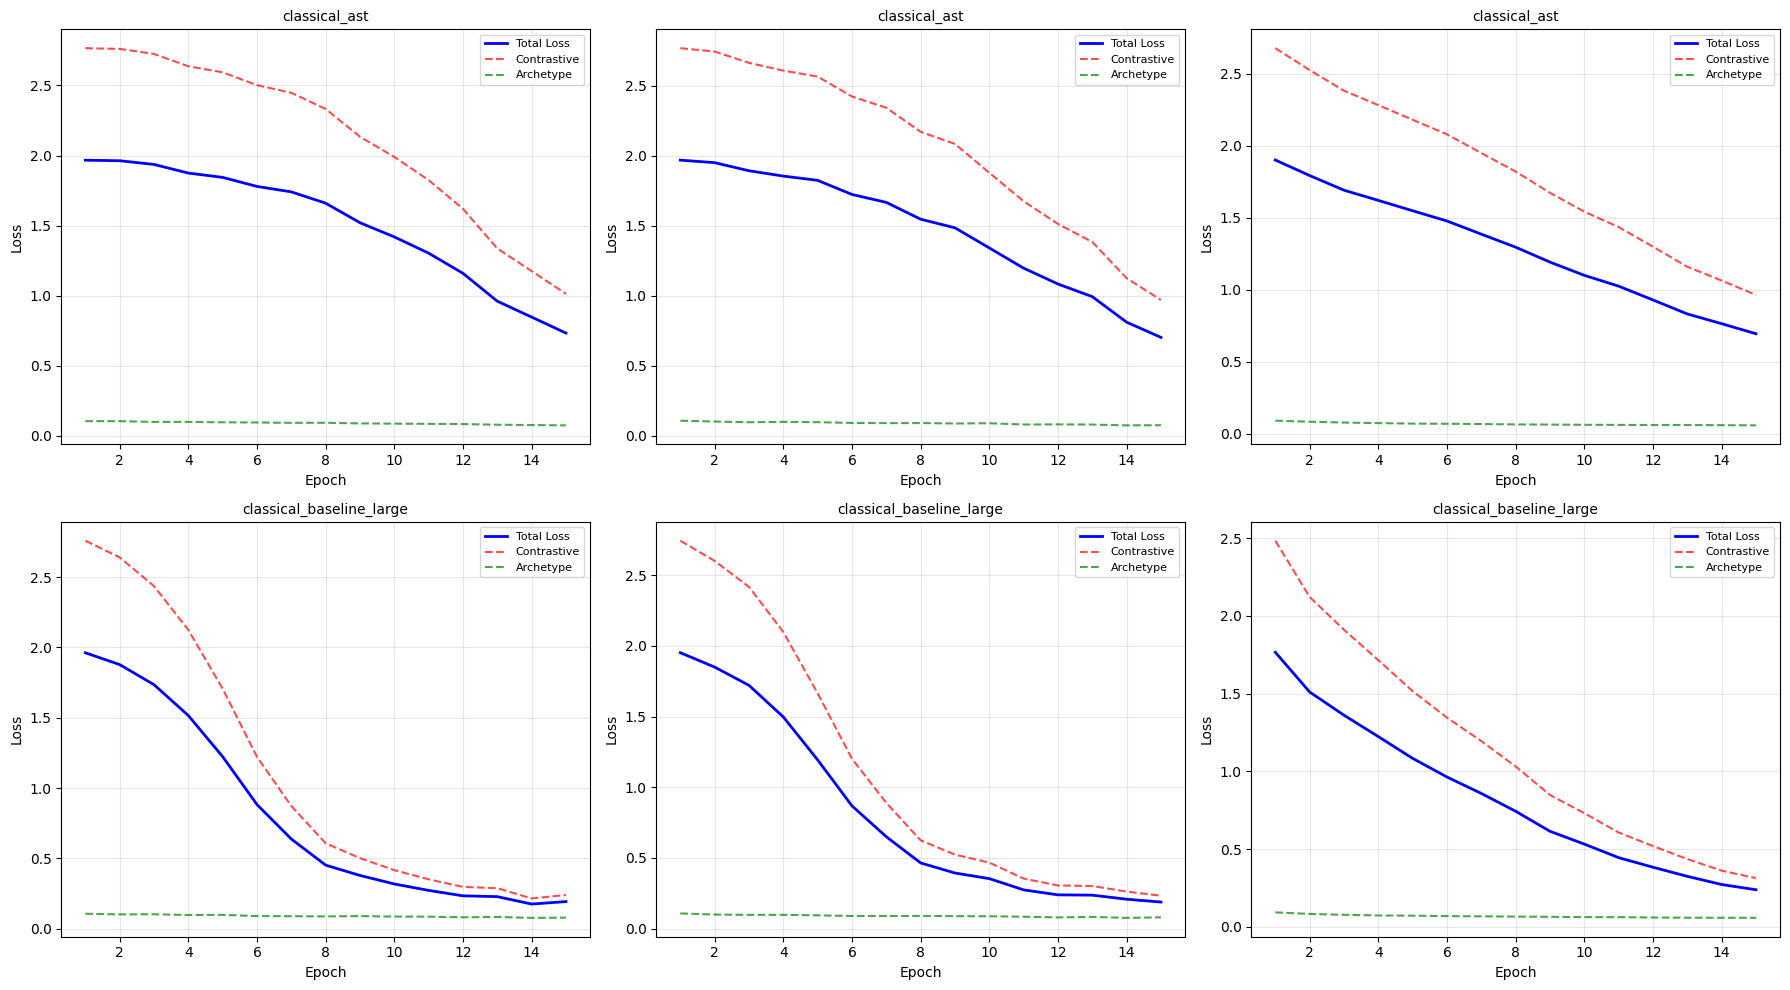

In [28]:
# Load results from JSON files
print("Loading results from JSON files...")
all_results = load_results_from_json('tuning_results')

# Analyze results
results_df = analyze_results(all_results)

# Plot training curves
if len(all_results) > 0:
    print("\nGenerating training curve plots...")
    plot_training_curves(all_results)

✓ Comparison plots saved to tuning_results/comparison_plots.png


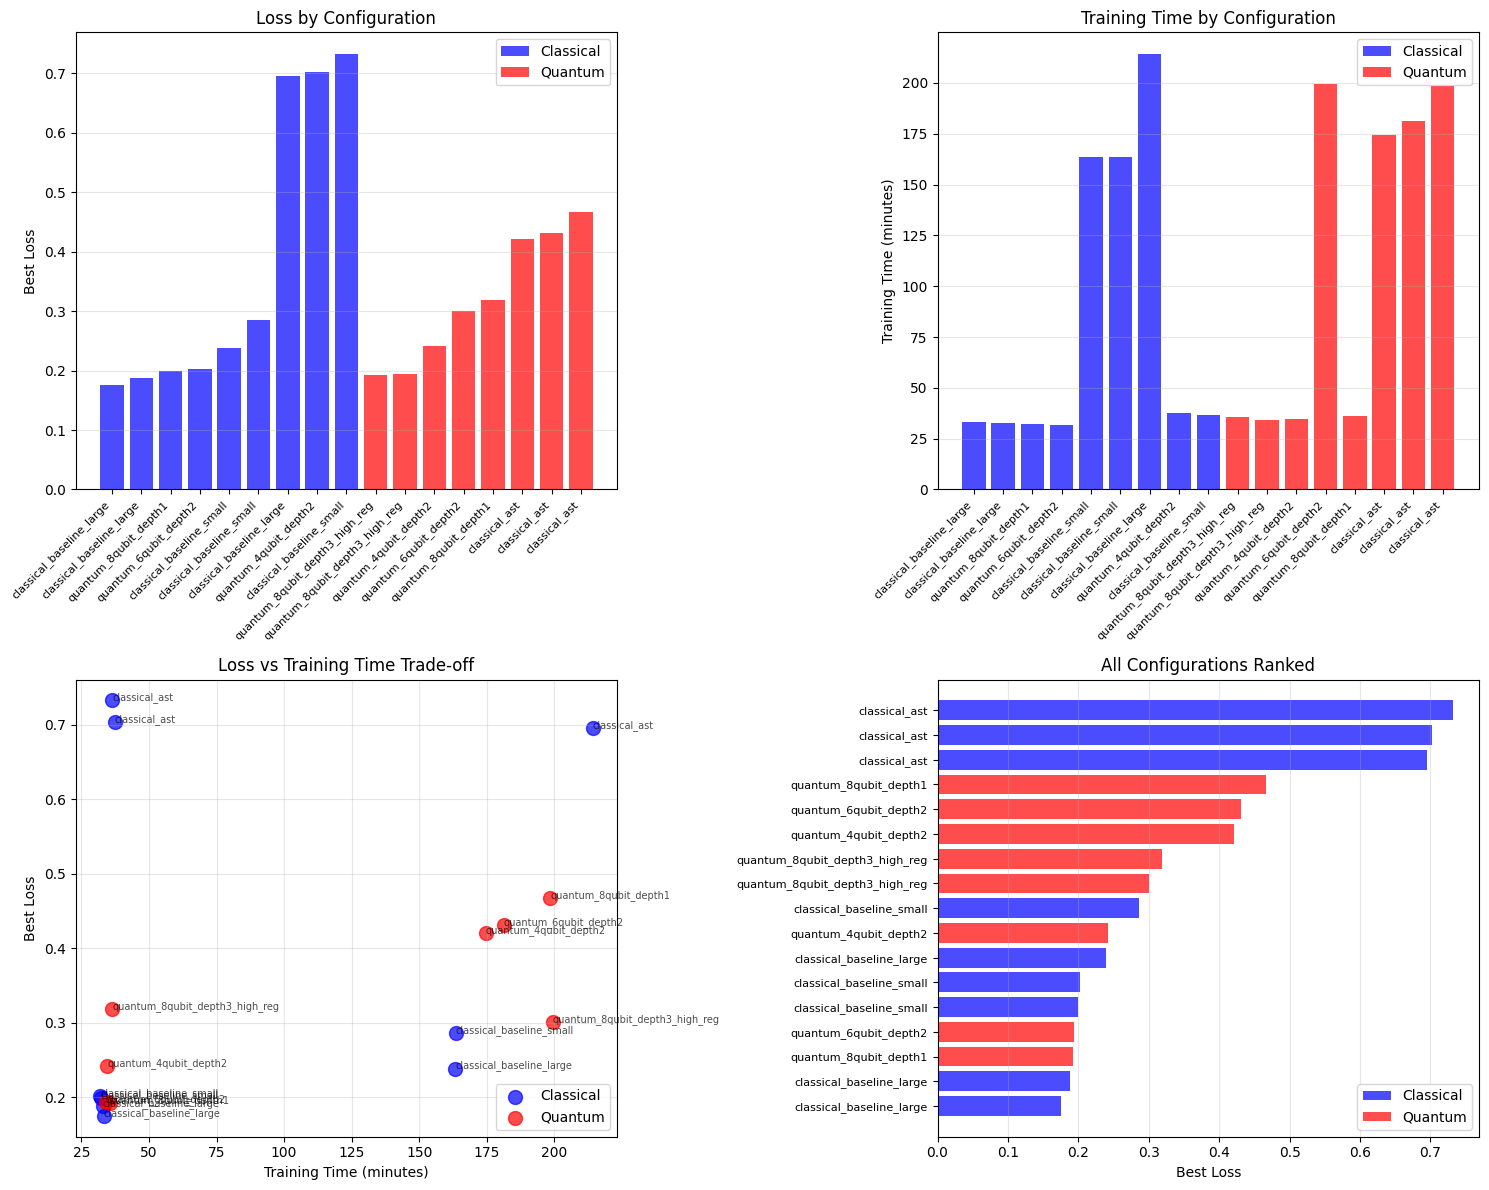

In [29]:
if len(results_df) > 0:
    plot_hyperparameter_comparison(results_df)
else:
    print("⚠️ No successful results to plot")

### Recover performance metrics from logs
validation results were not properly saved to tuning_results jsons, so we will re-attempt extraction

In [30]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_tuning_logs(log_file_path):
    with open(log_file_path, 'r') as f:
        content = f.read()

    # Split content into configuration blocks
    # We look for the "Configuration: [name]" header
    config_blocks = re.split(r'={50,}\nConfiguration: ', content)[1:] # Skip preamble
    
    parsed_data = []

    for block in config_blocks:
        # 1. Extract Config Name
        name_match = re.match(r'([^\n]+)', block)
        config_name = name_match.group(1).strip() if name_match else "Unknown"
        
        # 2. Extract Hyperparameters (Optional, allows you to pivot data later)
        lr_match = re.search(r'Learning rate:\s+([\d.e-]+)', block)
        lr = float(lr_match.group(1)) if lr_match else None
        
        batch_match = re.search(r'Batch size:\s+(\d+)', block)
        batch = int(batch_match.group(1)) if batch_match else None
        
        # 3. Extract Epoch Data
        # We iterate through the block to find per-epoch losses
        # Regex explanation:
        # Looks for "Train Losses:" followed by "total": then optionally "np.float64(" then the number
        train_pattern = r"Train Losses: \{'total': (?:np\.float64\()?([\d\.]+)"
        val_pattern = r"Val Losses: \{'total': ([\d\.]+)"
        
        train_matches = re.findall(train_pattern, block)
        val_matches = re.findall(val_pattern, block)
        
        # Determine number of epochs found
        epochs = range(1, len(train_matches) + 1)
        
        for i, epoch in enumerate(epochs):
            # Safe extraction in case val_loss is missing for an epoch
            val_loss = float(val_matches[i]) if i < len(val_matches) else None
            train_loss = float(train_matches[i])
            
            entry = {
                'config_name': config_name,
                'epoch': epoch,
                'learning_rate': lr,
                'batch_size': batch,
                'train_loss': train_loss,
                'val_loss': val_loss
            }
            parsed_data.append(entry)

    return pd.DataFrame(parsed_data)


In [31]:
# --- EXECUTION ---
# 1. Save your cell output text to 'raw_tuning_logs.txt'
# 2. Run the parser
df_results = parse_tuning_logs('raw_tuning_logs.txt')

print(f"Successfully parsed {len(df_results)} data points.")
print(df_results.head())

# --- ANALYSIS ---

# 1. Find Best Configuration (Lowest Validation Loss)
best_config = df_results.loc[df_results['val_loss'].idxmin()]
print(f"\n🏆 Best Configuration: {best_config['config_name']}")
print(f"   Min Val Loss: {best_config['val_loss']}")
print(f"   Epoch: {best_config['epoch']}")

# 2. Pivot Table for easy comparison
summary = df_results.groupby('config_name').agg({
    'val_loss': ['min', 'last'], # Best loss and final loss
    'train_loss': 'last'
}).sort_values(('val_loss', 'min'))

print("\n📊 Leaderboard:")
print(summary)

Successfully parsed 105 data points.
                config_name  epoch  learning_rate  batch_size  train_loss  \
0  classical_baseline_small      1         0.0001          32    2.392570   
1  classical_baseline_small      2         0.0001          32    2.271017   
2  classical_baseline_small      3         0.0001          32    2.099490   
3  classical_baseline_small      4         0.0001          32    1.831753   
4  classical_baseline_small      5         0.0001          32    1.434532   

   val_loss  
0  2.130975  
1  2.119428  
2  2.106614  
3  2.144040  
4  2.096494  

🏆 Best Configuration: quantum_8qubit_depth3_high_reg
   Min Val Loss: 1.7025506019592285
   Epoch: 8

📊 Leaderboard:
                                val_loss           train_loss
                                     min      last       last
config_name                                                  
quantum_8qubit_depth3_high_reg  1.702551  2.001161   0.318821
classical_ast                   1.714513  2.027281

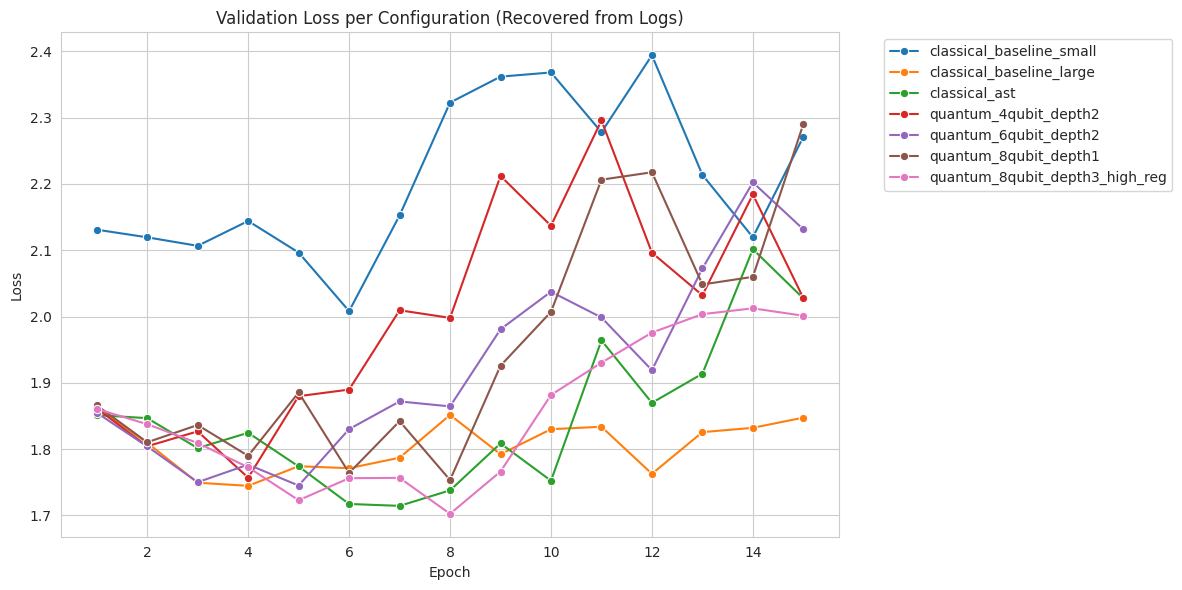

In [32]:
# Create a cleaner plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot Validation Loss curves
sns.lineplot(
    data=df_results,
    x='epoch', 
    y='val_loss', 
    hue='config_name',
    marker='o',
    dashes=False
)

plt.title('Validation Loss per Configuration (Recovered from Logs)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Recreate analysis and visualization from before

In [33]:
def parse_logs_to_dataframe(log_file_path):
    with open(log_file_path, 'r') as f:
        content = f.read()

    # Split into config blocks
    config_blocks = re.split(r'={50,}\nConfiguration: ', content)[1:]
    
    epoch_data = []
    meta_data = []

    for block in config_blocks:
        # 1. Extract Name
        name_match = re.match(r'([^\n]+)', block)
        config_name = name_match.group(1).strip() if name_match else "Unknown"
        
        # 2. Extract Time (often at the bottom of the block)
        time_match = re.search(r'Training time:\s+([\d\.]+)\s+minutes', block)
        train_time_min = float(time_match.group(1)) if time_match else None

        # 3. Extract Epoch Losses
        # Regex to find: "Train Losses: {'total': 2.39..." and "Val Losses: {'total': 2.13..."
        train_matches = re.findall(r"Train Losses: \{'total': (?:np\.float64\()?([\d\.]+)", block)
        val_matches = re.findall(r"Val Losses: \{'total': (?:np\.float64\()?([\d\.]+)", block)
        
        # Capture Contrastive/Archetype if available (optional, but good for plotting)
        contrast_matches = re.findall(r"'contrastive': (?:np\.float64\()?([\d\.]+)", block)

        for i in range(len(train_matches)):
            row = {
                'name': config_name,
                'epoch': i + 1,
                'train_loss': float(train_matches[i]),
                'val_loss': float(val_matches[i]) if i < len(val_matches) else None,
                'contrastive_loss': float(contrast_matches[i]) if i < len(contrast_matches) else None
            }
            epoch_data.append(row)
            
        # Store metadata to merge later
        if train_time_min:
            meta_data.append({'name': config_name, 'training_time_min': train_time_min})

    return pd.DataFrame(epoch_data), pd.DataFrame(meta_data)

In [34]:
def analyze_results_from_logs(df_epochs, df_meta, original_configs):
    """
    Refactored to analyze parsed DataFrame instead of JSON results.
    merges:
      1. Aggregated stats from df_epochs (Best Loss, Final Loss)
      2. Time data from df_meta
      3. Static hyperparameters from original_configs
    """
    summary_rows = []

    # Map original configs for easy lookup
    config_map = {c['name']: c for c in original_configs}

    # Group by configuration name
    grouped = df_epochs.groupby('name')

    for name, group in grouped:
        if name not in config_map:
            continue
            
        orig_config = config_map[name]
        
        # Calculate Statistics
        val_losses = group['val_loss'].dropna()
        train_losses = group['train_loss'].dropna()
        
        # Determine best/final losses
        if not val_losses.empty:
            best_loss = val_losses.min()
            final_loss = val_losses.iloc[-1]
            loss_type = 'val'
        else:
            best_loss = train_losses.min()
            final_loss = train_losses.iloc[-1]
            loss_type = 'train (fallback)'

        # Get Training Time
        time_row = df_meta[df_meta['name'] == name]
        train_time = time_row['training_time_min'].values[0] if not time_row.empty else 0

        row = {
            'name': name,
            'quantum': orig_config['use_quantum_attention'],
            'embedding_dim': orig_config['embedding_dim'],
            'architecture': orig_config['audio_architecture'],
            'batch_size': orig_config['batch_size'],
            'learning_rate': orig_config['learning_rate'],
            'best_loss': best_loss,
            'final_loss': final_loss,
            'loss_type': loss_type,
            'training_time_min': train_time,
            'epochs_completed': len(group)
        }

        # Add Quantum Specifics
        if orig_config['use_quantum_attention']:
            row['n_qubits'] = orig_config.get('n_qubits', 8)
            row['circuit_depth'] = orig_config.get('circuit_depth', 'N/A')
        
        summary_rows.append(row)

    df_summary = pd.DataFrame(summary_rows).sort_values('best_loss')
    
    # --- PRINT SUMMARY ---
    print("\n" + "="*80)
    print("RECOVERED HYPERPARAMETER RESULTS")
    print("="*80 + "\n")
    
    display_cols = ['name', 'best_loss', 'epochs_completed', 'training_time_min']
    print(df_summary[display_cols].to_string(index=False))

    return df_summary


def plot_training_curves_from_logs(df_epochs, results_dir='tuning_results'):
    """
    Refactored to plot directly from the epoch-level DataFrame.
    """
    results_dir = Path(results_dir)
    results_dir.mkdir(exist_ok=True)
    
    unique_configs = df_epochs['name'].unique()
    num_configs = len(unique_configs)
    
    # Calculate grid size (approximate)
    cols = 3
    rows = (num_configs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    axes = axes.flatten()

    for idx, config_name in enumerate(unique_configs):
        ax = axes[idx]
        data = df_epochs[df_epochs['name'] == config_name]
        
        # Plot Total Train
        ax.plot(data['epoch'], data['train_loss'], 'b-', label='Train Loss', linewidth=2)
        
        # Plot Validation
        if data['val_loss'].notna().any():
            ax.plot(data['epoch'], data['val_loss'], 'r-', label='Val Loss', linewidth=2)
            
        # Plot Contrastive (if available)
        if 'contrastive_loss' in data.columns and data['contrastive_loss'].notna().any():
             ax.plot(data['epoch'], data['contrastive_loss'], 'g--', alpha=0.5, label='Contrastive')

        ax.set_title(config_name, fontsize=10, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    # Turn off unused subplots
    for idx in range(num_configs, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig(results_dir / 'recovered_training_curves.png', dpi=300)
    print(f"✓ Curves saved to {results_dir / 'recovered_training_curves.png'}")
    plt.show()


def plot_comparison_from_summary(df_summary, results_dir='tuning_results'):
    """
    Refactored to take the summary DataFrame directly.
    """
    results_dir = Path(results_dir)
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Bar Chart: Best Loss by Configuration
    ax = axes[0]
    
    # Color logic
    colors = ['#ff9999' if q else '#66b3ff' for q in df_summary['quantum']]
    
    bars = ax.barh(df_summary['name'], df_summary['best_loss'], color=colors)
    ax.set_xlabel('Best Validation Loss')
    ax.set_title('Leaderboard (Lower is Better)')
    ax.invert_yaxis() # Best on top
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='#66b3ff', label='Classical'),
                       Patch(facecolor='#ff9999', label='Quantum')]
    ax.legend(handles=legend_elements)

    # 2. Scatter: Time vs Loss
    ax = axes[1]
    classical = df_summary[~df_summary['quantum']]
    quantum = df_summary[df_summary['quantum']]
    
    ax.scatter(classical['training_time_min'], classical['best_loss'], 
               c='#66b3ff', s=100, label='Classical', edgecolors='black')
    ax.scatter(quantum['training_time_min'], quantum['best_loss'], 
               c='#ff9999', s=100, label='Quantum', edgecolors='black')
    
    for _, row in df_summary.iterrows():
        ax.text(row['training_time_min'], row['best_loss'], 
                f"  {row['name']}", fontsize=8, va='center')

    ax.set_xlabel('Training Time (min)')
    ax.set_ylabel('Best Loss')
    ax.set_title('Efficiency Frontier: Time vs Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(results_dir / 'recovered_comparison.png', dpi=300)
    print(f"✓ Comparison plots saved to {results_dir / 'recovered_comparison.png'}")
    plt.show()


RECOVERED HYPERPARAMETER RESULTS

                          name  best_loss  epochs_completed  training_time_min
quantum_8qubit_depth3_high_reg   1.702551                15              36.37
                 classical_ast   1.714513                15              37.40
      classical_baseline_large   1.744711                15              32.87
         quantum_6qubit_depth2   1.745138                15              34.05
         quantum_8qubit_depth1   1.753453                15              35.50
         quantum_4qubit_depth2   1.757019                15              34.61
      classical_baseline_small   2.008144                15              32.12
✓ Curves saved to tuning_results/recovered_training_curves.png


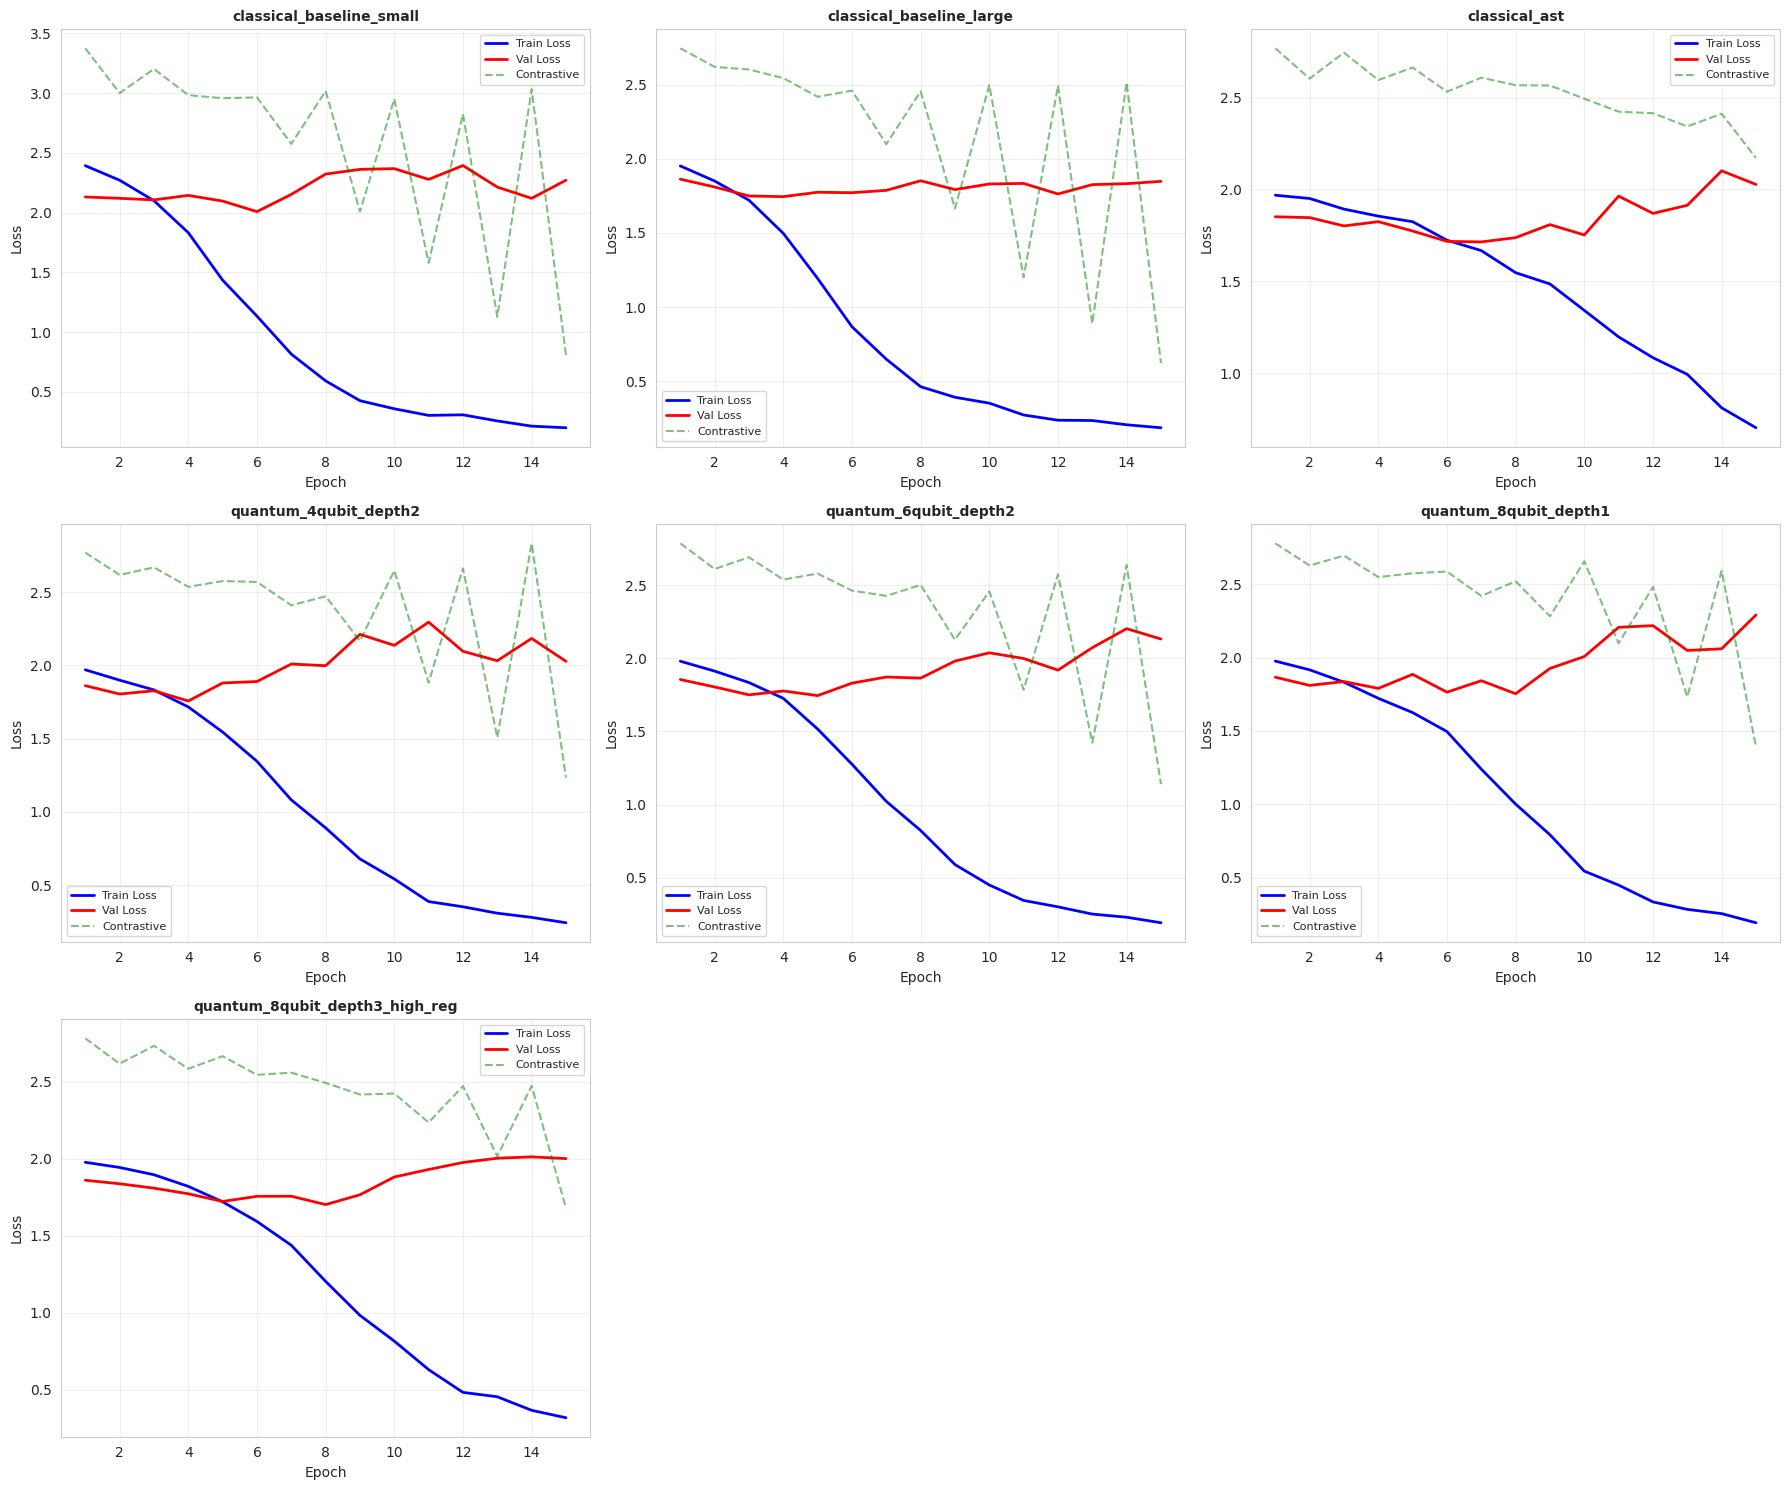

✓ Comparison plots saved to tuning_results/recovered_comparison.png


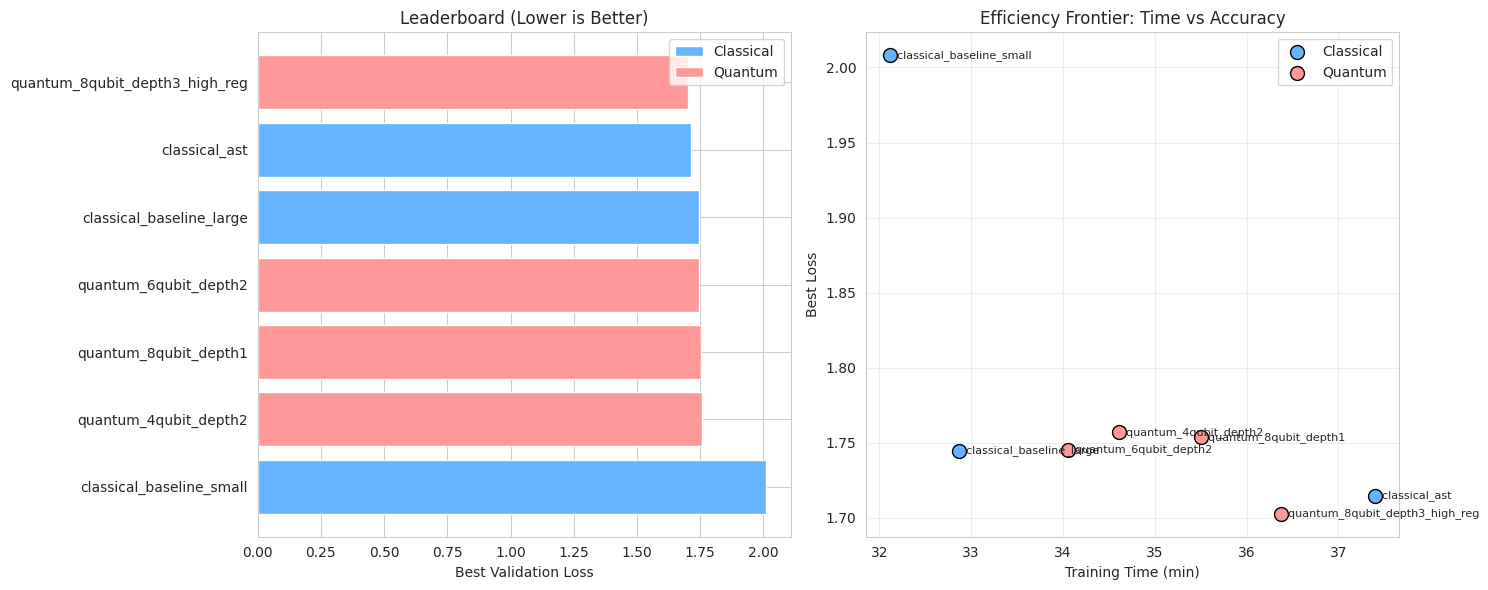

In [35]:
# 1. Parse the text file
df_epochs, df_meta = parse_logs_to_dataframe('raw_tuning_logs.txt')

# 2. Generate Summary Analysis (Requires your original hyperparameter_configs list)
df_summary = analyze_results_from_logs(df_epochs, df_meta, hyperparameter_configs)

# 3. Generate Plots
plot_training_curves_from_logs(df_epochs)
plot_comparison_from_summary(df_summary)

In [36]:
def generate_final_report(results_df, all_results):
    """
    Generate a comprehensive text report of the hyperparameter search
    
    Args:
        results_df: DataFrame with summary statistics
        all_results: List of detailed results
    """
    report_path = Path('tuning_results') / 'final_report.txt'
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("LSTMABAR HYPERPARAMETER TUNING REPORT\n")
        f.write("="*80 + "\n\n")
        
        from datetime import datetime
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total configurations tested: {len(all_results)}\n")
        f.write(f"Successful runs: {len(results_df)}\n\n")
        
        if len(results_df) == 0:
            f.write("No successful runs to report.\n")
            return
        
        # Best overall
        best = results_df.iloc[0]
        f.write("BEST OVERALL CONFIGURATION\n")
        f.write("-" * 80 + "\n")
        f.write(f"Name: {best['name']}\n")
        f.write(f"Type: {'Quantum' if best['quantum'] else 'Classical'}\n")
        f.write(f"Best Loss: {best['best_loss']:.4f} ({best['loss_type']})\n")
        f.write(f"Final Loss: {best['final_loss']:.4f}\n")
        f.write(f"Training Time: {best['training_time_min']:.2f} minutes\n")
        f.write(f"Embedding Dimension: {best['embedding_dim']}\n")
        f.write(f"Architecture: {best['architecture']}\n")
        f.write(f"Batch Size: {best['batch_size']}\n")
        f.write(f"Learning Rate: {best['learning_rate']}\n")
        if best['quantum']:
            f.write(f"Number of Qubits: {best.get('n_qubits', 'N/A')}\n")
        f.write("\n")
        
        # Classical comparison
        classical_df = results_df[results_df['quantum'] == False]
        if len(classical_df) > 0:
            f.write("BEST CLASSICAL CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            best_classical = classical_df.iloc[0]
            f.write(f"Name: {best_classical['name']}\n")
            f.write(f"Best Loss: {best_classical['best_loss']:.4f}\n")
            f.write(f"Training Time: {best_classical['training_time_min']:.2f} minutes\n\n")
        
        # Quantum comparison
        quantum_df = results_df[results_df['quantum'] == True]
        if len(quantum_df) > 0:
            f.write("BEST QUANTUM CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            best_quantum = quantum_df.iloc[0]
            f.write(f"Name: {best_quantum['name']}\n")
            f.write(f"Best Loss: {best_quantum['best_loss']:.4f}\n")
            f.write(f"Number of Qubits: {best_quantum.get('n_qubits', 'N/A')}\n")
            f.write(f"Training Time: {best_quantum['training_time_min']:.2f} minutes\n\n")
        
        # Full rankings
        f.write("FULL RANKINGS\n")
        f.write("-" * 80 + "\n")
        for idx, row in results_df.iterrows():
            f.write(f"{idx+1}. {row['name']}\n")
            f.write(f"   Loss: {row['best_loss']:.4f} | Time: {row['training_time_min']:.2f}min\n")
        
        f.write("\n" + "="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"✓ Final report saved to {report_path}")
    
    # Also print to console
    with open(report_path, 'r') as f:
        print("\n" + f.read())

In [37]:
# Generate report
if len(results_df) > 0:
    generate_final_report(results_df, all_results)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING ANALYSIS COMPLETE!")
print("="*80)
print("\nResults saved to:")
print("  - tuning_results/summary.csv")
print("  - tuning_results/training_curves.png")
print("  - tuning_results/comparison_plots.png")
print("  - tuning_results/final_report.txt")
if len(results_df) > 0:
    best_config_name = results_df.iloc[0]['name']
    print(f"\nBest model checkpoint:")
    print(f"  - tuning_checkpoints/{best_config_name}/best_model.pth")

✓ Final report saved to tuning_results/final_report.txt

LSTMABAR HYPERPARAMETER TUNING REPORT

Date: 2025-12-06 19:22:00
Total configurations tested: 17
Successful runs: 17

BEST OVERALL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_baseline_large
Type: Classical
Best Loss: 0.1752 (train)
Final Loss: 0.1927
Training Time: 33.17 minutes
Embedding Dimension: 768
Architecture: resnet
Batch Size: 16
Learning Rate: 5e-05

BEST CLASSICAL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_baseline_large
Best Loss: 0.1752
Training Time: 33.17 minutes

BEST QUANTUM CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth1
Best Loss: 0.1927
Number of Qubits: 8.0
Training Time: 35.50 minutes

FULL RANKINGS
--------------------------------------------------------------------------------
4. classical_baseline_l

#### Generate final report from tuning logs

In [38]:
from pathlib import Path
from datetime import datetime
import pandas as pd

def generate_final_report_from_logs(df_summary, total_configs_count=None, output_dir='tuning_results'):
    """
    Generate a comprehensive text report using the recovered DataFrame.
    
    Args:
        df_summary: The DataFrame returned by analyze_results_from_logs
        total_configs_count: Optional int, total number of configs defined in your list
                             (useful to see if any crashed completely and are missing)
        output_dir: Directory to save the report
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    report_path = output_dir / 'final_report.txt'
    
    # Ensure df is sorted by best_loss
    df_summary = df_summary.sort_values('best_loss')
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("LSTMABAR HYPERPARAMETER TUNING REPORT (RECOVERED FROM LOGS)\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        # Calculate counts
        successful_runs = len(df_summary)
        total_runs = total_configs_count if total_configs_count else successful_runs
        
        f.write(f"Total configurations accounted for: {total_runs}\n")
        f.write(f"Successful parsed runs: {successful_runs}\n")
        if total_runs > successful_runs:
            f.write(f"⚠️ Missing/Failed runs: {total_runs - successful_runs}\n")
        f.write("\n")
        
        if len(df_summary) == 0:
            f.write("No successful runs to report.\n")
            return
        
        # Best overall (First row, since we sorted)
        best = df_summary.iloc[0]
        f.write("BEST OVERALL CONFIGURATION\n")
        f.write("-" * 80 + "\n")
        f.write(f"Name: {best['name']}\n")
        f.write(f"Type: {'Quantum' if best['quantum'] else 'Classical'}\n")
        f.write(f"Best Loss: {best['best_loss']:.4f} ({best['loss_type']})\n")
        f.write(f"Final Loss: {best['final_loss']:.4f}\n")
        f.write(f"Training Time: {best['training_time_min']:.2f} minutes\n")
        f.write(f"Embedding Dimension: {best['embedding_dim']}\n")
        f.write(f"Architecture: {best['architecture']}\n")
        f.write(f"Batch Size: {best['batch_size']}\n")
        f.write(f"Learning Rate: {best['learning_rate']}\n")
        
        # Handle N/A for quantum params safely
        if best['quantum']:
            f.write(f"Number of Qubits: {best.get('n_qubits', 'N/A')}\n")
            f.write(f"Circuit Depth: {best.get('circuit_depth', 'N/A')}\n")
        f.write("\n")
        
        # Classical comparison
        classical_df = df_summary[df_summary['quantum'] == False]
        if len(classical_df) > 0:
            f.write("BEST CLASSICAL CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            # Since df_summary is sorted by loss, the first classical entry is the best classical
            best_classical = classical_df.iloc[0]
            f.write(f"Name: {best_classical['name']}\n")
            f.write(f"Best Loss: {best_classical['best_loss']:.4f}\n")
            f.write(f"Training Time: {best_classical['training_time_min']:.2f} minutes\n\n")
        
        # Quantum comparison
        quantum_df = df_summary[df_summary['quantum'] == True]
        if len(quantum_df) > 0:
            f.write("BEST QUANTUM CONFIGURATION\n")
            f.write("-" * 80 + "\n")
            # Since df_summary is sorted by loss, the first quantum entry is the best quantum
            best_quantum = quantum_df.iloc[0]
            f.write(f"Name: {best_quantum['name']}\n")
            f.write(f"Best Loss: {best_quantum['best_loss']:.4f}\n")
            f.write(f"Number of Qubits: {best_quantum.get('n_qubits', 'N/A')}\n")
            f.write(f"Training Time: {best_quantum['training_time_min']:.2f} minutes\n\n")
        
        # Full rankings
        f.write("FULL RANKINGS (Ordered by Loss)\n")
        f.write("-" * 80 + "\n")
        
        # Re-indexing from 1 for the leaderboard
        rank = 1
        for _, row in df_summary.iterrows():
            f.write(f"{rank}. {row['name']}\n")
            f.write(f"   Loss: {row['best_loss']:.4f} | Time: {row['training_time_min']:.2f}min | Epochs: {row['epochs_completed']}\n")
            rank += 1
        
        f.write("\n" + "="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")
    
    print(f"✓ Final report saved to {report_path}")
    
    # Also print to console
    with open(report_path, 'r') as f:
        print("\n" + f.read())

In [39]:
# 4. Generate Text Report
generate_final_report_from_logs(
    df_summary, 
    total_configs_count=len(hyperparameter_configs) # Optional: passes 7
)

✓ Final report saved to tuning_results/final_report.txt

LSTMABAR HYPERPARAMETER TUNING REPORT (RECOVERED FROM LOGS)

Date: 2025-12-06 19:22:00
Total configurations accounted for: 7
Successful parsed runs: 7

BEST OVERALL CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth3_high_reg
Type: Quantum
Best Loss: 1.7026 (val)
Final Loss: 2.0012
Training Time: 36.37 minutes
Embedding Dimension: 768
Architecture: resnet
Batch Size: 16
Learning Rate: 5e-05
Number of Qubits: 8.0
Circuit Depth: 3.0

BEST CLASSICAL CONFIGURATION
--------------------------------------------------------------------------------
Name: classical_ast
Best Loss: 1.7145
Training Time: 37.40 minutes

BEST QUANTUM CONFIGURATION
--------------------------------------------------------------------------------
Name: quantum_8qubit_depth3_high_reg
Best Loss: 1.7026
Number of Qubits: 8.0
Training Time: 36.37 minutes

FULL RANKINGS (Ordered by Loss)
-----------